In [1]:
import gdown
import zipfile
import os
import requests
import shutil
import zipfile

def download_the_datasets(folder):
    url = 'https://drive.google.com/uc?id=1PryA3BDyEsV8Ft8QJk9s7_bE24pHWld8'
    output = folder + '/train_data.csv.zip'
    gdown.download(url, output, quiet=True)

    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall(folder)

    url = 'https://drive.google.com/uc?id=1zTm5KF-RUC3A1YDC_-hkfZq-FgErDnus'
    output = folder + '/sample_predictions.csv'
    gdown.download(url, output, quiet=True)
    
    url = 'https://piazza.com/redirect/s3?bucket=uploads&prefix=paste%2Fjxc0yout1il6z6%2Fa74c25ee93664b05017689ccf868b215baf5fb89e9e55de50ee36221cf7db3ad%2Ftest_solutions.csv.zip'
    output = folder + '/test_solutions.csv.zip'
    
    r = requests.get(url, stream=True)
    if r.status_code == 200:
        with open(output, 'wb') as f:
            r.raw.decode_content = True
            shutil.copyfileobj(r.raw, f)
            
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall(folder)
        
    


def initialize_folders():
    """
    Need to be run once on the notebook initialization to create folders structure
    """
    input_folder = '../input'
    os.mkdir(input_folder)
    download_the_datasets(input_folder)
    os.mkdir('../output')
    os.mkdir('../output/intermediate')
    os.mkdir('../output/final')

initialize_folders()

FileExistsError: [Errno 17] File exists: '../input'

In [31]:
from models import BaselineModel, DiffVarModel, VarModel, LastDayModel, LastValueModel, LastCloseModel, IndexedTimeSeriesSplit, LinearNaiveModel, LinearClippedModel, SeperateModels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from constants import *

from sklearn.model_selection import cross_validate, TimeSeriesSplit
from sklearn.metrics import make_scorer
from evaluation import evaluation, Validator
from sklearn.model_selection import GridSearchCV

In [32]:
#------------------------#
# 0. Housekeeping
#------------------------#

   
    
df = pd.read_csv('../input/train_data.csv')

pivot = df.pivot(index=['day', 'time'], columns='symbol',values=None)
pv = pivot.ffill().bfill().reset_index()
text_time = pv['time']
pv['morning'] = (pv['time'] < '06:30:00').astype(int)
pv.index = pv['day'].astype(str) + '-' + pv['time'].astype(str)
pv['time'] = pd.to_datetime(pv['time'])        
pv['time'] = (pv['time'] - min(pv['time'])).dt.total_seconds() / 5
matrix_repr = pv.values
pv.sample(5)

day    time    open                                          \
symbol                        A       B       C       D       E       F   
64-06:04:00  64    48.0  147.08  107.63  102.94  241.39  128.40  176.84   
45-06:07:55  45    95.0  142.20  109.12   98.02  228.74  123.76  171.30   
20-07:09:45  20   837.0  134.13  105.76   95.91  219.64  113.48  163.64   
6-06:51:00    6   612.0  134.88  104.47   90.91  215.40  121.00  158.19   
80-11:24:55  80  3899.0  150.82  112.81  100.46  248.92  125.79  182.13   

                            ... average                                  \
symbol            G      H  ...       B       C       D       E       F   
64-06:04:00  181.70  89.08  ...  107.65  102.94  241.39  128.40  176.82   
45-06:07:55  181.31  88.95  ...  109.11   98.02  228.74  123.76  171.27   
20-07:09:45  181.19  90.51  ...  105.76   95.91  219.64  113.48  163.63   
6-06:51:00   165.48  87.78  ...  104.47   90.92  215.38  121.00  158.20   
80-11:24:55  169.82  79.70  ...  112.81  100.45  248.93  125.79  182.13   

                                           morning  
symbol            G      H       I       J          
64-06:04:00  181.70  89.08  177.85  169.44       1  
45-06:07:55  181.31  88.95  182.71  167.15       1  
20-07:09:45  181.17  90.51  171.38  169.40       0  
6-06:51:00   165.48  87.78  163.32  163.47       0  
80-11:24:55  169.82  79.71  176.64  193.98       0  

[5 rows x 53 columns]

# Preprocessing and Selection

<AxesSubplot:xlabel='day-time', ylabel='symbol'>

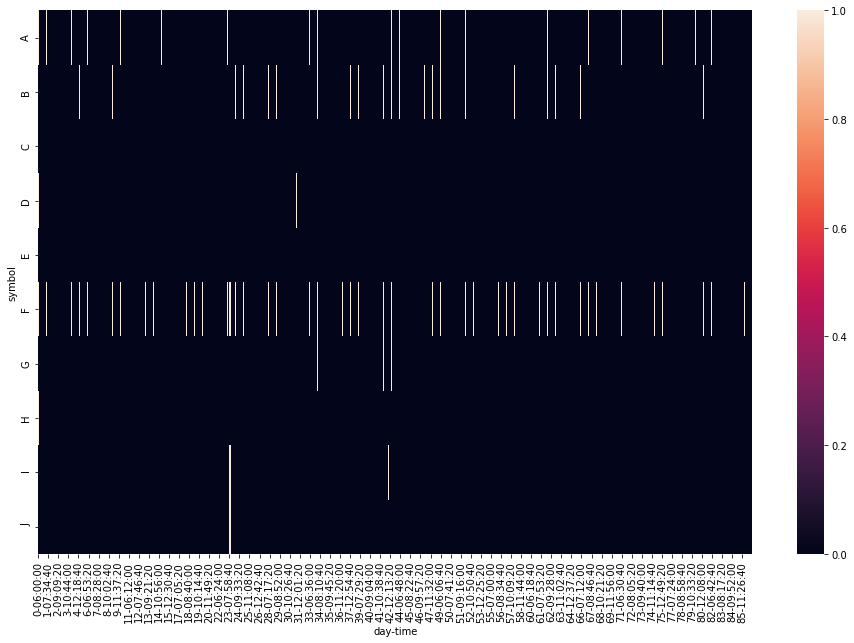

In [3]:
fig, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(np.transpose(pivot['open'].isna()), ax=ax)

# consider fixing it with ffill? or bfill?
# what about shifts?

In [3]:
#------------------------#
# 3. Data mining
#------------------------#


# idea 0: features additional than open has very little additional information
print(df[['open', 'high', 'low', 'close', 'average']].cov())
print(df[['open', 'high', 'low', 'close', 'average', 'symbol']].groupby('symbol').diff().corr())

                open         high          low        close      average
open     1875.672065  1875.723649  1875.631208  1875.669503  1875.674585
high     1875.723649  1875.775464  1875.682781  1875.721249  1875.726266
low      1875.631208  1875.682781  1875.590602  1875.628817  1875.633836
close    1875.669503  1875.721249  1875.628817  1875.667270  1875.672184
average  1875.674585  1875.726266  1875.633836  1875.672184  1875.677224
             open      high       low     close   average
open     1.000000  0.783054  0.764655  0.609851  0.847163
high     0.783054  1.000000  0.637186  0.783451  0.867845
low      0.764655  0.637186  1.000000  0.786357  0.871386
close    0.609851  0.783451  0.786357  1.000000  0.844287
average  0.847163  0.867845  0.871386  0.844287  1.000000


# Data Mining

<AxesSubplot:xlabel='symbol', ylabel='symbol'>

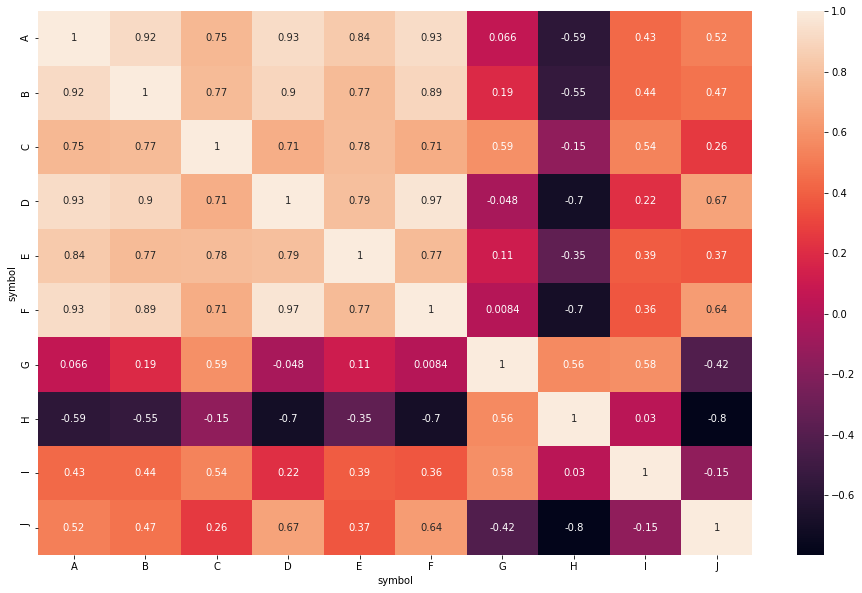

In [8]:
# idea 1: stocks can be correllated across symbols
fig, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(pivot['open'].corr(), annot=True, ax=ax)

# we found that stocks highly positively correlated ex: (A,B)
# we found that stocks highly negatively correlated ex: (H,D) 
# we found that stocks low correlated: (A,G)


# let us add a dendrogram here just to show our sophistication

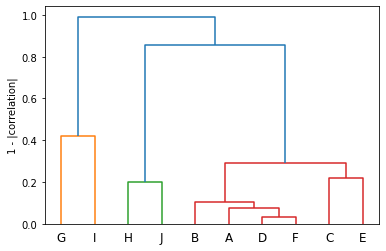

In [34]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
model = AgglomerativeClustering(n_clusters=2, linkage='complete', compute_distances=True, affinity='precomputed')
model.fit(1 - np.abs(pivot['open'].corr()))
plot_dendrogram(model, labels=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'])
plt.ylabel('1 - |correlation|')
plt.show()

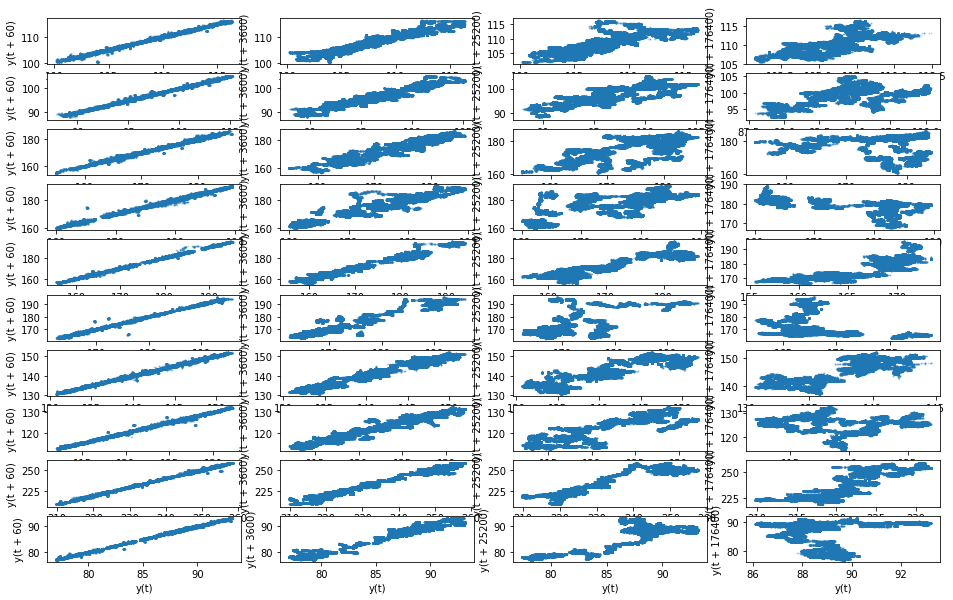

In [9]:
# idea 2
# autocorrelation is very high in short periods but very decreases with longer
# TODO: better plot design

plt.figure(1, figsize=(16, 10))
lag_ls = [60, 3600, 3600*7, 3600*7*7] # min, hour, day, week
symbol_ls = df['symbol'].unique()
k = 1

for i in range(len(symbol_ls)):
  for j in range(len(lag_ls)):  
    plt.subplot(10,4, k)
    pd.plotting.lag_plot(pivot['open'][symbol_ls[i]], lag=lag_ls[j],  s=1, alpha = .2)
    k += 1

<AxesSubplot:xlabel='day,time'>

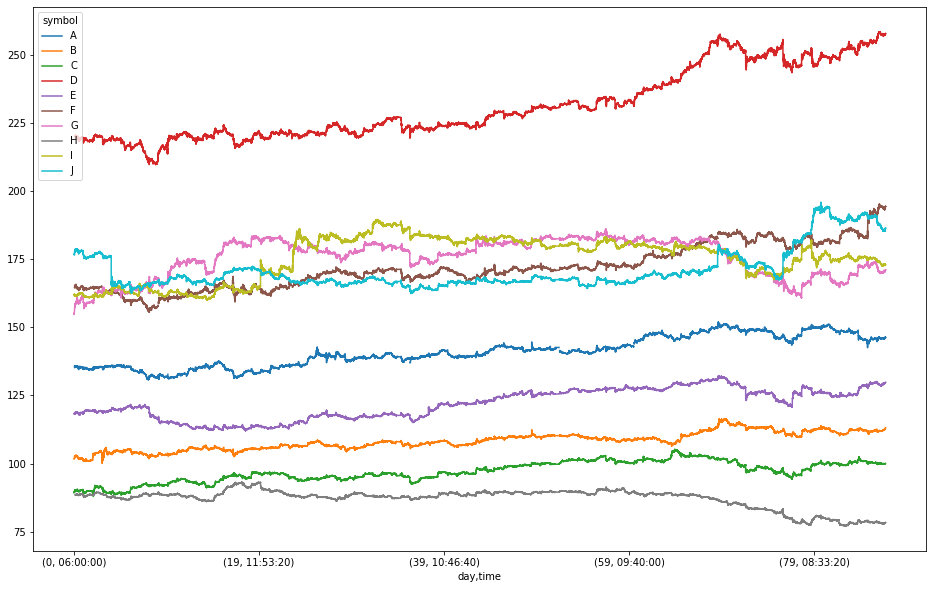

In [10]:
fig, ax = plt.subplots(figsize=(16, 10))
pivot['open'].plot(ax=ax)


array([[<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>],
       [<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>],
       [<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>],
       [<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>],
       [<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>]],
      dtype=object)

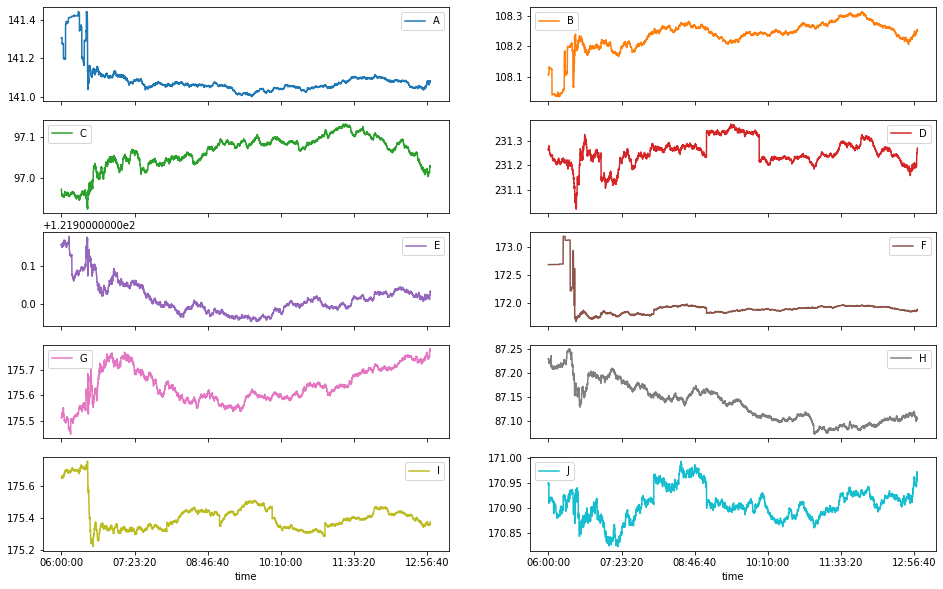

In [33]:
within_day = df.pivot_table(index='time', columns='symbol', values='open')

#fig, ax = plt.subplots(figsize=(16, 10))
within_day.plot(subplots=True, layout=(5, 2), figsize=(16, 10))

# Linear Model demonstration

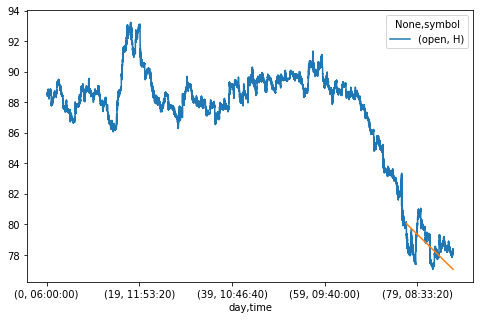

In [60]:
endog_mask = ~pv.columns.isin([('day', ''), ('time', ''), ('morning', '')])
exog_mask = pv.columns.isin([('day', ''), ('time', ''), ('morning', '')])
y = pv.iloc[:, endog_mask].to_numpy()
X = pv.iloc[:, exog_mask].to_numpy()

fig, ax = plt.subplots(figsize=(8, 5))
(pivot[[('open', 'H')]]).plot(ax=ax)
points = np.empty((len(X)))
points[:] = np.nan
points[-TIMESTEPS_A_DAY*10:] = LinearNaiveModel(TIMESTEPS_A_DAY * 30).fit(
    X[:-TIMESTEPS_A_DAY*10],y[:-TIMESTEPS_A_DAY*10]
).predict(X[-TIMESTEPS_A_DAY*10:])[:,7]
ax.plot(points)


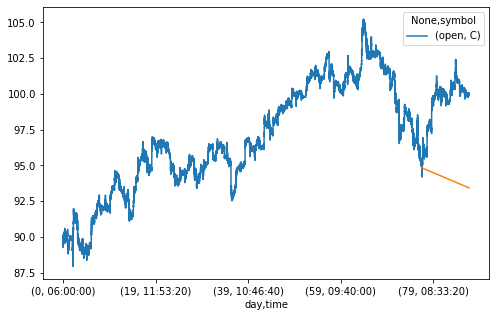

In [61]:
fig, ax = plt.subplots(figsize=(8, 5))
(pivot[[('open', 'C')]]).plot(ax=ax)
points = np.empty((len(X)))
points[:] = np.nan
points[-TIMESTEPS_A_DAY*10:] = LinearNaiveModel(TIMESTEPS_A_DAY * 30).fit(
    X[:-TIMESTEPS_A_DAY*10],y[:-TIMESTEPS_A_DAY*10]
).predict(X[-TIMESTEPS_A_DAY*10:])[:,2]
ax.plot(points)


# Models fitting

In [3]:
vl = Validator(pv, splits=np.arange(65, 80))

In [6]:
from sklearn.model_selection import GridSearchCV

linear_naive_grid_search_1 = GridSearchCV(
    LinearNaiveModel(15*TIMESTEPS_A_DAY, 10000),
    {'clip': np.concatenate([np.arange(10) * 1000, np.array([100000])]),
     'lag': np.arange(5, 31, 2) * TIMESTEPS_A_DAY}, 
    scoring=make_scorer(evaluation, greater_is_better=False, subset=slice(0,vl.midpoint*TIMESTEPS_A_DAY)),
    cv=IndexedTimeSeriesSplit(np.arange(30, 56), 0, test_size=9),
    verbose=3
).fit(vl.X, vl.y)

Fitting 26 folds for each of 143 candidates, totalling 3718 fits
[CV 1/26] END ...............clip=0, lag=25200;, score=-0.021 total time=   0.2s
[CV 2/26] END ...............clip=0, lag=25200;, score=-0.026 total time=   0.1s
[CV 3/26] END ...............clip=0, lag=25200;, score=-0.016 total time=   0.1s
[CV 4/26] END ...............clip=0, lag=25200;, score=-0.008 total time=   0.1s
[CV 5/26] END ...............clip=0, lag=25200;, score=-0.031 total time=   0.1s
[CV 6/26] END ...............clip=0, lag=25200;, score=-0.038 total time=   0.1s
[CV 7/26] END ...............clip=0, lag=25200;, score=-0.015 total time=   0.1s
[CV 8/26] END ...............clip=0, lag=25200;, score=-0.019 total time=   0.1s
[CV 9/26] END ...............clip=0, lag=25200;, score=-0.020 total time=   0.1s
[CV 10/26] END ..............clip=0, lag=25200;, score=-0.012 total time=   0.1s
[CV 11/26] END ..............clip=0, lag=25200;, score=-0.011 total time=   0.1s
[CV 12/26] END ..............clip=0, lag=252

[CV 26/26] END ..............clip=0, lag=55440;, score=-0.015 total time=   0.1s
[CV 1/26] END ...............clip=0, lag=65520;, score=-0.021 total time=   0.0s
[CV 2/26] END ...............clip=0, lag=65520;, score=-0.026 total time=   0.0s
[CV 3/26] END ...............clip=0, lag=65520;, score=-0.016 total time=   0.0s
[CV 4/26] END ...............clip=0, lag=65520;, score=-0.008 total time=   0.0s
[CV 5/26] END ...............clip=0, lag=65520;, score=-0.031 total time=   0.1s
[CV 6/26] END ...............clip=0, lag=65520;, score=-0.038 total time=   0.1s
[CV 7/26] END ...............clip=0, lag=65520;, score=-0.015 total time=   0.1s
[CV 8/26] END ...............clip=0, lag=65520;, score=-0.019 total time=   0.1s
[CV 9/26] END ...............clip=0, lag=65520;, score=-0.020 total time=   0.1s
[CV 10/26] END ..............clip=0, lag=65520;, score=-0.012 total time=   0.1s
[CV 11/26] END ..............clip=0, lag=65520;, score=-0.011 total time=   0.1s
[CV 12/26] END .............

[CV 24/26] END ..............clip=0, lag=95760;, score=-0.006 total time=   0.1s
[CV 25/26] END ..............clip=0, lag=95760;, score=-0.010 total time=   0.1s
[CV 26/26] END ..............clip=0, lag=95760;, score=-0.015 total time=   0.1s
[CV 1/26] END ..............clip=0, lag=105840;, score=-0.021 total time=   0.0s
[CV 2/26] END ..............clip=0, lag=105840;, score=-0.026 total time=   0.1s
[CV 3/26] END ..............clip=0, lag=105840;, score=-0.016 total time=   0.0s
[CV 4/26] END ..............clip=0, lag=105840;, score=-0.008 total time=   0.0s
[CV 5/26] END ..............clip=0, lag=105840;, score=-0.031 total time=   0.1s
[CV 6/26] END ..............clip=0, lag=105840;, score=-0.038 total time=   0.1s
[CV 7/26] END ..............clip=0, lag=105840;, score=-0.015 total time=   0.0s
[CV 8/26] END ..............clip=0, lag=105840;, score=-0.019 total time=   0.0s
[CV 9/26] END ..............clip=0, lag=105840;, score=-0.020 total time=   0.1s
[CV 10/26] END .............

[CV 22/26] END .............clip=0, lag=136080;, score=-0.006 total time=   0.1s
[CV 23/26] END .............clip=0, lag=136080;, score=-0.007 total time=   0.1s
[CV 24/26] END .............clip=0, lag=136080;, score=-0.006 total time=   0.1s
[CV 25/26] END .............clip=0, lag=136080;, score=-0.010 total time=   0.1s
[CV 26/26] END .............clip=0, lag=136080;, score=-0.015 total time=   0.1s
[CV 1/26] END ..............clip=0, lag=146160;, score=-0.021 total time=   0.0s
[CV 2/26] END ..............clip=0, lag=146160;, score=-0.026 total time=   0.0s
[CV 3/26] END ..............clip=0, lag=146160;, score=-0.016 total time=   0.0s
[CV 4/26] END ..............clip=0, lag=146160;, score=-0.008 total time=   0.0s
[CV 5/26] END ..............clip=0, lag=146160;, score=-0.031 total time=   0.1s
[CV 6/26] END ..............clip=0, lag=146160;, score=-0.038 total time=   0.0s
[CV 7/26] END ..............clip=0, lag=146160;, score=-0.015 total time=   0.0s
[CV 8/26] END ..............

[CV 21/26] END ...........clip=1000, lag=45360;, score=-0.004 total time=   0.1s
[CV 22/26] END ...........clip=1000, lag=45360;, score=-0.006 total time=   0.1s
[CV 23/26] END ...........clip=1000, lag=45360;, score=-0.007 total time=   0.1s
[CV 24/26] END ...........clip=1000, lag=45360;, score=-0.006 total time=   0.1s
[CV 25/26] END ...........clip=1000, lag=45360;, score=-0.010 total time=   0.1s
[CV 26/26] END ...........clip=1000, lag=45360;, score=-0.015 total time=   0.1s
[CV 1/26] END ............clip=1000, lag=55440;, score=-0.020 total time=   0.0s
[CV 2/26] END ............clip=1000, lag=55440;, score=-0.025 total time=   0.1s
[CV 3/26] END ............clip=1000, lag=55440;, score=-0.015 total time=   0.1s
[CV 4/26] END ............clip=1000, lag=55440;, score=-0.008 total time=   0.1s
[CV 5/26] END ............clip=1000, lag=55440;, score=-0.033 total time=   0.1s
[CV 6/26] END ............clip=1000, lag=55440;, score=-0.040 total time=   0.1s
[CV 7/26] END ............cl

[CV 20/26] END ...........clip=1000, lag=85680;, score=-0.010 total time=   0.1s
[CV 21/26] END ...........clip=1000, lag=85680;, score=-0.004 total time=   0.1s
[CV 22/26] END ...........clip=1000, lag=85680;, score=-0.006 total time=   0.1s
[CV 23/26] END ...........clip=1000, lag=85680;, score=-0.007 total time=   0.1s
[CV 24/26] END ...........clip=1000, lag=85680;, score=-0.006 total time=   0.1s
[CV 25/26] END ...........clip=1000, lag=85680;, score=-0.010 total time=   0.1s
[CV 26/26] END ...........clip=1000, lag=85680;, score=-0.015 total time=   0.1s
[CV 1/26] END ............clip=1000, lag=95760;, score=-0.021 total time=   0.0s
[CV 2/26] END ............clip=1000, lag=95760;, score=-0.025 total time=   0.1s
[CV 3/26] END ............clip=1000, lag=95760;, score=-0.015 total time=   0.0s
[CV 4/26] END ............clip=1000, lag=95760;, score=-0.008 total time=   0.0s
[CV 5/26] END ............clip=1000, lag=95760;, score=-0.033 total time=   0.1s
[CV 6/26] END ............cl

[CV 18/26] END ..........clip=1000, lag=126000;, score=-0.006 total time=   0.1s
[CV 19/26] END ..........clip=1000, lag=126000;, score=-0.009 total time=   0.1s
[CV 20/26] END ..........clip=1000, lag=126000;, score=-0.010 total time=   0.1s
[CV 21/26] END ..........clip=1000, lag=126000;, score=-0.004 total time=   0.1s
[CV 22/26] END ..........clip=1000, lag=126000;, score=-0.006 total time=   0.1s
[CV 23/26] END ..........clip=1000, lag=126000;, score=-0.007 total time=   0.1s
[CV 24/26] END ..........clip=1000, lag=126000;, score=-0.006 total time=   0.1s
[CV 25/26] END ..........clip=1000, lag=126000;, score=-0.010 total time=   0.1s
[CV 26/26] END ..........clip=1000, lag=126000;, score=-0.015 total time=   0.1s
[CV 1/26] END ...........clip=1000, lag=136080;, score=-0.021 total time=   0.0s
[CV 2/26] END ...........clip=1000, lag=136080;, score=-0.025 total time=   0.0s
[CV 3/26] END ...........clip=1000, lag=136080;, score=-0.016 total time=   0.0s
[CV 4/26] END ...........cli

[CV 17/26] END ...........clip=2000, lag=35280;, score=-0.008 total time=   0.1s
[CV 18/26] END ...........clip=2000, lag=35280;, score=-0.006 total time=   0.1s
[CV 19/26] END ...........clip=2000, lag=35280;, score=-0.009 total time=   0.1s
[CV 20/26] END ...........clip=2000, lag=35280;, score=-0.010 total time=   0.1s
[CV 21/26] END ...........clip=2000, lag=35280;, score=-0.004 total time=   0.1s
[CV 22/26] END ...........clip=2000, lag=35280;, score=-0.006 total time=   0.1s
[CV 23/26] END ...........clip=2000, lag=35280;, score=-0.007 total time=   0.1s
[CV 24/26] END ...........clip=2000, lag=35280;, score=-0.006 total time=   0.1s
[CV 25/26] END ...........clip=2000, lag=35280;, score=-0.010 total time=   0.1s
[CV 26/26] END ...........clip=2000, lag=35280;, score=-0.015 total time=   0.1s
[CV 1/26] END ............clip=2000, lag=45360;, score=-0.020 total time=   0.0s
[CV 2/26] END ............clip=2000, lag=45360;, score=-0.024 total time=   0.0s
[CV 3/26] END ............cl

[CV 17/26] END ...........clip=2000, lag=75600;, score=-0.008 total time=   0.1s
[CV 18/26] END ...........clip=2000, lag=75600;, score=-0.006 total time=   0.1s
[CV 19/26] END ...........clip=2000, lag=75600;, score=-0.009 total time=   0.1s
[CV 20/26] END ...........clip=2000, lag=75600;, score=-0.011 total time=   0.1s
[CV 21/26] END ...........clip=2000, lag=75600;, score=-0.004 total time=   0.1s
[CV 22/26] END ...........clip=2000, lag=75600;, score=-0.006 total time=   0.1s
[CV 23/26] END ...........clip=2000, lag=75600;, score=-0.007 total time=   0.1s
[CV 24/26] END ...........clip=2000, lag=75600;, score=-0.007 total time=   0.1s
[CV 25/26] END ...........clip=2000, lag=75600;, score=-0.011 total time=   0.1s
[CV 26/26] END ...........clip=2000, lag=75600;, score=-0.015 total time=   0.1s
[CV 1/26] END ............clip=2000, lag=85680;, score=-0.019 total time=   0.0s
[CV 2/26] END ............clip=2000, lag=85680;, score=-0.024 total time=   0.0s
[CV 3/26] END ............cl

[CV 18/26] END ..........clip=2000, lag=115920;, score=-0.006 total time=   0.1s
[CV 19/26] END ..........clip=2000, lag=115920;, score=-0.009 total time=   0.1s
[CV 20/26] END ..........clip=2000, lag=115920;, score=-0.010 total time=   0.1s
[CV 21/26] END ..........clip=2000, lag=115920;, score=-0.004 total time=   0.1s
[CV 22/26] END ..........clip=2000, lag=115920;, score=-0.006 total time=   0.1s
[CV 23/26] END ..........clip=2000, lag=115920;, score=-0.007 total time=   0.1s
[CV 24/26] END ..........clip=2000, lag=115920;, score=-0.006 total time=   0.1s
[CV 25/26] END ..........clip=2000, lag=115920;, score=-0.010 total time=   0.1s
[CV 26/26] END ..........clip=2000, lag=115920;, score=-0.015 total time=   0.1s
[CV 1/26] END ...........clip=2000, lag=126000;, score=-0.020 total time=   0.0s
[CV 2/26] END ...........clip=2000, lag=126000;, score=-0.024 total time=   0.1s
[CV 3/26] END ...........clip=2000, lag=126000;, score=-0.015 total time=   0.1s
[CV 4/26] END ...........cli

[CV 16/26] END ...........clip=3000, lag=25200;, score=-0.008 total time=   0.1s
[CV 17/26] END ...........clip=3000, lag=25200;, score=-0.009 total time=   0.1s
[CV 18/26] END ...........clip=3000, lag=25200;, score=-0.006 total time=   0.1s
[CV 19/26] END ...........clip=3000, lag=25200;, score=-0.008 total time=   0.1s
[CV 20/26] END ...........clip=3000, lag=25200;, score=-0.012 total time=   0.1s
[CV 21/26] END ...........clip=3000, lag=25200;, score=-0.004 total time=   0.1s
[CV 22/26] END ...........clip=3000, lag=25200;, score=-0.007 total time=   0.1s
[CV 23/26] END ...........clip=3000, lag=25200;, score=-0.007 total time=   0.1s
[CV 24/26] END ...........clip=3000, lag=25200;, score=-0.008 total time=   0.1s
[CV 25/26] END ...........clip=3000, lag=25200;, score=-0.011 total time=   0.1s
[CV 26/26] END ...........clip=3000, lag=25200;, score=-0.017 total time=   0.1s
[CV 1/26] END ............clip=3000, lag=35280;, score=-0.019 total time=   0.0s
[CV 2/26] END ............cl

[CV 16/26] END ...........clip=3000, lag=65520;, score=-0.009 total time=   0.1s
[CV 17/26] END ...........clip=3000, lag=65520;, score=-0.008 total time=   0.1s
[CV 18/26] END ...........clip=3000, lag=65520;, score=-0.006 total time=   0.1s
[CV 19/26] END ...........clip=3000, lag=65520;, score=-0.009 total time=   0.1s
[CV 20/26] END ...........clip=3000, lag=65520;, score=-0.009 total time=   0.1s
[CV 21/26] END ...........clip=3000, lag=65520;, score=-0.004 total time=   0.1s
[CV 22/26] END ...........clip=3000, lag=65520;, score=-0.006 total time=   0.1s
[CV 23/26] END ...........clip=3000, lag=65520;, score=-0.007 total time=   0.1s
[CV 24/26] END ...........clip=3000, lag=65520;, score=-0.007 total time=   0.1s
[CV 25/26] END ...........clip=3000, lag=65520;, score=-0.011 total time=   0.1s
[CV 26/26] END ...........clip=3000, lag=65520;, score=-0.015 total time=   0.1s
[CV 1/26] END ............clip=3000, lag=75600;, score=-0.018 total time=   0.0s
[CV 2/26] END ............cl

[CV 14/26] END ..........clip=3000, lag=105840;, score=-0.021 total time=   0.1s
[CV 15/26] END ..........clip=3000, lag=105840;, score=-0.012 total time=   0.1s
[CV 16/26] END ..........clip=3000, lag=105840;, score=-0.008 total time=   0.1s
[CV 17/26] END ..........clip=3000, lag=105840;, score=-0.008 total time=   0.1s
[CV 18/26] END ..........clip=3000, lag=105840;, score=-0.006 total time=   0.1s
[CV 19/26] END ..........clip=3000, lag=105840;, score=-0.009 total time=   0.1s
[CV 20/26] END ..........clip=3000, lag=105840;, score=-0.010 total time=   0.1s
[CV 21/26] END ..........clip=3000, lag=105840;, score=-0.004 total time=   0.1s
[CV 22/26] END ..........clip=3000, lag=105840;, score=-0.006 total time=   0.1s
[CV 23/26] END ..........clip=3000, lag=105840;, score=-0.007 total time=   0.1s
[CV 24/26] END ..........clip=3000, lag=105840;, score=-0.006 total time=   0.1s
[CV 25/26] END ..........clip=3000, lag=105840;, score=-0.010 total time=   0.1s
[CV 26/26] END ..........cli

[CV 13/26] END ..........clip=3000, lag=146160;, score=-0.014 total time=   0.1s
[CV 14/26] END ..........clip=3000, lag=146160;, score=-0.020 total time=   0.1s
[CV 15/26] END ..........clip=3000, lag=146160;, score=-0.013 total time=   0.1s
[CV 16/26] END ..........clip=3000, lag=146160;, score=-0.008 total time=   0.1s
[CV 17/26] END ..........clip=3000, lag=146160;, score=-0.009 total time=   0.1s
[CV 18/26] END ..........clip=3000, lag=146160;, score=-0.007 total time=   0.1s
[CV 19/26] END ..........clip=3000, lag=146160;, score=-0.009 total time=   0.1s
[CV 20/26] END ..........clip=3000, lag=146160;, score=-0.011 total time=   0.1s
[CV 21/26] END ..........clip=3000, lag=146160;, score=-0.005 total time=   0.1s
[CV 22/26] END ..........clip=3000, lag=146160;, score=-0.005 total time=   0.1s
[CV 23/26] END ..........clip=3000, lag=146160;, score=-0.007 total time=   0.1s
[CV 24/26] END ..........clip=3000, lag=146160;, score=-0.007 total time=   0.1s
[CV 25/26] END ..........cli

[CV 11/26] END ...........clip=4000, lag=55440;, score=-0.012 total time=   0.1s
[CV 12/26] END ...........clip=4000, lag=55440;, score=-0.010 total time=   0.1s
[CV 13/26] END ...........clip=4000, lag=55440;, score=-0.016 total time=   0.0s
[CV 14/26] END ...........clip=4000, lag=55440;, score=-0.021 total time=   0.1s
[CV 15/26] END ...........clip=4000, lag=55440;, score=-0.013 total time=   0.1s
[CV 16/26] END ...........clip=4000, lag=55440;, score=-0.009 total time=   0.1s
[CV 17/26] END ...........clip=4000, lag=55440;, score=-0.007 total time=   0.1s
[CV 18/26] END ...........clip=4000, lag=55440;, score=-0.005 total time=   0.1s
[CV 19/26] END ...........clip=4000, lag=55440;, score=-0.009 total time=   0.1s
[CV 20/26] END ...........clip=4000, lag=55440;, score=-0.009 total time=   0.1s
[CV 21/26] END ...........clip=4000, lag=55440;, score=-0.004 total time=   0.1s
[CV 22/26] END ...........clip=4000, lag=55440;, score=-0.006 total time=   0.1s
[CV 23/26] END ...........cl

[CV 11/26] END ...........clip=4000, lag=95760;, score=-0.014 total time=   0.1s
[CV 12/26] END ...........clip=4000, lag=95760;, score=-0.010 total time=   0.1s
[CV 13/26] END ...........clip=4000, lag=95760;, score=-0.015 total time=   0.1s
[CV 14/26] END ...........clip=4000, lag=95760;, score=-0.020 total time=   0.1s
[CV 15/26] END ...........clip=4000, lag=95760;, score=-0.012 total time=   0.1s
[CV 16/26] END ...........clip=4000, lag=95760;, score=-0.008 total time=   0.1s
[CV 17/26] END ...........clip=4000, lag=95760;, score=-0.008 total time=   0.1s
[CV 18/26] END ...........clip=4000, lag=95760;, score=-0.006 total time=   0.1s
[CV 19/26] END ...........clip=4000, lag=95760;, score=-0.009 total time=   0.1s
[CV 20/26] END ...........clip=4000, lag=95760;, score=-0.010 total time=   0.1s
[CV 21/26] END ...........clip=4000, lag=95760;, score=-0.004 total time=   0.1s
[CV 22/26] END ...........clip=4000, lag=95760;, score=-0.006 total time=   0.1s
[CV 23/26] END ...........cl

[CV 10/26] END ..........clip=4000, lag=136080;, score=-0.012 total time=   0.1s
[CV 11/26] END ..........clip=4000, lag=136080;, score=-0.013 total time=   0.1s
[CV 12/26] END ..........clip=4000, lag=136080;, score=-0.009 total time=   0.1s
[CV 13/26] END ..........clip=4000, lag=136080;, score=-0.014 total time=   0.1s
[CV 14/26] END ..........clip=4000, lag=136080;, score=-0.021 total time=   0.1s
[CV 15/26] END ..........clip=4000, lag=136080;, score=-0.012 total time=   0.1s
[CV 16/26] END ..........clip=4000, lag=136080;, score=-0.008 total time=   0.1s
[CV 17/26] END ..........clip=4000, lag=136080;, score=-0.009 total time=   0.1s
[CV 18/26] END ..........clip=4000, lag=136080;, score=-0.006 total time=   0.1s
[CV 19/26] END ..........clip=4000, lag=136080;, score=-0.009 total time=   0.1s
[CV 20/26] END ..........clip=4000, lag=136080;, score=-0.011 total time=   0.1s
[CV 21/26] END ..........clip=4000, lag=136080;, score=-0.005 total time=   0.1s
[CV 22/26] END ..........cli

[CV 10/26] END ...........clip=5000, lag=45360;, score=-0.013 total time=   0.1s
[CV 11/26] END ...........clip=5000, lag=45360;, score=-0.013 total time=   0.1s
[CV 12/26] END ...........clip=5000, lag=45360;, score=-0.012 total time=   0.1s
[CV 13/26] END ...........clip=5000, lag=45360;, score=-0.019 total time=   0.1s
[CV 14/26] END ...........clip=5000, lag=45360;, score=-0.023 total time=   0.1s
[CV 15/26] END ...........clip=5000, lag=45360;, score=-0.014 total time=   0.1s
[CV 16/26] END ...........clip=5000, lag=45360;, score=-0.007 total time=   0.1s
[CV 17/26] END ...........clip=5000, lag=45360;, score=-0.007 total time=   0.1s
[CV 18/26] END ...........clip=5000, lag=45360;, score=-0.005 total time=   0.1s
[CV 19/26] END ...........clip=5000, lag=45360;, score=-0.009 total time=   0.1s
[CV 20/26] END ...........clip=5000, lag=45360;, score=-0.009 total time=   0.1s
[CV 21/26] END ...........clip=5000, lag=45360;, score=-0.005 total time=   0.1s
[CV 22/26] END ...........cl

[CV 10/26] END ...........clip=5000, lag=85680;, score=-0.014 total time=   0.1s
[CV 11/26] END ...........clip=5000, lag=85680;, score=-0.014 total time=   0.1s
[CV 12/26] END ...........clip=5000, lag=85680;, score=-0.010 total time=   0.1s
[CV 13/26] END ...........clip=5000, lag=85680;, score=-0.016 total time=   0.1s
[CV 14/26] END ...........clip=5000, lag=85680;, score=-0.021 total time=   0.1s
[CV 15/26] END ...........clip=5000, lag=85680;, score=-0.012 total time=   0.1s
[CV 16/26] END ...........clip=5000, lag=85680;, score=-0.008 total time=   0.1s
[CV 17/26] END ...........clip=5000, lag=85680;, score=-0.008 total time=   0.1s
[CV 18/26] END ...........clip=5000, lag=85680;, score=-0.006 total time=   0.1s
[CV 19/26] END ...........clip=5000, lag=85680;, score=-0.008 total time=   0.1s
[CV 20/26] END ...........clip=5000, lag=85680;, score=-0.011 total time=   0.1s
[CV 21/26] END ...........clip=5000, lag=85680;, score=-0.004 total time=   0.1s
[CV 22/26] END ...........cl

[CV 8/26] END ...........clip=5000, lag=126000;, score=-0.019 total time=   0.1s
[CV 9/26] END ...........clip=5000, lag=126000;, score=-0.020 total time=   0.1s
[CV 10/26] END ..........clip=5000, lag=126000;, score=-0.013 total time=   0.1s
[CV 11/26] END ..........clip=5000, lag=126000;, score=-0.013 total time=   0.1s
[CV 12/26] END ..........clip=5000, lag=126000;, score=-0.009 total time=   0.1s
[CV 13/26] END ..........clip=5000, lag=126000;, score=-0.015 total time=   0.1s
[CV 14/26] END ..........clip=5000, lag=126000;, score=-0.020 total time=   0.1s
[CV 15/26] END ..........clip=5000, lag=126000;, score=-0.011 total time=   0.1s
[CV 16/26] END ..........clip=5000, lag=126000;, score=-0.008 total time=   0.1s
[CV 17/26] END ..........clip=5000, lag=126000;, score=-0.009 total time=   0.1s
[CV 18/26] END ..........clip=5000, lag=126000;, score=-0.006 total time=   0.1s
[CV 19/26] END ..........clip=5000, lag=126000;, score=-0.009 total time=   0.1s
[CV 20/26] END ..........cli

[CV 7/26] END ............clip=6000, lag=35280;, score=-0.018 total time=   0.0s
[CV 8/26] END ............clip=6000, lag=35280;, score=-0.022 total time=   0.1s
[CV 9/26] END ............clip=6000, lag=35280;, score=-0.024 total time=   0.0s
[CV 10/26] END ...........clip=6000, lag=35280;, score=-0.016 total time=   0.0s
[CV 11/26] END ...........clip=6000, lag=35280;, score=-0.013 total time=   0.1s
[CV 12/26] END ...........clip=6000, lag=35280;, score=-0.013 total time=   0.1s
[CV 13/26] END ...........clip=6000, lag=35280;, score=-0.021 total time=   0.0s
[CV 14/26] END ...........clip=6000, lag=35280;, score=-0.016 total time=   0.1s
[CV 15/26] END ...........clip=6000, lag=35280;, score=-0.014 total time=   0.1s
[CV 16/26] END ...........clip=6000, lag=35280;, score=-0.008 total time=   0.1s
[CV 17/26] END ...........clip=6000, lag=35280;, score=-0.008 total time=   0.1s
[CV 18/26] END ...........clip=6000, lag=35280;, score=-0.005 total time=   0.1s
[CV 19/26] END ...........cl

[CV 7/26] END ............clip=6000, lag=75600;, score=-0.018 total time=   0.0s
[CV 8/26] END ............clip=6000, lag=75600;, score=-0.021 total time=   0.1s
[CV 9/26] END ............clip=6000, lag=75600;, score=-0.021 total time=   0.0s
[CV 10/26] END ...........clip=6000, lag=75600;, score=-0.013 total time=   0.1s
[CV 11/26] END ...........clip=6000, lag=75600;, score=-0.013 total time=   0.1s
[CV 12/26] END ...........clip=6000, lag=75600;, score=-0.010 total time=   0.1s
[CV 13/26] END ...........clip=6000, lag=75600;, score=-0.016 total time=   0.1s
[CV 14/26] END ...........clip=6000, lag=75600;, score=-0.020 total time=   0.1s
[CV 15/26] END ...........clip=6000, lag=75600;, score=-0.013 total time=   0.1s
[CV 16/26] END ...........clip=6000, lag=75600;, score=-0.007 total time=   0.1s
[CV 17/26] END ...........clip=6000, lag=75600;, score=-0.008 total time=   0.1s
[CV 18/26] END ...........clip=6000, lag=75600;, score=-0.005 total time=   0.1s
[CV 19/26] END ...........cl

[CV 6/26] END ...........clip=6000, lag=115920;, score=-0.047 total time=   0.1s
[CV 7/26] END ...........clip=6000, lag=115920;, score=-0.020 total time=   0.1s
[CV 8/26] END ...........clip=6000, lag=115920;, score=-0.020 total time=   0.0s
[CV 9/26] END ...........clip=6000, lag=115920;, score=-0.020 total time=   0.0s
[CV 10/26] END ..........clip=6000, lag=115920;, score=-0.014 total time=   0.1s
[CV 11/26] END ..........clip=6000, lag=115920;, score=-0.014 total time=   0.1s
[CV 12/26] END ..........clip=6000, lag=115920;, score=-0.010 total time=   0.1s
[CV 13/26] END ..........clip=6000, lag=115920;, score=-0.015 total time=   0.1s
[CV 14/26] END ..........clip=6000, lag=115920;, score=-0.020 total time=   0.1s
[CV 15/26] END ..........clip=6000, lag=115920;, score=-0.011 total time=   0.1s
[CV 16/26] END ..........clip=6000, lag=115920;, score=-0.007 total time=   0.1s
[CV 17/26] END ..........clip=6000, lag=115920;, score=-0.009 total time=   0.1s
[CV 18/26] END ..........cli

[CV 7/26] END ............clip=7000, lag=25200;, score=-0.016 total time=   0.0s
[CV 8/26] END ............clip=7000, lag=25200;, score=-0.029 total time=   0.1s
[CV 9/26] END ............clip=7000, lag=25200;, score=-0.031 total time=   0.0s
[CV 10/26] END ...........clip=7000, lag=25200;, score=-0.018 total time=   0.0s
[CV 11/26] END ...........clip=7000, lag=25200;, score=-0.014 total time=   0.1s
[CV 12/26] END ...........clip=7000, lag=25200;, score=-0.011 total time=   0.1s
[CV 13/26] END ...........clip=7000, lag=25200;, score=-0.016 total time=   0.1s
[CV 14/26] END ...........clip=7000, lag=25200;, score=-0.018 total time=   0.1s
[CV 15/26] END ...........clip=7000, lag=25200;, score=-0.016 total time=   0.1s
[CV 16/26] END ...........clip=7000, lag=25200;, score=-0.008 total time=   0.1s
[CV 17/26] END ...........clip=7000, lag=25200;, score=-0.011 total time=   0.1s
[CV 18/26] END ...........clip=7000, lag=25200;, score=-0.007 total time=   0.1s
[CV 19/26] END ...........cl

[CV 6/26] END ............clip=7000, lag=65520;, score=-0.048 total time=   0.1s
[CV 7/26] END ............clip=7000, lag=65520;, score=-0.019 total time=   0.0s
[CV 8/26] END ............clip=7000, lag=65520;, score=-0.020 total time=   0.1s
[CV 9/26] END ............clip=7000, lag=65520;, score=-0.022 total time=   0.0s
[CV 10/26] END ...........clip=7000, lag=65520;, score=-0.013 total time=   0.1s
[CV 11/26] END ...........clip=7000, lag=65520;, score=-0.012 total time=   0.1s
[CV 12/26] END ...........clip=7000, lag=65520;, score=-0.010 total time=   0.1s
[CV 13/26] END ...........clip=7000, lag=65520;, score=-0.016 total time=   0.1s
[CV 14/26] END ...........clip=7000, lag=65520;, score=-0.019 total time=   0.1s
[CV 15/26] END ...........clip=7000, lag=65520;, score=-0.012 total time=   0.1s
[CV 16/26] END ...........clip=7000, lag=65520;, score=-0.009 total time=   0.1s
[CV 17/26] END ...........clip=7000, lag=65520;, score=-0.007 total time=   0.1s
[CV 18/26] END ...........cl

[CV 7/26] END ...........clip=7000, lag=105840;, score=-0.021 total time=   0.0s
[CV 8/26] END ...........clip=7000, lag=105840;, score=-0.021 total time=   0.1s
[CV 9/26] END ...........clip=7000, lag=105840;, score=-0.024 total time=   0.0s
[CV 10/26] END ..........clip=7000, lag=105840;, score=-0.016 total time=   0.0s
[CV 11/26] END ..........clip=7000, lag=105840;, score=-0.016 total time=   0.1s
[CV 12/26] END ..........clip=7000, lag=105840;, score=-0.010 total time=   0.1s
[CV 13/26] END ..........clip=7000, lag=105840;, score=-0.015 total time=   0.0s
[CV 14/26] END ..........clip=7000, lag=105840;, score=-0.020 total time=   0.1s
[CV 15/26] END ..........clip=7000, lag=105840;, score=-0.011 total time=   0.1s
[CV 16/26] END ..........clip=7000, lag=105840;, score=-0.007 total time=   0.1s
[CV 17/26] END ..........clip=7000, lag=105840;, score=-0.008 total time=   0.1s
[CV 18/26] END ..........clip=7000, lag=105840;, score=-0.006 total time=   0.1s
[CV 19/26] END ..........cli

[CV 5/26] END ...........clip=7000, lag=146160;, score=-0.040 total time=   0.1s
[CV 6/26] END ...........clip=7000, lag=146160;, score=-0.049 total time=   0.1s
[CV 7/26] END ...........clip=7000, lag=146160;, score=-0.021 total time=   0.1s
[CV 8/26] END ...........clip=7000, lag=146160;, score=-0.019 total time=   0.1s
[CV 9/26] END ...........clip=7000, lag=146160;, score=-0.019 total time=   0.0s
[CV 10/26] END ..........clip=7000, lag=146160;, score=-0.012 total time=   0.0s
[CV 11/26] END ..........clip=7000, lag=146160;, score=-0.015 total time=   0.0s
[CV 12/26] END ..........clip=7000, lag=146160;, score=-0.009 total time=   0.1s
[CV 13/26] END ..........clip=7000, lag=146160;, score=-0.013 total time=   0.1s
[CV 14/26] END ..........clip=7000, lag=146160;, score=-0.019 total time=   0.1s
[CV 15/26] END ..........clip=7000, lag=146160;, score=-0.012 total time=   0.1s
[CV 16/26] END ..........clip=7000, lag=146160;, score=-0.007 total time=   0.1s
[CV 17/26] END ..........cli

[CV 5/26] END ............clip=8000, lag=55440;, score=-0.045 total time=   0.1s
[CV 6/26] END ............clip=8000, lag=55440;, score=-0.048 total time=   0.1s
[CV 7/26] END ............clip=8000, lag=55440;, score=-0.016 total time=   0.1s
[CV 8/26] END ............clip=8000, lag=55440;, score=-0.024 total time=   0.1s
[CV 9/26] END ............clip=8000, lag=55440;, score=-0.024 total time=   0.1s
[CV 10/26] END ...........clip=8000, lag=55440;, score=-0.013 total time=   0.1s
[CV 11/26] END ...........clip=8000, lag=55440;, score=-0.012 total time=   0.1s
[CV 12/26] END ...........clip=8000, lag=55440;, score=-0.010 total time=   0.1s
[CV 13/26] END ...........clip=8000, lag=55440;, score=-0.017 total time=   0.1s
[CV 14/26] END ...........clip=8000, lag=55440;, score=-0.022 total time=   0.1s
[CV 15/26] END ...........clip=8000, lag=55440;, score=-0.013 total time=   0.1s
[CV 16/26] END ...........clip=8000, lag=55440;, score=-0.009 total time=   0.1s
[CV 17/26] END ...........cl

[CV 3/26] END ............clip=8000, lag=95760;, score=-0.013 total time=   0.1s
[CV 4/26] END ............clip=8000, lag=95760;, score=-0.012 total time=   0.1s
[CV 5/26] END ............clip=8000, lag=95760;, score=-0.044 total time=   0.1s
[CV 6/26] END ............clip=8000, lag=95760;, score=-0.046 total time=   0.1s
[CV 7/26] END ............clip=8000, lag=95760;, score=-0.020 total time=   0.1s
[CV 8/26] END ............clip=8000, lag=95760;, score=-0.022 total time=   0.1s
[CV 9/26] END ............clip=8000, lag=95760;, score=-0.024 total time=   0.1s
[CV 10/26] END ...........clip=8000, lag=95760;, score=-0.015 total time=   0.1s
[CV 11/26] END ...........clip=8000, lag=95760;, score=-0.017 total time=   0.1s
[CV 12/26] END ...........clip=8000, lag=95760;, score=-0.011 total time=   0.1s
[CV 13/26] END ...........clip=8000, lag=95760;, score=-0.014 total time=   0.1s
[CV 14/26] END ...........clip=8000, lag=95760;, score=-0.019 total time=   0.1s
[CV 15/26] END ...........cl

[CV 1/26] END ...........clip=8000, lag=136080;, score=-0.016 total time=   0.1s
[CV 2/26] END ...........clip=8000, lag=136080;, score=-0.020 total time=   0.0s
[CV 3/26] END ...........clip=8000, lag=136080;, score=-0.015 total time=   0.1s
[CV 4/26] END ...........clip=8000, lag=136080;, score=-0.012 total time=   0.1s
[CV 5/26] END ...........clip=8000, lag=136080;, score=-0.043 total time=   0.1s
[CV 6/26] END ...........clip=8000, lag=136080;, score=-0.053 total time=   0.1s
[CV 7/26] END ...........clip=8000, lag=136080;, score=-0.021 total time=   0.1s
[CV 8/26] END ...........clip=8000, lag=136080;, score=-0.019 total time=   0.1s
[CV 9/26] END ...........clip=8000, lag=136080;, score=-0.021 total time=   0.1s
[CV 10/26] END ..........clip=8000, lag=136080;, score=-0.014 total time=   0.1s
[CV 11/26] END ..........clip=8000, lag=136080;, score=-0.015 total time=   0.1s
[CV 12/26] END ..........clip=8000, lag=136080;, score=-0.009 total time=   0.1s
[CV 13/26] END ..........cli

[CV 1/26] END ............clip=9000, lag=45360;, score=-0.017 total time=   0.0s
[CV 2/26] END ............clip=9000, lag=45360;, score=-0.020 total time=   0.0s
[CV 3/26] END ............clip=9000, lag=45360;, score=-0.011 total time=   0.0s
[CV 4/26] END ............clip=9000, lag=45360;, score=-0.011 total time=   0.0s
[CV 5/26] END ............clip=9000, lag=45360;, score=-0.042 total time=   0.0s
[CV 6/26] END ............clip=9000, lag=45360;, score=-0.049 total time=   0.1s
[CV 7/26] END ............clip=9000, lag=45360;, score=-0.017 total time=   0.0s
[CV 8/26] END ............clip=9000, lag=45360;, score=-0.022 total time=   0.0s
[CV 9/26] END ............clip=9000, lag=45360;, score=-0.023 total time=   0.0s
[CV 10/26] END ...........clip=9000, lag=45360;, score=-0.014 total time=   0.1s
[CV 11/26] END ...........clip=9000, lag=45360;, score=-0.015 total time=   0.0s
[CV 12/26] END ...........clip=9000, lag=45360;, score=-0.015 total time=   0.0s
[CV 13/26] END ...........cl

[CV 25/26] END ...........clip=9000, lag=75600;, score=-0.012 total time=   0.1s
[CV 26/26] END ...........clip=9000, lag=75600;, score=-0.015 total time=   0.1s
[CV 1/26] END ............clip=9000, lag=85680;, score=-0.014 total time=   0.0s
[CV 2/26] END ............clip=9000, lag=85680;, score=-0.018 total time=   0.0s
[CV 3/26] END ............clip=9000, lag=85680;, score=-0.014 total time=   0.1s
[CV 4/26] END ............clip=9000, lag=85680;, score=-0.011 total time=   0.0s
[CV 5/26] END ............clip=9000, lag=85680;, score=-0.041 total time=   0.0s
[CV 6/26] END ............clip=9000, lag=85680;, score=-0.052 total time=   0.0s
[CV 7/26] END ............clip=9000, lag=85680;, score=-0.021 total time=   0.0s
[CV 8/26] END ............clip=9000, lag=85680;, score=-0.022 total time=   0.1s
[CV 9/26] END ............clip=9000, lag=85680;, score=-0.023 total time=   0.0s
[CV 10/26] END ...........clip=9000, lag=85680;, score=-0.016 total time=   0.1s
[CV 11/26] END ...........cl

[CV 25/26] END ..........clip=9000, lag=115920;, score=-0.012 total time=   0.1s
[CV 26/26] END ..........clip=9000, lag=115920;, score=-0.016 total time=   0.1s
[CV 1/26] END ...........clip=9000, lag=126000;, score=-0.015 total time=   0.0s
[CV 2/26] END ...........clip=9000, lag=126000;, score=-0.019 total time=   0.0s
[CV 3/26] END ...........clip=9000, lag=126000;, score=-0.015 total time=   0.0s
[CV 4/26] END ...........clip=9000, lag=126000;, score=-0.013 total time=   0.1s
[CV 5/26] END ...........clip=9000, lag=126000;, score=-0.045 total time=   0.0s
[CV 6/26] END ...........clip=9000, lag=126000;, score=-0.054 total time=   0.0s
[CV 7/26] END ...........clip=9000, lag=126000;, score=-0.020 total time=   0.0s
[CV 8/26] END ...........clip=9000, lag=126000;, score=-0.020 total time=   0.1s
[CV 9/26] END ...........clip=9000, lag=126000;, score=-0.021 total time=   0.0s
[CV 10/26] END ..........clip=9000, lag=126000;, score=-0.014 total time=   0.0s
[CV 11/26] END ..........cli

[CV 25/26] END .........clip=100000, lag=25200;, score=-0.013 total time=   0.1s
[CV 26/26] END .........clip=100000, lag=25200;, score=-0.025 total time=   0.1s
[CV 1/26] END ..........clip=100000, lag=35280;, score=-0.015 total time=   0.0s
[CV 2/26] END ..........clip=100000, lag=35280;, score=-0.023 total time=   0.1s
[CV 3/26] END ..........clip=100000, lag=35280;, score=-0.015 total time=   0.1s
[CV 4/26] END ..........clip=100000, lag=35280;, score=-0.013 total time=   0.1s
[CV 5/26] END ..........clip=100000, lag=35280;, score=-0.044 total time=   0.1s
[CV 6/26] END ..........clip=100000, lag=35280;, score=-0.050 total time=   0.1s
[CV 7/26] END ..........clip=100000, lag=35280;, score=-0.020 total time=   0.1s
[CV 8/26] END ..........clip=100000, lag=35280;, score=-0.024 total time=   0.1s
[CV 9/26] END ..........clip=100000, lag=35280;, score=-0.028 total time=   0.1s
[CV 10/26] END .........clip=100000, lag=35280;, score=-0.020 total time=   0.1s
[CV 11/26] END .........clip

[CV 25/26] END .........clip=100000, lag=65520;, score=-0.014 total time=   0.1s
[CV 26/26] END .........clip=100000, lag=65520;, score=-0.015 total time=   0.1s
[CV 1/26] END ..........clip=100000, lag=75600;, score=-0.011 total time=   0.1s
[CV 2/26] END ..........clip=100000, lag=75600;, score=-0.021 total time=   0.1s
[CV 3/26] END ..........clip=100000, lag=75600;, score=-0.011 total time=   0.1s
[CV 4/26] END ..........clip=100000, lag=75600;, score=-0.015 total time=   0.1s
[CV 5/26] END ..........clip=100000, lag=75600;, score=-0.050 total time=   0.1s
[CV 6/26] END ..........clip=100000, lag=75600;, score=-0.050 total time=   0.1s
[CV 7/26] END ..........clip=100000, lag=75600;, score=-0.021 total time=   0.1s
[CV 8/26] END ..........clip=100000, lag=75600;, score=-0.024 total time=   0.0s
[CV 9/26] END ..........clip=100000, lag=75600;, score=-0.023 total time=   0.1s
[CV 10/26] END .........clip=100000, lag=75600;, score=-0.013 total time=   0.1s
[CV 11/26] END .........clip

[CV 24/26] END ........clip=100000, lag=105840;, score=-0.008 total time=   0.1s
[CV 25/26] END ........clip=100000, lag=105840;, score=-0.011 total time=   0.1s
[CV 26/26] END ........clip=100000, lag=105840;, score=-0.016 total time=   0.1s
[CV 1/26] END .........clip=100000, lag=115920;, score=-0.013 total time=   0.0s
[CV 2/26] END .........clip=100000, lag=115920;, score=-0.015 total time=   0.1s
[CV 3/26] END .........clip=100000, lag=115920;, score=-0.013 total time=   0.0s
[CV 4/26] END .........clip=100000, lag=115920;, score=-0.016 total time=   0.0s
[CV 5/26] END .........clip=100000, lag=115920;, score=-0.046 total time=   0.0s
[CV 6/26] END .........clip=100000, lag=115920;, score=-0.054 total time=   0.1s
[CV 7/26] END .........clip=100000, lag=115920;, score=-0.023 total time=   0.1s
[CV 8/26] END .........clip=100000, lag=115920;, score=-0.020 total time=   0.1s
[CV 9/26] END .........clip=100000, lag=115920;, score=-0.022 total time=   0.1s
[CV 10/26] END ........clip=

[CV 22/26] END ........clip=100000, lag=146160;, score=-0.004 total time=   0.1s
[CV 23/26] END ........clip=100000, lag=146160;, score=-0.007 total time=   0.1s
[CV 24/26] END ........clip=100000, lag=146160;, score=-0.008 total time=   0.1s
[CV 25/26] END ........clip=100000, lag=146160;, score=-0.011 total time=   0.1s
[CV 26/26] END ........clip=100000, lag=146160;, score=-0.013 total time=   0.1s


In [8]:
linear_naive_grid_search_1.best_params_

{'clip': 2000, 'lag': 65520}

In [9]:
from sklearn.model_selection import GridSearchCV

linear_naive_grid_search_2 = GridSearchCV(
    LinearNaiveModel(15*TIMESTEPS_A_DAY, 10000),
    {'clip': np.concatenate([np.arange(10) * 1000, np.array([100000])]),
     'lag': np.arange(5, 31, 2)*TIMESTEPS_A_DAY}, 
    scoring=make_scorer(evaluation, greater_is_better=False, subset=slice(vl.midpoint*TIMESTEPS_A_DAY, vl.evaluation_size*TIMESTEPS_A_DAY)),
    cv=IndexedTimeSeriesSplit(np.arange(30, 56), 0, test_size=10),
    verbose=3
).fit(vl.X, vl.y)

Fitting 26 folds for each of 143 candidates, totalling 3718 fits
[CV 1/26] END ...............clip=0, lag=25200;, score=-0.030 total time=   0.1s
[CV 2/26] END ...............clip=0, lag=25200;, score=-0.026 total time=   0.1s
[CV 3/26] END ...............clip=0, lag=25200;, score=-0.041 total time=   0.1s
[CV 4/26] END ...............clip=0, lag=25200;, score=-0.048 total time=   0.1s
[CV 5/26] END ...............clip=0, lag=25200;, score=-0.041 total time=   0.1s
[CV 6/26] END ...............clip=0, lag=25200;, score=-0.044 total time=   0.1s
[CV 7/26] END ...............clip=0, lag=25200;, score=-0.036 total time=   0.1s
[CV 8/26] END ...............clip=0, lag=25200;, score=-0.067 total time=   0.1s
[CV 9/26] END ...............clip=0, lag=25200;, score=-0.068 total time=   0.1s
[CV 10/26] END ..............clip=0, lag=25200;, score=-0.051 total time=   0.1s
[CV 11/26] END ..............clip=0, lag=25200;, score=-0.031 total time=   0.1s
[CV 12/26] END ..............clip=0, lag=252

[CV 26/26] END ..............clip=0, lag=55440;, score=-0.046 total time=   0.1s
[CV 1/26] END ...............clip=0, lag=65520;, score=-0.030 total time=   0.1s
[CV 2/26] END ...............clip=0, lag=65520;, score=-0.026 total time=   0.0s
[CV 3/26] END ...............clip=0, lag=65520;, score=-0.041 total time=   0.1s
[CV 4/26] END ...............clip=0, lag=65520;, score=-0.048 total time=   0.1s
[CV 5/26] END ...............clip=0, lag=65520;, score=-0.041 total time=   0.1s
[CV 6/26] END ...............clip=0, lag=65520;, score=-0.044 total time=   0.1s
[CV 7/26] END ...............clip=0, lag=65520;, score=-0.036 total time=   0.1s
[CV 8/26] END ...............clip=0, lag=65520;, score=-0.067 total time=   0.1s
[CV 9/26] END ...............clip=0, lag=65520;, score=-0.068 total time=   0.1s
[CV 10/26] END ..............clip=0, lag=65520;, score=-0.051 total time=   0.1s
[CV 11/26] END ..............clip=0, lag=65520;, score=-0.031 total time=   0.1s
[CV 12/26] END .............

[CV 24/26] END ..............clip=0, lag=95760;, score=-0.017 total time=   0.1s
[CV 25/26] END ..............clip=0, lag=95760;, score=-0.020 total time=   0.1s
[CV 26/26] END ..............clip=0, lag=95760;, score=-0.046 total time=   0.1s
[CV 1/26] END ..............clip=0, lag=105840;, score=-0.030 total time=   0.1s
[CV 2/26] END ..............clip=0, lag=105840;, score=-0.026 total time=   0.1s
[CV 3/26] END ..............clip=0, lag=105840;, score=-0.041 total time=   0.1s
[CV 4/26] END ..............clip=0, lag=105840;, score=-0.048 total time=   0.1s
[CV 5/26] END ..............clip=0, lag=105840;, score=-0.041 total time=   0.1s
[CV 6/26] END ..............clip=0, lag=105840;, score=-0.044 total time=   0.1s
[CV 7/26] END ..............clip=0, lag=105840;, score=-0.036 total time=   0.1s
[CV 8/26] END ..............clip=0, lag=105840;, score=-0.067 total time=   0.1s
[CV 9/26] END ..............clip=0, lag=105840;, score=-0.068 total time=   0.1s
[CV 10/26] END .............

[CV 24/26] END .............clip=0, lag=136080;, score=-0.017 total time=   0.1s
[CV 25/26] END .............clip=0, lag=136080;, score=-0.020 total time=   0.1s
[CV 26/26] END .............clip=0, lag=136080;, score=-0.046 total time=   0.1s
[CV 1/26] END ..............clip=0, lag=146160;, score=-0.030 total time=   0.0s
[CV 2/26] END ..............clip=0, lag=146160;, score=-0.026 total time=   0.1s
[CV 3/26] END ..............clip=0, lag=146160;, score=-0.041 total time=   0.1s
[CV 4/26] END ..............clip=0, lag=146160;, score=-0.048 total time=   0.1s
[CV 5/26] END ..............clip=0, lag=146160;, score=-0.041 total time=   0.1s
[CV 6/26] END ..............clip=0, lag=146160;, score=-0.044 total time=   0.1s
[CV 7/26] END ..............clip=0, lag=146160;, score=-0.036 total time=   0.1s
[CV 8/26] END ..............clip=0, lag=146160;, score=-0.067 total time=   0.1s
[CV 9/26] END ..............clip=0, lag=146160;, score=-0.068 total time=   0.1s
[CV 10/26] END .............

[CV 22/26] END ...........clip=1000, lag=45360;, score=-0.014 total time=   0.1s
[CV 23/26] END ...........clip=1000, lag=45360;, score=-0.014 total time=   0.1s
[CV 24/26] END ...........clip=1000, lag=45360;, score=-0.017 total time=   0.1s
[CV 25/26] END ...........clip=1000, lag=45360;, score=-0.020 total time=   0.1s
[CV 26/26] END ...........clip=1000, lag=45360;, score=-0.046 total time=   0.1s
[CV 1/26] END ............clip=1000, lag=55440;, score=-0.028 total time=   0.0s
[CV 2/26] END ............clip=1000, lag=55440;, score=-0.025 total time=   0.0s
[CV 3/26] END ............clip=1000, lag=55440;, score=-0.041 total time=   0.1s
[CV 4/26] END ............clip=1000, lag=55440;, score=-0.049 total time=   0.0s
[CV 5/26] END ............clip=1000, lag=55440;, score=-0.043 total time=   0.1s
[CV 6/26] END ............clip=1000, lag=55440;, score=-0.045 total time=   0.0s
[CV 7/26] END ............clip=1000, lag=55440;, score=-0.037 total time=   0.1s
[CV 8/26] END ............cl

[CV 22/26] END ...........clip=1000, lag=85680;, score=-0.015 total time=   0.1s
[CV 23/26] END ...........clip=1000, lag=85680;, score=-0.014 total time=   0.1s
[CV 24/26] END ...........clip=1000, lag=85680;, score=-0.017 total time=   0.1s
[CV 25/26] END ...........clip=1000, lag=85680;, score=-0.020 total time=   0.1s
[CV 26/26] END ...........clip=1000, lag=85680;, score=-0.046 total time=   0.1s
[CV 1/26] END ............clip=1000, lag=95760;, score=-0.029 total time=   0.1s
[CV 2/26] END ............clip=1000, lag=95760;, score=-0.026 total time=   0.0s
[CV 3/26] END ............clip=1000, lag=95760;, score=-0.042 total time=   0.1s
[CV 4/26] END ............clip=1000, lag=95760;, score=-0.050 total time=   0.1s
[CV 5/26] END ............clip=1000, lag=95760;, score=-0.043 total time=   0.1s
[CV 6/26] END ............clip=1000, lag=95760;, score=-0.045 total time=   0.1s
[CV 7/26] END ............clip=1000, lag=95760;, score=-0.037 total time=   0.1s
[CV 8/26] END ............cl

[CV 20/26] END ..........clip=1000, lag=126000;, score=-0.020 total time=   0.1s
[CV 21/26] END ..........clip=1000, lag=126000;, score=-0.012 total time=   0.1s
[CV 22/26] END ..........clip=1000, lag=126000;, score=-0.014 total time=   0.1s
[CV 23/26] END ..........clip=1000, lag=126000;, score=-0.014 total time=   0.1s
[CV 24/26] END ..........clip=1000, lag=126000;, score=-0.017 total time=   0.1s
[CV 25/26] END ..........clip=1000, lag=126000;, score=-0.020 total time=   0.1s
[CV 26/26] END ..........clip=1000, lag=126000;, score=-0.046 total time=   0.1s
[CV 1/26] END ...........clip=1000, lag=136080;, score=-0.029 total time=   0.1s
[CV 2/26] END ...........clip=1000, lag=136080;, score=-0.026 total time=   0.1s
[CV 3/26] END ...........clip=1000, lag=136080;, score=-0.043 total time=   0.1s
[CV 4/26] END ...........clip=1000, lag=136080;, score=-0.050 total time=   0.1s
[CV 5/26] END ...........clip=1000, lag=136080;, score=-0.043 total time=   0.1s
[CV 6/26] END ...........cli

[CV 20/26] END ...........clip=2000, lag=35280;, score=-0.019 total time=   0.1s
[CV 21/26] END ...........clip=2000, lag=35280;, score=-0.011 total time=   0.1s
[CV 22/26] END ...........clip=2000, lag=35280;, score=-0.014 total time=   0.1s
[CV 23/26] END ...........clip=2000, lag=35280;, score=-0.014 total time=   0.1s
[CV 24/26] END ...........clip=2000, lag=35280;, score=-0.018 total time=   0.1s
[CV 25/26] END ...........clip=2000, lag=35280;, score=-0.020 total time=   0.1s
[CV 26/26] END ...........clip=2000, lag=35280;, score=-0.046 total time=   0.1s
[CV 1/26] END ............clip=2000, lag=45360;, score=-0.027 total time=   0.1s
[CV 2/26] END ............clip=2000, lag=45360;, score=-0.024 total time=   0.1s
[CV 3/26] END ............clip=2000, lag=45360;, score=-0.043 total time=   0.1s
[CV 4/26] END ............clip=2000, lag=45360;, score=-0.050 total time=   0.1s
[CV 5/26] END ............clip=2000, lag=45360;, score=-0.044 total time=   0.1s
[CV 6/26] END ............cl

[CV 20/26] END ...........clip=2000, lag=75600;, score=-0.020 total time=   0.1s
[CV 21/26] END ...........clip=2000, lag=75600;, score=-0.011 total time=   0.1s
[CV 22/26] END ...........clip=2000, lag=75600;, score=-0.014 total time=   0.1s
[CV 23/26] END ...........clip=2000, lag=75600;, score=-0.014 total time=   0.1s
[CV 24/26] END ...........clip=2000, lag=75600;, score=-0.017 total time=   0.1s
[CV 25/26] END ...........clip=2000, lag=75600;, score=-0.020 total time=   0.1s
[CV 26/26] END ...........clip=2000, lag=75600;, score=-0.045 total time=   0.1s
[CV 1/26] END ............clip=2000, lag=85680;, score=-0.028 total time=   0.1s
[CV 2/26] END ............clip=2000, lag=85680;, score=-0.026 total time=   0.1s
[CV 3/26] END ............clip=2000, lag=85680;, score=-0.044 total time=   0.1s
[CV 4/26] END ............clip=2000, lag=85680;, score=-0.050 total time=   0.1s
[CV 5/26] END ............clip=2000, lag=85680;, score=-0.045 total time=   0.1s
[CV 6/26] END ............cl

[CV 19/26] END ..........clip=2000, lag=115920;, score=-0.019 total time=   0.1s
[CV 20/26] END ..........clip=2000, lag=115920;, score=-0.020 total time=   0.1s
[CV 21/26] END ..........clip=2000, lag=115920;, score=-0.011 total time=   0.1s
[CV 22/26] END ..........clip=2000, lag=115920;, score=-0.014 total time=   0.1s
[CV 23/26] END ..........clip=2000, lag=115920;, score=-0.014 total time=   0.1s
[CV 24/26] END ..........clip=2000, lag=115920;, score=-0.017 total time=   0.1s
[CV 25/26] END ..........clip=2000, lag=115920;, score=-0.020 total time=   0.1s
[CV 26/26] END ..........clip=2000, lag=115920;, score=-0.046 total time=   0.1s
[CV 1/26] END ...........clip=2000, lag=126000;, score=-0.029 total time=   0.1s
[CV 2/26] END ...........clip=2000, lag=126000;, score=-0.026 total time=   0.1s
[CV 3/26] END ...........clip=2000, lag=126000;, score=-0.044 total time=   0.1s
[CV 4/26] END ...........clip=2000, lag=126000;, score=-0.052 total time=   0.1s
[CV 5/26] END ...........cli

[CV 19/26] END ...........clip=3000, lag=25200;, score=-0.016 total time=   0.1s
[CV 20/26] END ...........clip=3000, lag=25200;, score=-0.021 total time=   0.1s
[CV 21/26] END ...........clip=3000, lag=25200;, score=-0.011 total time=   0.1s
[CV 22/26] END ...........clip=3000, lag=25200;, score=-0.016 total time=   0.1s
[CV 23/26] END ...........clip=3000, lag=25200;, score=-0.014 total time=   0.1s
[CV 24/26] END ...........clip=3000, lag=25200;, score=-0.018 total time=   0.1s
[CV 25/26] END ...........clip=3000, lag=25200;, score=-0.020 total time=   0.2s
[CV 26/26] END ...........clip=3000, lag=25200;, score=-0.050 total time=   0.1s
[CV 1/26] END ............clip=3000, lag=35280;, score=-0.026 total time=   0.1s
[CV 2/26] END ............clip=3000, lag=35280;, score=-0.026 total time=   0.1s
[CV 3/26] END ............clip=3000, lag=35280;, score=-0.044 total time=   0.1s
[CV 4/26] END ............clip=3000, lag=35280;, score=-0.053 total time=   0.1s
[CV 5/26] END ............cl

[CV 20/26] END ...........clip=3000, lag=65520;, score=-0.018 total time=   0.1s
[CV 21/26] END ...........clip=3000, lag=65520;, score=-0.010 total time=   0.1s
[CV 22/26] END ...........clip=3000, lag=65520;, score=-0.014 total time=   0.1s
[CV 23/26] END ...........clip=3000, lag=65520;, score=-0.014 total time=   0.1s
[CV 24/26] END ...........clip=3000, lag=65520;, score=-0.017 total time=   0.1s
[CV 25/26] END ...........clip=3000, lag=65520;, score=-0.020 total time=   0.1s
[CV 26/26] END ...........clip=3000, lag=65520;, score=-0.045 total time=   0.1s
[CV 1/26] END ............clip=3000, lag=75600;, score=-0.027 total time=   0.1s
[CV 2/26] END ............clip=3000, lag=75600;, score=-0.025 total time=   0.1s
[CV 3/26] END ............clip=3000, lag=75600;, score=-0.042 total time=   0.1s
[CV 4/26] END ............clip=3000, lag=75600;, score=-0.053 total time=   0.1s
[CV 5/26] END ............clip=3000, lag=75600;, score=-0.048 total time=   0.1s
[CV 6/26] END ............cl

[CV 20/26] END ..........clip=3000, lag=105840;, score=-0.020 total time=   0.1s
[CV 21/26] END ..........clip=3000, lag=105840;, score=-0.011 total time=   0.1s
[CV 22/26] END ..........clip=3000, lag=105840;, score=-0.014 total time=   0.1s
[CV 23/26] END ..........clip=3000, lag=105840;, score=-0.014 total time=   0.1s
[CV 24/26] END ..........clip=3000, lag=105840;, score=-0.017 total time=   0.1s
[CV 25/26] END ..........clip=3000, lag=105840;, score=-0.020 total time=   0.1s
[CV 26/26] END ..........clip=3000, lag=105840;, score=-0.046 total time=   0.1s
[CV 1/26] END ...........clip=3000, lag=115920;, score=-0.028 total time=   0.0s
[CV 2/26] END ...........clip=3000, lag=115920;, score=-0.025 total time=   0.1s
[CV 3/26] END ...........clip=3000, lag=115920;, score=-0.045 total time=   0.0s
[CV 4/26] END ...........clip=3000, lag=115920;, score=-0.055 total time=   0.0s
[CV 5/26] END ...........clip=3000, lag=115920;, score=-0.047 total time=   0.0s
[CV 6/26] END ...........cli

[CV 18/26] END ..........clip=3000, lag=146160;, score=-0.022 total time=   0.1s
[CV 19/26] END ..........clip=3000, lag=146160;, score=-0.019 total time=   0.1s
[CV 20/26] END ..........clip=3000, lag=146160;, score=-0.020 total time=   0.1s
[CV 21/26] END ..........clip=3000, lag=146160;, score=-0.011 total time=   0.1s
[CV 22/26] END ..........clip=3000, lag=146160;, score=-0.014 total time=   0.1s
[CV 23/26] END ..........clip=3000, lag=146160;, score=-0.013 total time=   0.1s
[CV 24/26] END ..........clip=3000, lag=146160;, score=-0.016 total time=   0.1s
[CV 25/26] END ..........clip=3000, lag=146160;, score=-0.020 total time=   0.1s
[CV 26/26] END ..........clip=3000, lag=146160;, score=-0.045 total time=   0.1s
[CV 1/26] END ............clip=4000, lag=25200;, score=-0.030 total time=   0.0s
[CV 2/26] END ............clip=4000, lag=25200;, score=-0.027 total time=   0.0s
[CV 3/26] END ............clip=4000, lag=25200;, score=-0.046 total time=   0.1s
[CV 4/26] END ............cl

[CV 16/26] END ...........clip=4000, lag=55440;, score=-0.023 total time=   0.1s
[CV 17/26] END ...........clip=4000, lag=55440;, score=-0.026 total time=   0.1s
[CV 18/26] END ...........clip=4000, lag=55440;, score=-0.017 total time=   0.1s
[CV 19/26] END ...........clip=4000, lag=55440;, score=-0.017 total time=   0.1s
[CV 20/26] END ...........clip=4000, lag=55440;, score=-0.018 total time=   0.1s
[CV 21/26] END ...........clip=4000, lag=55440;, score=-0.011 total time=   0.1s
[CV 22/26] END ...........clip=4000, lag=55440;, score=-0.015 total time=   0.1s
[CV 23/26] END ...........clip=4000, lag=55440;, score=-0.013 total time=   0.1s
[CV 24/26] END ...........clip=4000, lag=55440;, score=-0.017 total time=   0.1s
[CV 25/26] END ...........clip=4000, lag=55440;, score=-0.019 total time=   0.1s
[CV 26/26] END ...........clip=4000, lag=55440;, score=-0.045 total time=   0.1s
[CV 1/26] END ............clip=4000, lag=65520;, score=-0.025 total time=   0.1s
[CV 2/26] END ............cl

[CV 14/26] END ...........clip=4000, lag=95760;, score=-0.053 total time=   0.1s
[CV 15/26] END ...........clip=4000, lag=95760;, score=-0.031 total time=   0.1s
[CV 16/26] END ...........clip=4000, lag=95760;, score=-0.023 total time=   0.1s
[CV 17/26] END ...........clip=4000, lag=95760;, score=-0.027 total time=   0.1s
[CV 18/26] END ...........clip=4000, lag=95760;, score=-0.020 total time=   0.1s
[CV 19/26] END ...........clip=4000, lag=95760;, score=-0.018 total time=   0.1s
[CV 20/26] END ...........clip=4000, lag=95760;, score=-0.019 total time=   0.1s
[CV 21/26] END ...........clip=4000, lag=95760;, score=-0.010 total time=   0.1s
[CV 22/26] END ...........clip=4000, lag=95760;, score=-0.014 total time=   0.1s
[CV 23/26] END ...........clip=4000, lag=95760;, score=-0.014 total time=   0.1s
[CV 24/26] END ...........clip=4000, lag=95760;, score=-0.017 total time=   0.1s
[CV 25/26] END ...........clip=4000, lag=95760;, score=-0.020 total time=   0.1s
[CV 26/26] END ...........cl

[CV 14/26] END ..........clip=4000, lag=136080;, score=-0.056 total time=   0.1s
[CV 15/26] END ..........clip=4000, lag=136080;, score=-0.032 total time=   0.1s
[CV 16/26] END ..........clip=4000, lag=136080;, score=-0.024 total time=   0.1s
[CV 17/26] END ..........clip=4000, lag=136080;, score=-0.030 total time=   0.1s
[CV 18/26] END ..........clip=4000, lag=136080;, score=-0.021 total time=   0.1s
[CV 19/26] END ..........clip=4000, lag=136080;, score=-0.019 total time=   0.1s
[CV 20/26] END ..........clip=4000, lag=136080;, score=-0.021 total time=   0.1s
[CV 21/26] END ..........clip=4000, lag=136080;, score=-0.011 total time=   0.1s
[CV 22/26] END ..........clip=4000, lag=136080;, score=-0.014 total time=   0.1s
[CV 23/26] END ..........clip=4000, lag=136080;, score=-0.013 total time=   0.1s
[CV 24/26] END ..........clip=4000, lag=136080;, score=-0.017 total time=   0.1s
[CV 25/26] END ..........clip=4000, lag=136080;, score=-0.020 total time=   0.1s
[CV 26/26] END ..........cli

[CV 14/26] END ...........clip=5000, lag=45360;, score=-0.058 total time=   0.1s
[CV 15/26] END ...........clip=5000, lag=45360;, score=-0.031 total time=   0.1s
[CV 16/26] END ...........clip=5000, lag=45360;, score=-0.017 total time=   0.1s
[CV 17/26] END ...........clip=5000, lag=45360;, score=-0.023 total time=   0.1s
[CV 18/26] END ...........clip=5000, lag=45360;, score=-0.017 total time=   0.1s
[CV 19/26] END ...........clip=5000, lag=45360;, score=-0.017 total time=   0.1s
[CV 20/26] END ...........clip=5000, lag=45360;, score=-0.017 total time=   0.1s
[CV 21/26] END ...........clip=5000, lag=45360;, score=-0.011 total time=   0.1s
[CV 22/26] END ...........clip=5000, lag=45360;, score=-0.015 total time=   0.1s
[CV 23/26] END ...........clip=5000, lag=45360;, score=-0.012 total time=   0.1s
[CV 24/26] END ...........clip=5000, lag=45360;, score=-0.016 total time=   0.1s
[CV 25/26] END ...........clip=5000, lag=45360;, score=-0.020 total time=   0.1s
[CV 26/26] END ...........cl

[CV 15/26] END ...........clip=5000, lag=85680;, score=-0.031 total time=   0.1s
[CV 16/26] END ...........clip=5000, lag=85680;, score=-0.022 total time=   0.1s
[CV 17/26] END ...........clip=5000, lag=85680;, score=-0.026 total time=   0.1s
[CV 18/26] END ...........clip=5000, lag=85680;, score=-0.019 total time=   0.1s
[CV 19/26] END ...........clip=5000, lag=85680;, score=-0.017 total time=   0.1s
[CV 20/26] END ...........clip=5000, lag=85680;, score=-0.020 total time=   0.1s
[CV 21/26] END ...........clip=5000, lag=85680;, score=-0.010 total time=   0.1s
[CV 22/26] END ...........clip=5000, lag=85680;, score=-0.015 total time=   0.1s
[CV 23/26] END ...........clip=5000, lag=85680;, score=-0.014 total time=   0.1s
[CV 24/26] END ...........clip=5000, lag=85680;, score=-0.016 total time=   0.1s
[CV 25/26] END ...........clip=5000, lag=85680;, score=-0.020 total time=   0.1s
[CV 26/26] END ...........clip=5000, lag=85680;, score=-0.044 total time=   0.1s
[CV 1/26] END ............cl

[CV 15/26] END ..........clip=5000, lag=126000;, score=-0.031 total time=   0.1s
[CV 16/26] END ..........clip=5000, lag=126000;, score=-0.023 total time=   0.1s
[CV 17/26] END ..........clip=5000, lag=126000;, score=-0.029 total time=   0.1s
[CV 18/26] END ..........clip=5000, lag=126000;, score=-0.022 total time=   0.1s
[CV 19/26] END ..........clip=5000, lag=126000;, score=-0.018 total time=   0.1s
[CV 20/26] END ..........clip=5000, lag=126000;, score=-0.019 total time=   0.1s
[CV 21/26] END ..........clip=5000, lag=126000;, score=-0.011 total time=   0.1s
[CV 22/26] END ..........clip=5000, lag=126000;, score=-0.013 total time=   0.1s
[CV 23/26] END ..........clip=5000, lag=126000;, score=-0.013 total time=   0.1s
[CV 24/26] END ..........clip=5000, lag=126000;, score=-0.017 total time=   0.1s
[CV 25/26] END ..........clip=5000, lag=126000;, score=-0.020 total time=   0.1s
[CV 26/26] END ..........clip=5000, lag=126000;, score=-0.044 total time=   0.1s
[CV 1/26] END ...........cli

[CV 14/26] END ...........clip=6000, lag=35280;, score=-0.044 total time=   0.1s
[CV 15/26] END ...........clip=6000, lag=35280;, score=-0.029 total time=   0.1s
[CV 16/26] END ...........clip=6000, lag=35280;, score=-0.018 total time=   0.1s
[CV 17/26] END ...........clip=6000, lag=35280;, score=-0.024 total time=   0.1s
[CV 18/26] END ...........clip=6000, lag=35280;, score=-0.016 total time=   0.1s
[CV 19/26] END ...........clip=6000, lag=35280;, score=-0.017 total time=   0.1s
[CV 20/26] END ...........clip=6000, lag=35280;, score=-0.017 total time=   0.1s
[CV 21/26] END ...........clip=6000, lag=35280;, score=-0.010 total time=   0.1s
[CV 22/26] END ...........clip=6000, lag=35280;, score=-0.014 total time=   0.1s
[CV 23/26] END ...........clip=6000, lag=35280;, score=-0.014 total time=   0.1s
[CV 24/26] END ...........clip=6000, lag=35280;, score=-0.019 total time=   0.1s
[CV 25/26] END ...........clip=6000, lag=35280;, score=-0.020 total time=   0.1s
[CV 26/26] END ...........cl

[CV 15/26] END ...........clip=6000, lag=75600;, score=-0.031 total time=   0.1s
[CV 16/26] END ...........clip=6000, lag=75600;, score=-0.020 total time=   0.1s
[CV 17/26] END ...........clip=6000, lag=75600;, score=-0.025 total time=   0.1s
[CV 18/26] END ...........clip=6000, lag=75600;, score=-0.018 total time=   0.1s
[CV 19/26] END ...........clip=6000, lag=75600;, score=-0.018 total time=   0.1s
[CV 20/26] END ...........clip=6000, lag=75600;, score=-0.020 total time=   0.1s
[CV 21/26] END ...........clip=6000, lag=75600;, score=-0.009 total time=   0.1s
[CV 22/26] END ...........clip=6000, lag=75600;, score=-0.014 total time=   0.1s
[CV 23/26] END ...........clip=6000, lag=75600;, score=-0.013 total time=   0.1s
[CV 24/26] END ...........clip=6000, lag=75600;, score=-0.017 total time=   0.1s
[CV 25/26] END ...........clip=6000, lag=75600;, score=-0.020 total time=   0.1s
[CV 26/26] END ...........clip=6000, lag=75600;, score=-0.045 total time=   0.1s
[CV 1/26] END ............cl

[CV 14/26] END ..........clip=6000, lag=115920;, score=-0.053 total time=   0.1s
[CV 15/26] END ..........clip=6000, lag=115920;, score=-0.030 total time=   0.1s
[CV 16/26] END ..........clip=6000, lag=115920;, score=-0.023 total time=   0.1s
[CV 17/26] END ..........clip=6000, lag=115920;, score=-0.029 total time=   0.1s
[CV 18/26] END ..........clip=6000, lag=115920;, score=-0.019 total time=   0.1s
[CV 19/26] END ..........clip=6000, lag=115920;, score=-0.017 total time=   0.1s
[CV 20/26] END ..........clip=6000, lag=115920;, score=-0.019 total time=   0.1s
[CV 21/26] END ..........clip=6000, lag=115920;, score=-0.010 total time=   0.1s
[CV 22/26] END ..........clip=6000, lag=115920;, score=-0.014 total time=   0.1s
[CV 23/26] END ..........clip=6000, lag=115920;, score=-0.013 total time=   0.1s
[CV 24/26] END ..........clip=6000, lag=115920;, score=-0.016 total time=   0.1s
[CV 25/26] END ..........clip=6000, lag=115920;, score=-0.020 total time=   0.1s
[CV 26/26] END ..........cli

[CV 13/26] END ...........clip=7000, lag=25200;, score=-0.054 total time=   0.1s
[CV 14/26] END ...........clip=7000, lag=25200;, score=-0.049 total time=   0.1s
[CV 15/26] END ...........clip=7000, lag=25200;, score=-0.033 total time=   0.1s
[CV 16/26] END ...........clip=7000, lag=25200;, score=-0.018 total time=   0.1s
[CV 17/26] END ...........clip=7000, lag=25200;, score=-0.026 total time=   0.1s
[CV 18/26] END ...........clip=7000, lag=25200;, score=-0.018 total time=   0.1s
[CV 19/26] END ...........clip=7000, lag=25200;, score=-0.014 total time=   0.1s
[CV 20/26] END ...........clip=7000, lag=25200;, score=-0.023 total time=   0.1s
[CV 21/26] END ...........clip=7000, lag=25200;, score=-0.010 total time=   0.1s
[CV 22/26] END ...........clip=7000, lag=25200;, score=-0.018 total time=   0.1s
[CV 23/26] END ...........clip=7000, lag=25200;, score=-0.014 total time=   0.1s
[CV 24/26] END ...........clip=7000, lag=25200;, score=-0.019 total time=   0.1s
[CV 25/26] END ...........cl

[CV 12/26] END ...........clip=7000, lag=65520;, score=-0.045 total time=   0.1s
[CV 13/26] END ...........clip=7000, lag=65520;, score=-0.057 total time=   0.1s
[CV 14/26] END ...........clip=7000, lag=65520;, score=-0.051 total time=   0.1s
[CV 15/26] END ...........clip=7000, lag=65520;, score=-0.028 total time=   0.1s
[CV 16/26] END ...........clip=7000, lag=65520;, score=-0.021 total time=   0.1s
[CV 17/26] END ...........clip=7000, lag=65520;, score=-0.025 total time=   0.1s
[CV 18/26] END ...........clip=7000, lag=65520;, score=-0.018 total time=   0.1s
[CV 19/26] END ...........clip=7000, lag=65520;, score=-0.018 total time=   0.1s
[CV 20/26] END ...........clip=7000, lag=65520;, score=-0.015 total time=   0.1s
[CV 21/26] END ...........clip=7000, lag=65520;, score=-0.010 total time=   0.1s
[CV 22/26] END ...........clip=7000, lag=65520;, score=-0.015 total time=   0.1s
[CV 23/26] END ...........clip=7000, lag=65520;, score=-0.013 total time=   0.1s
[CV 24/26] END ...........cl

[CV 10/26] END ..........clip=7000, lag=105840;, score=-0.053 total time=   0.1s
[CV 11/26] END ..........clip=7000, lag=105840;, score=-0.033 total time=   0.1s
[CV 12/26] END ..........clip=7000, lag=105840;, score=-0.043 total time=   0.1s
[CV 13/26] END ..........clip=7000, lag=105840;, score=-0.054 total time=   0.1s
[CV 14/26] END ..........clip=7000, lag=105840;, score=-0.054 total time=   0.1s
[CV 15/26] END ..........clip=7000, lag=105840;, score=-0.030 total time=   0.1s
[CV 16/26] END ..........clip=7000, lag=105840;, score=-0.021 total time=   0.1s
[CV 17/26] END ..........clip=7000, lag=105840;, score=-0.026 total time=   0.1s
[CV 18/26] END ..........clip=7000, lag=105840;, score=-0.019 total time=   0.1s
[CV 19/26] END ..........clip=7000, lag=105840;, score=-0.017 total time=   0.1s
[CV 20/26] END ..........clip=7000, lag=105840;, score=-0.019 total time=   0.1s
[CV 21/26] END ..........clip=7000, lag=105840;, score=-0.010 total time=   0.1s
[CV 22/26] END ..........cli

[CV 11/26] END ..........clip=7000, lag=146160;, score=-0.030 total time=   0.1s
[CV 12/26] END ..........clip=7000, lag=146160;, score=-0.041 total time=   0.1s
[CV 13/26] END ..........clip=7000, lag=146160;, score=-0.053 total time=   0.1s
[CV 14/26] END ..........clip=7000, lag=146160;, score=-0.053 total time=   0.1s
[CV 15/26] END ..........clip=7000, lag=146160;, score=-0.032 total time=   0.1s
[CV 16/26] END ..........clip=7000, lag=146160;, score=-0.024 total time=   0.1s
[CV 17/26] END ..........clip=7000, lag=146160;, score=-0.031 total time=   0.1s
[CV 18/26] END ..........clip=7000, lag=146160;, score=-0.023 total time=   0.1s
[CV 19/26] END ..........clip=7000, lag=146160;, score=-0.019 total time=   0.1s
[CV 20/26] END ..........clip=7000, lag=146160;, score=-0.020 total time=   0.1s
[CV 21/26] END ..........clip=7000, lag=146160;, score=-0.011 total time=   0.1s
[CV 22/26] END ..........clip=7000, lag=146160;, score=-0.012 total time=   0.1s
[CV 23/26] END ..........cli

[CV 9/26] END ............clip=8000, lag=55440;, score=-0.075 total time=   0.1s
[CV 10/26] END ...........clip=8000, lag=55440;, score=-0.052 total time=   0.1s
[CV 11/26] END ...........clip=8000, lag=55440;, score=-0.028 total time=   0.1s
[CV 12/26] END ...........clip=8000, lag=55440;, score=-0.042 total time=   0.1s
[CV 13/26] END ...........clip=8000, lag=55440;, score=-0.057 total time=   0.1s
[CV 14/26] END ...........clip=8000, lag=55440;, score=-0.054 total time=   0.1s
[CV 15/26] END ...........clip=8000, lag=55440;, score=-0.029 total time=   0.1s
[CV 16/26] END ...........clip=8000, lag=55440;, score=-0.021 total time=   0.1s
[CV 17/26] END ...........clip=8000, lag=55440;, score=-0.024 total time=   0.1s
[CV 18/26] END ...........clip=8000, lag=55440;, score=-0.015 total time=   0.1s
[CV 19/26] END ...........clip=8000, lag=55440;, score=-0.016 total time=   0.1s
[CV 20/26] END ...........clip=8000, lag=55440;, score=-0.015 total time=   0.1s
[CV 21/26] END ...........cl

[CV 9/26] END ............clip=8000, lag=95760;, score=-0.075 total time=   0.1s
[CV 10/26] END ...........clip=8000, lag=95760;, score=-0.054 total time=   0.1s
[CV 11/26] END ...........clip=8000, lag=95760;, score=-0.033 total time=   0.1s
[CV 12/26] END ...........clip=8000, lag=95760;, score=-0.044 total time=   0.1s
[CV 13/26] END ...........clip=8000, lag=95760;, score=-0.053 total time=   0.1s
[CV 14/26] END ...........clip=8000, lag=95760;, score=-0.050 total time=   0.1s
[CV 15/26] END ...........clip=8000, lag=95760;, score=-0.029 total time=   0.1s
[CV 16/26] END ...........clip=8000, lag=95760;, score=-0.021 total time=   0.1s
[CV 17/26] END ...........clip=8000, lag=95760;, score=-0.025 total time=   0.1s
[CV 18/26] END ...........clip=8000, lag=95760;, score=-0.019 total time=   0.1s
[CV 19/26] END ...........clip=8000, lag=95760;, score=-0.017 total time=   0.1s
[CV 20/26] END ...........clip=8000, lag=95760;, score=-0.018 total time=   0.1s
[CV 21/26] END ...........cl

[CV 7/26] END ...........clip=8000, lag=136080;, score=-0.041 total time=   0.1s
[CV 8/26] END ...........clip=8000, lag=136080;, score=-0.066 total time=   0.1s
[CV 9/26] END ...........clip=8000, lag=136080;, score=-0.069 total time=   0.1s
[CV 10/26] END ..........clip=8000, lag=136080;, score=-0.049 total time=   0.1s
[CV 11/26] END ..........clip=8000, lag=136080;, score=-0.030 total time=   0.1s
[CV 12/26] END ..........clip=8000, lag=136080;, score=-0.041 total time=   0.1s
[CV 13/26] END ..........clip=8000, lag=136080;, score=-0.052 total time=   0.1s
[CV 14/26] END ..........clip=8000, lag=136080;, score=-0.056 total time=   0.1s
[CV 15/26] END ..........clip=8000, lag=136080;, score=-0.032 total time=   0.1s
[CV 16/26] END ..........clip=8000, lag=136080;, score=-0.023 total time=   0.1s
[CV 17/26] END ..........clip=8000, lag=136080;, score=-0.032 total time=   0.1s
[CV 18/26] END ..........clip=8000, lag=136080;, score=-0.021 total time=   0.1s
[CV 19/26] END ..........cli

[CV 7/26] END ............clip=9000, lag=45360;, score=-0.042 total time=   0.1s
[CV 8/26] END ............clip=9000, lag=45360;, score=-0.077 total time=   0.1s
[CV 9/26] END ............clip=9000, lag=45360;, score=-0.074 total time=   0.1s
[CV 10/26] END ...........clip=9000, lag=45360;, score=-0.051 total time=   0.1s
[CV 11/26] END ...........clip=9000, lag=45360;, score=-0.031 total time=   0.1s
[CV 12/26] END ...........clip=9000, lag=45360;, score=-0.052 total time=   0.1s
[CV 13/26] END ...........clip=9000, lag=45360;, score=-0.065 total time=   0.1s
[CV 14/26] END ...........clip=9000, lag=45360;, score=-0.061 total time=   0.1s
[CV 15/26] END ...........clip=9000, lag=45360;, score=-0.031 total time=   0.1s
[CV 16/26] END ...........clip=9000, lag=45360;, score=-0.012 total time=   0.1s
[CV 17/26] END ...........clip=9000, lag=45360;, score=-0.020 total time=   0.1s
[CV 18/26] END ...........clip=9000, lag=45360;, score=-0.014 total time=   0.1s
[CV 19/26] END ...........cl

[CV 8/26] END ............clip=9000, lag=85680;, score=-0.077 total time=   0.1s
[CV 9/26] END ............clip=9000, lag=85680;, score=-0.074 total time=   0.1s
[CV 10/26] END ...........clip=9000, lag=85680;, score=-0.056 total time=   0.1s
[CV 11/26] END ...........clip=9000, lag=85680;, score=-0.032 total time=   0.1s
[CV 12/26] END ...........clip=9000, lag=85680;, score=-0.042 total time=   0.1s
[CV 13/26] END ...........clip=9000, lag=85680;, score=-0.055 total time=   0.1s
[CV 14/26] END ...........clip=9000, lag=85680;, score=-0.054 total time=   0.1s
[CV 15/26] END ...........clip=9000, lag=85680;, score=-0.029 total time=   0.1s
[CV 16/26] END ...........clip=9000, lag=85680;, score=-0.020 total time=   0.1s
[CV 17/26] END ...........clip=9000, lag=85680;, score=-0.025 total time=   0.1s
[CV 18/26] END ...........clip=9000, lag=85680;, score=-0.018 total time=   0.1s
[CV 19/26] END ...........clip=9000, lag=85680;, score=-0.016 total time=   0.1s
[CV 20/26] END ...........cl

[CV 9/26] END ...........clip=9000, lag=126000;, score=-0.068 total time=   0.1s
[CV 10/26] END ..........clip=9000, lag=126000;, score=-0.048 total time=   0.1s
[CV 11/26] END ..........clip=9000, lag=126000;, score=-0.029 total time=   0.1s
[CV 12/26] END ..........clip=9000, lag=126000;, score=-0.044 total time=   0.1s
[CV 13/26] END ..........clip=9000, lag=126000;, score=-0.056 total time=   0.1s
[CV 14/26] END ..........clip=9000, lag=126000;, score=-0.053 total time=   0.1s
[CV 15/26] END ..........clip=9000, lag=126000;, score=-0.031 total time=   0.1s
[CV 16/26] END ..........clip=9000, lag=126000;, score=-0.022 total time=   0.1s
[CV 17/26] END ..........clip=9000, lag=126000;, score=-0.030 total time=   0.1s
[CV 18/26] END ..........clip=9000, lag=126000;, score=-0.023 total time=   0.1s
[CV 19/26] END ..........clip=9000, lag=126000;, score=-0.018 total time=   0.1s
[CV 20/26] END ..........clip=9000, lag=126000;, score=-0.018 total time=   0.1s
[CV 21/26] END ..........cli

[CV 7/26] END ..........clip=100000, lag=35280;, score=-0.064 total time=   0.1s
[CV 8/26] END ..........clip=100000, lag=35280;, score=-0.115 total time=   0.1s
[CV 9/26] END ..........clip=100000, lag=35280;, score=-0.134 total time=   0.1s
[CV 10/26] END .........clip=100000, lag=35280;, score=-0.140 total time=   0.1s
[CV 11/26] END .........clip=100000, lag=35280;, score=-0.064 total time=   0.1s
[CV 12/26] END .........clip=100000, lag=35280;, score=-0.111 total time=   0.1s
[CV 13/26] END .........clip=100000, lag=35280;, score=-0.135 total time=   0.1s
[CV 14/26] END .........clip=100000, lag=35280;, score=-0.022 total time=   0.1s
[CV 15/26] END .........clip=100000, lag=35280;, score=-0.053 total time=   0.1s
[CV 16/26] END .........clip=100000, lag=35280;, score=-0.013 total time=   0.1s
[CV 17/26] END .........clip=100000, lag=35280;, score=-0.025 total time=   0.1s
[CV 18/26] END .........clip=100000, lag=35280;, score=-0.020 total time=   0.1s
[CV 19/26] END .........clip

[CV 6/26] END ..........clip=100000, lag=75600;, score=-0.120 total time=   0.1s
[CV 7/26] END ..........clip=100000, lag=75600;, score=-0.099 total time=   0.1s
[CV 8/26] END ..........clip=100000, lag=75600;, score=-0.133 total time=   0.1s
[CV 9/26] END ..........clip=100000, lag=75600;, score=-0.101 total time=   0.1s
[CV 10/26] END .........clip=100000, lag=75600;, score=-0.052 total time=   0.1s
[CV 11/26] END .........clip=100000, lag=75600;, score=-0.030 total time=   0.1s
[CV 12/26] END .........clip=100000, lag=75600;, score=-0.049 total time=   0.1s
[CV 13/26] END .........clip=100000, lag=75600;, score=-0.057 total time=   0.1s
[CV 14/26] END .........clip=100000, lag=75600;, score=-0.049 total time=   0.1s
[CV 15/26] END .........clip=100000, lag=75600;, score=-0.029 total time=   0.1s
[CV 16/26] END .........clip=100000, lag=75600;, score=-0.009 total time=   0.1s
[CV 17/26] END .........clip=100000, lag=75600;, score=-0.021 total time=   0.1s
[CV 18/26] END .........clip

[CV 7/26] END .........clip=100000, lag=115920;, score=-0.088 total time=   0.1s
[CV 8/26] END .........clip=100000, lag=115920;, score=-0.093 total time=   0.1s
[CV 9/26] END .........clip=100000, lag=115920;, score=-0.080 total time=   0.1s
[CV 10/26] END ........clip=100000, lag=115920;, score=-0.072 total time=   0.1s
[CV 11/26] END ........clip=100000, lag=115920;, score=-0.054 total time=   0.1s
[CV 12/26] END ........clip=100000, lag=115920;, score=-0.044 total time=   0.1s
[CV 13/26] END ........clip=100000, lag=115920;, score=-0.058 total time=   0.1s
[CV 14/26] END ........clip=100000, lag=115920;, score=-0.052 total time=   0.1s
[CV 15/26] END ........clip=100000, lag=115920;, score=-0.031 total time=   0.1s
[CV 16/26] END ........clip=100000, lag=115920;, score=-0.026 total time=   0.1s
[CV 17/26] END ........clip=100000, lag=115920;, score=-0.044 total time=   0.1s
[CV 18/26] END ........clip=100000, lag=115920;, score=-0.019 total time=   0.1s
[CV 19/26] END ........clip=

In [10]:
linear_naive_grid_search_2.best_params_

{'clip': 3000, 'lag': 55440}

In [11]:
linear_clipped_grid_search_1 = GridSearchCV(
    LinearClippedModel(15*TIMESTEPS_A_DAY, 10000),
    {'clip': np.concatenate([np.arange(10) * 1000, np.array([100000])]),
     'lag': np.arange(5, 31, 2) * TIMESTEPS_A_DAY},
    scoring=make_scorer(evaluation, greater_is_better=False, subset=slice(0,vl.midpoint*TIMESTEPS_A_DAY)),
    cv=IndexedTimeSeriesSplit(np.arange(30, 56), 0, test_size=9),
    verbose=3
).fit(vl.X, vl.y)

Fitting 26 folds for each of 143 candidates, totalling 3718 fits
[CV 1/26] END ...............clip=0, lag=25200;, score=-0.025 total time=   0.1s
[CV 2/26] END ...............clip=0, lag=25200;, score=-0.032 total time=   0.1s
[CV 3/26] END ...............clip=0, lag=25200;, score=-0.030 total time=   0.1s
[CV 4/26] END ...............clip=0, lag=25200;, score=-0.015 total time=   0.1s
[CV 5/26] END ...............clip=0, lag=25200;, score=-0.040 total time=   0.1s
[CV 6/26] END ...............clip=0, lag=25200;, score=-0.059 total time=   0.1s
[CV 7/26] END ...............clip=0, lag=25200;, score=-0.031 total time=   0.1s
[CV 8/26] END ...............clip=0, lag=25200;, score=-0.019 total time=   0.1s
[CV 9/26] END ...............clip=0, lag=25200;, score=-0.034 total time=   0.1s
[CV 10/26] END ..............clip=0, lag=25200;, score=-0.034 total time=   0.1s
[CV 11/26] END ..............clip=0, lag=25200;, score=-0.013 total time=   0.1s
[CV 12/26] END ..............clip=0, lag=252

[CV 24/26] END ..............clip=0, lag=55440;, score=-0.008 total time=   0.1s
[CV 25/26] END ..............clip=0, lag=55440;, score=-0.010 total time=   0.1s
[CV 26/26] END ..............clip=0, lag=55440;, score=-0.009 total time=   0.2s
[CV 1/26] END ...............clip=0, lag=65520;, score=-0.025 total time=   0.2s
[CV 2/26] END ...............clip=0, lag=65520;, score=-0.023 total time=   0.2s
[CV 3/26] END ...............clip=0, lag=65520;, score=-0.018 total time=   0.1s
[CV 4/26] END ...............clip=0, lag=65520;, score=-0.013 total time=   0.2s
[CV 5/26] END ...............clip=0, lag=65520;, score=-0.028 total time=   0.2s
[CV 6/26] END ...............clip=0, lag=65520;, score=-0.041 total time=   0.2s
[CV 7/26] END ...............clip=0, lag=65520;, score=-0.044 total time=   0.2s
[CV 8/26] END ...............clip=0, lag=65520;, score=-0.023 total time=   0.2s
[CV 9/26] END ...............clip=0, lag=65520;, score=-0.027 total time=   0.2s
[CV 10/26] END .............

[CV 23/26] END ..............clip=0, lag=95760;, score=-0.008 total time=   0.2s
[CV 24/26] END ..............clip=0, lag=95760;, score=-0.008 total time=   0.2s
[CV 25/26] END ..............clip=0, lag=95760;, score=-0.013 total time=   0.2s
[CV 26/26] END ..............clip=0, lag=95760;, score=-0.012 total time=   0.2s
[CV 1/26] END ..............clip=0, lag=105840;, score=-0.011 total time=   0.3s
[CV 2/26] END ..............clip=0, lag=105840;, score=-0.010 total time=   0.2s
[CV 3/26] END ..............clip=0, lag=105840;, score=-0.011 total time=   0.2s
[CV 4/26] END ..............clip=0, lag=105840;, score=-0.011 total time=   0.2s
[CV 5/26] END ..............clip=0, lag=105840;, score=-0.034 total time=   0.2s
[CV 6/26] END ..............clip=0, lag=105840;, score=-0.054 total time=   0.3s
[CV 7/26] END ..............clip=0, lag=105840;, score=-0.063 total time=   0.2s
[CV 8/26] END ..............clip=0, lag=105840;, score=-0.052 total time=   0.3s
[CV 9/26] END ..............

[CV 21/26] END .............clip=0, lag=136080;, score=-0.020 total time=   0.3s
[CV 22/26] END .............clip=0, lag=136080;, score=-0.015 total time=   0.4s
[CV 23/26] END .............clip=0, lag=136080;, score=-0.013 total time=   0.3s
[CV 24/26] END .............clip=0, lag=136080;, score=-0.010 total time=   0.3s
[CV 25/26] END .............clip=0, lag=136080;, score=-0.011 total time=   0.4s
[CV 26/26] END .............clip=0, lag=136080;, score=-0.010 total time=   0.5s
[CV 1/26] END ..............clip=0, lag=146160;, score=-0.047 total time=   0.4s
[CV 2/26] END ..............clip=0, lag=146160;, score=-0.040 total time=   0.3s
[CV 3/26] END ..............clip=0, lag=146160;, score=-0.037 total time=   0.4s
[CV 4/26] END ..............clip=0, lag=146160;, score=-0.029 total time=   0.3s
[CV 5/26] END ..............clip=0, lag=146160;, score=-0.047 total time=   0.5s
[CV 6/26] END ..............clip=0, lag=146160;, score=-0.063 total time=   0.4s
[CV 7/26] END ..............

[CV 19/26] END ...........clip=1000, lag=45360;, score=-0.008 total time=   0.1s
[CV 20/26] END ...........clip=1000, lag=45360;, score=-0.006 total time=   0.3s
[CV 21/26] END ...........clip=1000, lag=45360;, score=-0.006 total time=   0.2s
[CV 22/26] END ...........clip=1000, lag=45360;, score=-0.004 total time=   0.2s
[CV 23/26] END ...........clip=1000, lag=45360;, score=-0.005 total time=   0.2s
[CV 24/26] END ...........clip=1000, lag=45360;, score=-0.006 total time=   0.2s
[CV 25/26] END ...........clip=1000, lag=45360;, score=-0.009 total time=   0.2s
[CV 26/26] END ...........clip=1000, lag=45360;, score=-0.010 total time=   0.2s
[CV 1/26] END ............clip=1000, lag=55440;, score=-0.030 total time=   0.3s
[CV 2/26] END ............clip=1000, lag=55440;, score=-0.025 total time=   0.2s
[CV 3/26] END ............clip=1000, lag=55440;, score=-0.017 total time=   0.2s
[CV 4/26] END ............clip=1000, lag=55440;, score=-0.011 total time=   0.2s
[CV 5/26] END ............cl

[CV 17/26] END ...........clip=1000, lag=85680;, score=-0.014 total time=   0.2s
[CV 18/26] END ...........clip=1000, lag=85680;, score=-0.013 total time=   0.2s
[CV 19/26] END ...........clip=1000, lag=85680;, score=-0.014 total time=   0.2s
[CV 20/26] END ...........clip=1000, lag=85680;, score=-0.013 total time=   0.2s
[CV 21/26] END ...........clip=1000, lag=85680;, score=-0.007 total time=   0.2s
[CV 22/26] END ...........clip=1000, lag=85680;, score=-0.006 total time=   0.2s
[CV 23/26] END ...........clip=1000, lag=85680;, score=-0.007 total time=   0.2s
[CV 24/26] END ...........clip=1000, lag=85680;, score=-0.011 total time=   0.2s
[CV 25/26] END ...........clip=1000, lag=85680;, score=-0.013 total time=   0.2s
[CV 26/26] END ...........clip=1000, lag=85680;, score=-0.011 total time=   0.2s
[CV 1/26] END ............clip=1000, lag=95760;, score=-0.008 total time=   0.2s
[CV 2/26] END ............clip=1000, lag=95760;, score=-0.008 total time=   0.2s
[CV 3/26] END ............cl

[CV 15/26] END ..........clip=1000, lag=126000;, score=-0.047 total time=   0.2s
[CV 16/26] END ..........clip=1000, lag=126000;, score=-0.038 total time=   0.2s
[CV 17/26] END ..........clip=1000, lag=126000;, score=-0.028 total time=   0.2s
[CV 18/26] END ..........clip=1000, lag=126000;, score=-0.024 total time=   0.3s
[CV 19/26] END ..........clip=1000, lag=126000;, score=-0.022 total time=   0.2s
[CV 20/26] END ..........clip=1000, lag=126000;, score=-0.020 total time=   0.3s
[CV 21/26] END ..........clip=1000, lag=126000;, score=-0.016 total time=   0.3s
[CV 22/26] END ..........clip=1000, lag=126000;, score=-0.012 total time=   0.3s
[CV 23/26] END ..........clip=1000, lag=126000;, score=-0.011 total time=   0.2s
[CV 24/26] END ..........clip=1000, lag=126000;, score=-0.008 total time=   0.3s
[CV 25/26] END ..........clip=1000, lag=126000;, score=-0.010 total time=   0.3s
[CV 26/26] END ..........clip=1000, lag=126000;, score=-0.011 total time=   0.2s
[CV 1/26] END ...........cli

[CV 13/26] END ...........clip=2000, lag=35280;, score=-0.017 total time=   0.1s
[CV 14/26] END ...........clip=2000, lag=35280;, score=-0.015 total time=   0.1s
[CV 15/26] END ...........clip=2000, lag=35280;, score=-0.019 total time=   0.1s
[CV 16/26] END ...........clip=2000, lag=35280;, score=-0.014 total time=   0.1s
[CV 17/26] END ...........clip=2000, lag=35280;, score=-0.008 total time=   0.1s
[CV 18/26] END ...........clip=2000, lag=35280;, score=-0.009 total time=   0.1s
[CV 19/26] END ...........clip=2000, lag=35280;, score=-0.010 total time=   0.1s
[CV 20/26] END ...........clip=2000, lag=35280;, score=-0.006 total time=   0.1s
[CV 21/26] END ...........clip=2000, lag=35280;, score=-0.006 total time=   0.1s
[CV 22/26] END ...........clip=2000, lag=35280;, score=-0.003 total time=   0.1s
[CV 23/26] END ...........clip=2000, lag=35280;, score=-0.005 total time=   0.1s
[CV 24/26] END ...........clip=2000, lag=35280;, score=-0.007 total time=   0.1s
[CV 25/26] END ...........cl

[CV 11/26] END ...........clip=2000, lag=75600;, score=-0.021 total time=   0.2s
[CV 12/26] END ...........clip=2000, lag=75600;, score=-0.018 total time=   0.2s
[CV 13/26] END ...........clip=2000, lag=75600;, score=-0.020 total time=   0.2s
[CV 14/26] END ...........clip=2000, lag=75600;, score=-0.028 total time=   0.2s
[CV 15/26] END ...........clip=2000, lag=75600;, score=-0.027 total time=   0.2s
[CV 16/26] END ...........clip=2000, lag=75600;, score=-0.025 total time=   0.2s
[CV 17/26] END ...........clip=2000, lag=75600;, score=-0.015 total time=   0.2s
[CV 18/26] END ...........clip=2000, lag=75600;, score=-0.013 total time=   0.2s
[CV 19/26] END ...........clip=2000, lag=75600;, score=-0.011 total time=   0.2s
[CV 20/26] END ...........clip=2000, lag=75600;, score=-0.008 total time=   0.2s
[CV 21/26] END ...........clip=2000, lag=75600;, score=-0.005 total time=   0.2s
[CV 22/26] END ...........clip=2000, lag=75600;, score=-0.006 total time=   0.2s
[CV 23/26] END ...........cl

[CV 9/26] END ...........clip=2000, lag=115920;, score=-0.061 total time=   0.2s
[CV 10/26] END ..........clip=2000, lag=115920;, score=-0.069 total time=   0.2s
[CV 11/26] END ..........clip=2000, lag=115920;, score=-0.071 total time=   0.2s
[CV 12/26] END ..........clip=2000, lag=115920;, score=-0.063 total time=   0.2s
[CV 13/26] END ..........clip=2000, lag=115920;, score=-0.051 total time=   0.2s
[CV 14/26] END ..........clip=2000, lag=115920;, score=-0.045 total time=   0.2s
[CV 15/26] END ..........clip=2000, lag=115920;, score=-0.037 total time=   0.2s
[CV 16/26] END ..........clip=2000, lag=115920;, score=-0.030 total time=   0.2s
[CV 17/26] END ..........clip=2000, lag=115920;, score=-0.020 total time=   0.2s
[CV 18/26] END ..........clip=2000, lag=115920;, score=-0.018 total time=   0.2s
[CV 19/26] END ..........clip=2000, lag=115920;, score=-0.020 total time=   0.2s
[CV 20/26] END ..........clip=2000, lag=115920;, score=-0.017 total time=   0.2s
[CV 21/26] END ..........cli

[CV 8/26] END ............clip=3000, lag=25200;, score=-0.024 total time=   0.1s
[CV 9/26] END ............clip=3000, lag=25200;, score=-0.043 total time=   0.1s
[CV 10/26] END ...........clip=3000, lag=25200;, score=-0.040 total time=   0.1s
[CV 11/26] END ...........clip=3000, lag=25200;, score=-0.015 total time=   0.1s
[CV 12/26] END ...........clip=3000, lag=25200;, score=-0.016 total time=   0.1s
[CV 13/26] END ...........clip=3000, lag=25200;, score=-0.014 total time=   0.1s
[CV 14/26] END ...........clip=3000, lag=25200;, score=-0.021 total time=   0.1s
[CV 15/26] END ...........clip=3000, lag=25200;, score=-0.028 total time=   0.1s
[CV 16/26] END ...........clip=3000, lag=25200;, score=-0.010 total time=   0.1s
[CV 17/26] END ...........clip=3000, lag=25200;, score=-0.008 total time=   0.1s
[CV 18/26] END ...........clip=3000, lag=25200;, score=-0.010 total time=   0.1s
[CV 19/26] END ...........clip=3000, lag=25200;, score=-0.009 total time=   0.1s
[CV 20/26] END ...........cl

[CV 7/26] END ............clip=3000, lag=65520;, score=-0.048 total time=   0.2s
[CV 8/26] END ............clip=3000, lag=65520;, score=-0.024 total time=   0.1s
[CV 9/26] END ............clip=3000, lag=65520;, score=-0.028 total time=   0.2s
[CV 10/26] END ...........clip=3000, lag=65520;, score=-0.026 total time=   0.2s
[CV 11/26] END ...........clip=3000, lag=65520;, score=-0.018 total time=   0.2s
[CV 12/26] END ...........clip=3000, lag=65520;, score=-0.017 total time=   0.2s
[CV 13/26] END ...........clip=3000, lag=65520;, score=-0.022 total time=   0.2s
[CV 14/26] END ...........clip=3000, lag=65520;, score=-0.034 total time=   0.2s
[CV 15/26] END ...........clip=3000, lag=65520;, score=-0.035 total time=   0.2s
[CV 16/26] END ...........clip=3000, lag=65520;, score=-0.028 total time=   0.2s
[CV 17/26] END ...........clip=3000, lag=65520;, score=-0.012 total time=   0.2s
[CV 18/26] END ...........clip=3000, lag=65520;, score=-0.007 total time=   0.2s
[CV 19/26] END ...........cl

[CV 5/26] END ...........clip=3000, lag=105840;, score=-0.040 total time=   0.2s
[CV 6/26] END ...........clip=3000, lag=105840;, score=-0.062 total time=   0.2s
[CV 7/26] END ...........clip=3000, lag=105840;, score=-0.071 total time=   0.2s
[CV 8/26] END ...........clip=3000, lag=105840;, score=-0.059 total time=   0.2s
[CV 9/26] END ...........clip=3000, lag=105840;, score=-0.064 total time=   0.3s
[CV 10/26] END ..........clip=3000, lag=105840;, score=-0.065 total time=   0.3s
[CV 11/26] END ..........clip=3000, lag=105840;, score=-0.057 total time=   0.3s
[CV 12/26] END ..........clip=3000, lag=105840;, score=-0.046 total time=   0.3s
[CV 13/26] END ..........clip=3000, lag=105840;, score=-0.037 total time=   0.3s
[CV 14/26] END ..........clip=3000, lag=105840;, score=-0.035 total time=   0.3s
[CV 15/26] END ..........clip=3000, lag=105840;, score=-0.028 total time=   0.3s
[CV 16/26] END ..........clip=3000, lag=105840;, score=-0.026 total time=   0.3s
[CV 17/26] END ..........cli

[CV 3/26] END ...........clip=3000, lag=146160;, score=-0.036 total time=   0.2s
[CV 4/26] END ...........clip=3000, lag=146160;, score=-0.029 total time=   0.3s
[CV 5/26] END ...........clip=3000, lag=146160;, score=-0.051 total time=   0.3s
[CV 6/26] END ...........clip=3000, lag=146160;, score=-0.070 total time=   0.2s
[CV 7/26] END ...........clip=3000, lag=146160;, score=-0.087 total time=   0.3s
[CV 8/26] END ...........clip=3000, lag=146160;, score=-0.066 total time=   0.3s
[CV 9/26] END ...........clip=3000, lag=146160;, score=-0.067 total time=   0.2s
[CV 10/26] END ..........clip=3000, lag=146160;, score=-0.069 total time=   0.3s
[CV 11/26] END ..........clip=3000, lag=146160;, score=-0.074 total time=   0.3s
[CV 12/26] END ..........clip=3000, lag=146160;, score=-0.072 total time=   0.3s
[CV 13/26] END ..........clip=3000, lag=146160;, score=-0.065 total time=   0.3s
[CV 14/26] END ..........clip=3000, lag=146160;, score=-0.065 total time=   0.3s
[CV 15/26] END ..........cli

[CV 2/26] END ............clip=4000, lag=55440;, score=-0.028 total time=   0.1s
[CV 3/26] END ............clip=4000, lag=55440;, score=-0.018 total time=   0.1s
[CV 4/26] END ............clip=4000, lag=55440;, score=-0.012 total time=   0.1s
[CV 5/26] END ............clip=4000, lag=55440;, score=-0.028 total time=   0.1s
[CV 6/26] END ............clip=4000, lag=55440;, score=-0.042 total time=   0.1s
[CV 7/26] END ............clip=4000, lag=55440;, score=-0.048 total time=   0.1s
[CV 8/26] END ............clip=4000, lag=55440;, score=-0.027 total time=   0.1s
[CV 9/26] END ............clip=4000, lag=55440;, score=-0.027 total time=   0.1s
[CV 10/26] END ...........clip=4000, lag=55440;, score=-0.026 total time=   0.1s
[CV 11/26] END ...........clip=4000, lag=55440;, score=-0.019 total time=   0.2s
[CV 12/26] END ...........clip=4000, lag=55440;, score=-0.022 total time=   0.1s
[CV 13/26] END ...........clip=4000, lag=55440;, score=-0.031 total time=   0.1s
[CV 14/26] END ...........cl

[CV 26/26] END ...........clip=4000, lag=85680;, score=-0.012 total time=   0.3s
[CV 1/26] END ............clip=4000, lag=95760;, score=-0.007 total time=   0.3s
[CV 2/26] END ............clip=4000, lag=95760;, score=-0.008 total time=   0.3s
[CV 3/26] END ............clip=4000, lag=95760;, score=-0.009 total time=   0.4s
[CV 4/26] END ............clip=4000, lag=95760;, score=-0.015 total time=   0.3s
[CV 5/26] END ............clip=4000, lag=95760;, score=-0.039 total time=   0.2s
[CV 6/26] END ............clip=4000, lag=95760;, score=-0.064 total time=   0.3s
[CV 7/26] END ............clip=4000, lag=95760;, score=-0.077 total time=   0.2s
[CV 8/26] END ............clip=4000, lag=95760;, score=-0.058 total time=   0.2s
[CV 9/26] END ............clip=4000, lag=95760;, score=-0.052 total time=   0.2s
[CV 10/26] END ...........clip=4000, lag=95760;, score=-0.047 total time=   0.2s
[CV 11/26] END ...........clip=4000, lag=95760;, score=-0.041 total time=   0.2s
[CV 12/26] END ...........cl

[CV 24/26] END ..........clip=4000, lag=126000;, score=-0.008 total time=   0.3s
[CV 25/26] END ..........clip=4000, lag=126000;, score=-0.010 total time=   0.3s
[CV 26/26] END ..........clip=4000, lag=126000;, score=-0.011 total time=   0.3s
[CV 1/26] END ...........clip=4000, lag=136080;, score=-0.037 total time=   0.4s
[CV 2/26] END ...........clip=4000, lag=136080;, score=-0.029 total time=   0.3s
[CV 3/26] END ...........clip=4000, lag=136080;, score=-0.025 total time=   0.3s
[CV 4/26] END ...........clip=4000, lag=136080;, score=-0.022 total time=   0.2s
[CV 5/26] END ...........clip=4000, lag=136080;, score=-0.046 total time=   0.3s
[CV 6/26] END ...........clip=4000, lag=136080;, score=-0.068 total time=   0.3s
[CV 7/26] END ...........clip=4000, lag=136080;, score=-0.084 total time=   0.3s
[CV 8/26] END ...........clip=4000, lag=136080;, score=-0.064 total time=   0.3s
[CV 9/26] END ...........clip=4000, lag=136080;, score=-0.068 total time=   0.3s
[CV 10/26] END ..........cli

[CV 23/26] END ...........clip=5000, lag=35280;, score=-0.005 total time=   0.1s
[CV 24/26] END ...........clip=5000, lag=35280;, score=-0.008 total time=   0.1s
[CV 25/26] END ...........clip=5000, lag=35280;, score=-0.011 total time=   0.1s
[CV 26/26] END ...........clip=5000, lag=35280;, score=-0.009 total time=   0.1s
[CV 1/26] END ............clip=5000, lag=45360;, score=-0.035 total time=   0.1s
[CV 2/26] END ............clip=5000, lag=45360;, score=-0.024 total time=   0.2s
[CV 3/26] END ............clip=5000, lag=45360;, score=-0.016 total time=   0.1s
[CV 4/26] END ............clip=5000, lag=45360;, score=-0.010 total time=   0.1s
[CV 5/26] END ............clip=5000, lag=45360;, score=-0.027 total time=   0.1s
[CV 6/26] END ............clip=5000, lag=45360;, score=-0.049 total time=   0.1s
[CV 7/26] END ............clip=5000, lag=45360;, score=-0.054 total time=   0.1s
[CV 8/26] END ............clip=5000, lag=45360;, score=-0.027 total time=   0.1s
[CV 9/26] END ............cl

[CV 22/26] END ...........clip=5000, lag=75600;, score=-0.006 total time=   0.2s
[CV 23/26] END ...........clip=5000, lag=75600;, score=-0.007 total time=   0.2s
[CV 24/26] END ...........clip=5000, lag=75600;, score=-0.011 total time=   0.2s
[CV 25/26] END ...........clip=5000, lag=75600;, score=-0.014 total time=   0.2s
[CV 26/26] END ...........clip=5000, lag=75600;, score=-0.011 total time=   0.2s
[CV 1/26] END ............clip=5000, lag=85680;, score=-0.009 total time=   0.2s
[CV 2/26] END ............clip=5000, lag=85680;, score=-0.011 total time=   0.2s
[CV 3/26] END ............clip=5000, lag=85680;, score=-0.014 total time=   0.2s
[CV 4/26] END ............clip=5000, lag=85680;, score=-0.021 total time=   0.2s
[CV 5/26] END ............clip=5000, lag=85680;, score=-0.048 total time=   0.2s
[CV 6/26] END ............clip=5000, lag=85680;, score=-0.068 total time=   0.2s
[CV 7/26] END ............clip=5000, lag=85680;, score=-0.068 total time=   0.2s
[CV 8/26] END ............cl

[CV 20/26] END ..........clip=5000, lag=115920;, score=-0.016 total time=   0.2s
[CV 21/26] END ..........clip=5000, lag=115920;, score=-0.012 total time=   0.2s
[CV 22/26] END ..........clip=5000, lag=115920;, score=-0.009 total time=   0.2s
[CV 23/26] END ..........clip=5000, lag=115920;, score=-0.008 total time=   0.2s
[CV 24/26] END ..........clip=5000, lag=115920;, score=-0.008 total time=   0.3s
[CV 25/26] END ..........clip=5000, lag=115920;, score=-0.010 total time=   0.2s
[CV 26/26] END ..........clip=5000, lag=115920;, score=-0.012 total time=   0.2s
[CV 1/26] END ...........clip=5000, lag=126000;, score=-0.028 total time=   0.3s
[CV 2/26] END ...........clip=5000, lag=126000;, score=-0.018 total time=   0.2s
[CV 3/26] END ...........clip=5000, lag=126000;, score=-0.015 total time=   0.2s
[CV 4/26] END ...........clip=5000, lag=126000;, score=-0.015 total time=   0.2s
[CV 5/26] END ...........clip=5000, lag=126000;, score=-0.043 total time=   0.2s
[CV 6/26] END ...........cli

[CV 18/26] END ...........clip=6000, lag=25200;, score=-0.014 total time=   0.1s
[CV 19/26] END ...........clip=6000, lag=25200;, score=-0.010 total time=   0.1s
[CV 20/26] END ...........clip=6000, lag=25200;, score=-0.010 total time=   0.1s
[CV 21/26] END ...........clip=6000, lag=25200;, score=-0.005 total time=   0.1s
[CV 22/26] END ...........clip=6000, lag=25200;, score=-0.004 total time=   0.1s
[CV 23/26] END ...........clip=6000, lag=25200;, score=-0.006 total time=   0.1s
[CV 24/26] END ...........clip=6000, lag=25200;, score=-0.008 total time=   0.1s
[CV 25/26] END ...........clip=6000, lag=25200;, score=-0.009 total time=   0.1s
[CV 26/26] END ...........clip=6000, lag=25200;, score=-0.009 total time=   0.1s
[CV 1/26] END ............clip=6000, lag=35280;, score=-0.026 total time=   0.1s
[CV 2/26] END ............clip=6000, lag=35280;, score=-0.028 total time=   0.1s
[CV 3/26] END ............clip=6000, lag=35280;, score=-0.023 total time=   0.1s
[CV 4/26] END ............cl

[CV 16/26] END ...........clip=6000, lag=65520;, score=-0.028 total time=   0.2s
[CV 17/26] END ...........clip=6000, lag=65520;, score=-0.011 total time=   0.2s
[CV 18/26] END ...........clip=6000, lag=65520;, score=-0.007 total time=   0.2s
[CV 19/26] END ...........clip=6000, lag=65520;, score=-0.007 total time=   0.2s
[CV 20/26] END ...........clip=6000, lag=65520;, score=-0.006 total time=   0.2s
[CV 21/26] END ...........clip=6000, lag=65520;, score=-0.005 total time=   0.2s
[CV 22/26] END ...........clip=6000, lag=65520;, score=-0.005 total time=   0.2s
[CV 23/26] END ...........clip=6000, lag=65520;, score=-0.006 total time=   0.2s
[CV 24/26] END ...........clip=6000, lag=65520;, score=-0.011 total time=   0.2s
[CV 25/26] END ...........clip=6000, lag=65520;, score=-0.015 total time=   0.2s
[CV 26/26] END ...........clip=6000, lag=65520;, score=-0.011 total time=   0.2s
[CV 1/26] END ............clip=6000, lag=75600;, score=-0.019 total time=   0.2s
[CV 2/26] END ............cl

[CV 14/26] END ..........clip=6000, lag=105840;, score=-0.035 total time=   0.2s
[CV 15/26] END ..........clip=6000, lag=105840;, score=-0.028 total time=   0.2s
[CV 16/26] END ..........clip=6000, lag=105840;, score=-0.025 total time=   0.2s
[CV 17/26] END ..........clip=6000, lag=105840;, score=-0.018 total time=   0.2s
[CV 18/26] END ..........clip=6000, lag=105840;, score=-0.016 total time=   0.2s
[CV 19/26] END ..........clip=6000, lag=105840;, score=-0.015 total time=   0.2s
[CV 20/26] END ..........clip=6000, lag=105840;, score=-0.013 total time=   0.2s
[CV 21/26] END ..........clip=6000, lag=105840;, score=-0.010 total time=   0.2s
[CV 22/26] END ..........clip=6000, lag=105840;, score=-0.008 total time=   0.2s
[CV 23/26] END ..........clip=6000, lag=105840;, score=-0.008 total time=   0.2s
[CV 24/26] END ..........clip=6000, lag=105840;, score=-0.008 total time=   0.2s
[CV 25/26] END ..........clip=6000, lag=105840;, score=-0.012 total time=   0.2s
[CV 26/26] END ..........cli

[CV 12/26] END ..........clip=6000, lag=146160;, score=-0.077 total time=   0.3s
[CV 13/26] END ..........clip=6000, lag=146160;, score=-0.069 total time=   0.3s
[CV 14/26] END ..........clip=6000, lag=146160;, score=-0.068 total time=   0.3s
[CV 15/26] END ..........clip=6000, lag=146160;, score=-0.064 total time=   0.5s
[CV 16/26] END ..........clip=6000, lag=146160;, score=-0.060 total time=   0.3s
[CV 17/26] END ..........clip=6000, lag=146160;, score=-0.053 total time=   0.4s
[CV 18/26] END ..........clip=6000, lag=146160;, score=-0.049 total time=   0.3s
[CV 19/26] END ..........clip=6000, lag=146160;, score=-0.046 total time=   0.3s
[CV 20/26] END ..........clip=6000, lag=146160;, score=-0.038 total time=   0.3s
[CV 21/26] END ..........clip=6000, lag=146160;, score=-0.030 total time=   0.3s
[CV 22/26] END ..........clip=6000, lag=146160;, score=-0.019 total time=   0.4s
[CV 23/26] END ..........clip=6000, lag=146160;, score=-0.014 total time=   0.4s
[CV 24/26] END ..........cli

[CV 11/26] END ...........clip=7000, lag=55440;, score=-0.020 total time=   0.1s
[CV 12/26] END ...........clip=7000, lag=55440;, score=-0.023 total time=   0.2s
[CV 13/26] END ...........clip=7000, lag=55440;, score=-0.033 total time=   0.2s
[CV 14/26] END ...........clip=7000, lag=55440;, score=-0.043 total time=   0.2s
[CV 15/26] END ...........clip=7000, lag=55440;, score=-0.034 total time=   0.2s
[CV 16/26] END ...........clip=7000, lag=55440;, score=-0.018 total time=   0.2s
[CV 17/26] END ...........clip=7000, lag=55440;, score=-0.005 total time=   0.2s
[CV 18/26] END ...........clip=7000, lag=55440;, score=-0.008 total time=   0.1s
[CV 19/26] END ...........clip=7000, lag=55440;, score=-0.007 total time=   0.2s
[CV 20/26] END ...........clip=7000, lag=55440;, score=-0.004 total time=   0.1s
[CV 21/26] END ...........clip=7000, lag=55440;, score=-0.005 total time=   0.2s
[CV 22/26] END ...........clip=7000, lag=55440;, score=-0.006 total time=   0.2s
[CV 23/26] END ...........cl

[CV 9/26] END ............clip=7000, lag=95760;, score=-0.057 total time=   0.2s
[CV 10/26] END ...........clip=7000, lag=95760;, score=-0.051 total time=   0.3s
[CV 11/26] END ...........clip=7000, lag=95760;, score=-0.044 total time=   0.2s
[CV 12/26] END ...........clip=7000, lag=95760;, score=-0.033 total time=   0.2s
[CV 13/26] END ...........clip=7000, lag=95760;, score=-0.025 total time=   0.2s
[CV 14/26] END ...........clip=7000, lag=95760;, score=-0.028 total time=   0.2s
[CV 15/26] END ...........clip=7000, lag=95760;, score=-0.029 total time=   0.2s
[CV 16/26] END ...........clip=7000, lag=95760;, score=-0.024 total time=   0.3s
[CV 17/26] END ...........clip=7000, lag=95760;, score=-0.015 total time=   0.2s
[CV 18/26] END ...........clip=7000, lag=95760;, score=-0.012 total time=   0.2s
[CV 19/26] END ...........clip=7000, lag=95760;, score=-0.012 total time=   0.2s
[CV 20/26] END ...........clip=7000, lag=95760;, score=-0.012 total time=   0.2s
[CV 21/26] END ...........cl

[CV 7/26] END ...........clip=7000, lag=136080;, score=-0.090 total time=   0.2s
[CV 8/26] END ...........clip=7000, lag=136080;, score=-0.069 total time=   0.3s
[CV 9/26] END ...........clip=7000, lag=136080;, score=-0.074 total time=   0.4s
[CV 10/26] END ..........clip=7000, lag=136080;, score=-0.080 total time=   0.3s
[CV 11/26] END ..........clip=7000, lag=136080;, score=-0.083 total time=   0.3s
[CV 12/26] END ..........clip=7000, lag=136080;, score=-0.078 total time=   0.3s
[CV 13/26] END ..........clip=7000, lag=136080;, score=-0.072 total time=   0.3s
[CV 14/26] END ..........clip=7000, lag=136080;, score=-0.071 total time=   0.4s
[CV 15/26] END ..........clip=7000, lag=136080;, score=-0.060 total time=   0.3s
[CV 16/26] END ..........clip=7000, lag=136080;, score=-0.051 total time=   0.3s
[CV 17/26] END ..........clip=7000, lag=136080;, score=-0.040 total time=   0.3s
[CV 18/26] END ..........clip=7000, lag=136080;, score=-0.034 total time=   0.4s
[CV 19/26] END ..........cli

[CV 6/26] END ............clip=8000, lag=45360;, score=-0.053 total time=   0.1s
[CV 7/26] END ............clip=8000, lag=45360;, score=-0.057 total time=   0.1s
[CV 8/26] END ............clip=8000, lag=45360;, score=-0.028 total time=   0.1s
[CV 9/26] END ............clip=8000, lag=45360;, score=-0.027 total time=   0.1s
[CV 10/26] END ...........clip=8000, lag=45360;, score=-0.032 total time=   0.1s
[CV 11/26] END ...........clip=8000, lag=45360;, score=-0.025 total time=   0.2s
[CV 12/26] END ...........clip=8000, lag=45360;, score=-0.029 total time=   0.2s
[CV 13/26] END ...........clip=8000, lag=45360;, score=-0.031 total time=   0.2s
[CV 14/26] END ...........clip=8000, lag=45360;, score=-0.031 total time=   0.2s
[CV 15/26] END ...........clip=8000, lag=45360;, score=-0.017 total time=   0.1s
[CV 16/26] END ...........clip=8000, lag=45360;, score=-0.010 total time=   0.1s
[CV 17/26] END ...........clip=8000, lag=45360;, score=-0.007 total time=   0.1s
[CV 18/26] END ...........cl

[CV 4/26] END ............clip=8000, lag=85680;, score=-0.025 total time=   0.2s
[CV 5/26] END ............clip=8000, lag=85680;, score=-0.054 total time=   0.2s
[CV 6/26] END ............clip=8000, lag=85680;, score=-0.075 total time=   0.2s
[CV 7/26] END ............clip=8000, lag=85680;, score=-0.073 total time=   0.3s
[CV 8/26] END ............clip=8000, lag=85680;, score=-0.046 total time=   0.2s
[CV 9/26] END ............clip=8000, lag=85680;, score=-0.043 total time=   0.2s
[CV 10/26] END ...........clip=8000, lag=85680;, score=-0.037 total time=   0.2s
[CV 11/26] END ...........clip=8000, lag=85680;, score=-0.026 total time=   0.3s
[CV 12/26] END ...........clip=8000, lag=85680;, score=-0.021 total time=   0.2s
[CV 13/26] END ...........clip=8000, lag=85680;, score=-0.023 total time=   0.2s
[CV 14/26] END ...........clip=8000, lag=85680;, score=-0.028 total time=   0.2s
[CV 15/26] END ...........clip=8000, lag=85680;, score=-0.027 total time=   0.3s
[CV 16/26] END ...........cl

[CV 2/26] END ...........clip=8000, lag=126000;, score=-0.017 total time=   0.3s
[CV 3/26] END ...........clip=8000, lag=126000;, score=-0.015 total time=   0.2s
[CV 4/26] END ...........clip=8000, lag=126000;, score=-0.017 total time=   0.4s
[CV 5/26] END ...........clip=8000, lag=126000;, score=-0.048 total time=   0.3s
[CV 6/26] END ...........clip=8000, lag=126000;, score=-0.070 total time=   0.2s
[CV 7/26] END ...........clip=8000, lag=126000;, score=-0.089 total time=   0.3s
[CV 8/26] END ...........clip=8000, lag=126000;, score=-0.073 total time=   0.2s
[CV 9/26] END ...........clip=8000, lag=126000;, score=-0.077 total time=   0.2s
[CV 10/26] END ..........clip=8000, lag=126000;, score=-0.081 total time=   0.3s
[CV 11/26] END ..........clip=8000, lag=126000;, score=-0.083 total time=   0.3s
[CV 12/26] END ..........clip=8000, lag=126000;, score=-0.082 total time=   0.3s
[CV 13/26] END ..........clip=8000, lag=126000;, score=-0.072 total time=   0.3s
[CV 14/26] END ..........cli

[CV 26/26] END ...........clip=9000, lag=25200;, score=-0.010 total time=   0.1s
[CV 1/26] END ............clip=9000, lag=35280;, score=-0.028 total time=   0.1s
[CV 2/26] END ............clip=9000, lag=35280;, score=-0.028 total time=   0.1s
[CV 3/26] END ............clip=9000, lag=35280;, score=-0.023 total time=   0.1s
[CV 4/26] END ............clip=9000, lag=35280;, score=-0.014 total time=   0.1s
[CV 5/26] END ............clip=9000, lag=35280;, score=-0.041 total time=   0.1s
[CV 6/26] END ............clip=9000, lag=35280;, score=-0.078 total time=   0.1s
[CV 7/26] END ............clip=9000, lag=35280;, score=-0.067 total time=   0.1s
[CV 8/26] END ............clip=9000, lag=35280;, score=-0.023 total time=   0.1s
[CV 9/26] END ............clip=9000, lag=35280;, score=-0.036 total time=   0.1s
[CV 10/26] END ...........clip=9000, lag=35280;, score=-0.049 total time=   0.1s
[CV 11/26] END ...........clip=9000, lag=35280;, score=-0.025 total time=   0.1s
[CV 12/26] END ...........cl

[CV 24/26] END ...........clip=9000, lag=65520;, score=-0.013 total time=   0.2s
[CV 25/26] END ...........clip=9000, lag=65520;, score=-0.016 total time=   0.2s
[CV 26/26] END ...........clip=9000, lag=65520;, score=-0.012 total time=   0.2s
[CV 1/26] END ............clip=9000, lag=75600;, score=-0.021 total time=   0.2s
[CV 2/26] END ............clip=9000, lag=75600;, score=-0.027 total time=   0.2s
[CV 3/26] END ............clip=9000, lag=75600;, score=-0.023 total time=   0.2s
[CV 4/26] END ............clip=9000, lag=75600;, score=-0.029 total time=   0.2s
[CV 5/26] END ............clip=9000, lag=75600;, score=-0.049 total time=   0.3s
[CV 6/26] END ............clip=9000, lag=75600;, score=-0.063 total time=   0.3s
[CV 7/26] END ............clip=9000, lag=75600;, score=-0.064 total time=   0.2s
[CV 8/26] END ............clip=9000, lag=75600;, score=-0.035 total time=   0.3s
[CV 9/26] END ............clip=9000, lag=75600;, score=-0.029 total time=   0.3s
[CV 10/26] END ...........cl

[CV 22/26] END ..........clip=9000, lag=105840;, score=-0.007 total time=   0.4s
[CV 23/26] END ..........clip=9000, lag=105840;, score=-0.008 total time=   0.3s
[CV 24/26] END ..........clip=9000, lag=105840;, score=-0.009 total time=   0.2s
[CV 25/26] END ..........clip=9000, lag=105840;, score=-0.012 total time=   0.2s
[CV 26/26] END ..........clip=9000, lag=105840;, score=-0.014 total time=   0.2s
[CV 1/26] END ...........clip=9000, lag=115920;, score=-0.017 total time=   0.3s
[CV 2/26] END ...........clip=9000, lag=115920;, score=-0.008 total time=   0.2s
[CV 3/26] END ...........clip=9000, lag=115920;, score=-0.010 total time=   0.2s
[CV 4/26] END ...........clip=9000, lag=115920;, score=-0.017 total time=   0.2s
[CV 5/26] END ...........clip=9000, lag=115920;, score=-0.048 total time=   0.3s
[CV 6/26] END ...........clip=9000, lag=115920;, score=-0.075 total time=   0.3s
[CV 7/26] END ...........clip=9000, lag=115920;, score=-0.093 total time=   0.3s
[CV 8/26] END ...........cli

[CV 20/26] END ..........clip=9000, lag=146160;, score=-0.038 total time=   0.5s
[CV 21/26] END ..........clip=9000, lag=146160;, score=-0.030 total time=   0.4s
[CV 22/26] END ..........clip=9000, lag=146160;, score=-0.019 total time=   0.3s
[CV 23/26] END ..........clip=9000, lag=146160;, score=-0.013 total time=   0.4s
[CV 24/26] END ..........clip=9000, lag=146160;, score=-0.011 total time=   0.3s
[CV 25/26] END ..........clip=9000, lag=146160;, score=-0.010 total time=   0.3s
[CV 26/26] END ..........clip=9000, lag=146160;, score=-0.009 total time=   0.3s
[CV 1/26] END ..........clip=100000, lag=25200;, score=-0.035 total time=   0.1s
[CV 2/26] END ..........clip=100000, lag=25200;, score=-0.041 total time=   0.1s
[CV 3/26] END ..........clip=100000, lag=25200;, score=-0.038 total time=   0.1s
[CV 4/26] END ..........clip=100000, lag=25200;, score=-0.033 total time=   0.1s
[CV 5/26] END ..........clip=100000, lag=25200;, score=-0.083 total time=   0.1s
[CV 6/26] END ..........clip

[CV 18/26] END .........clip=100000, lag=55440;, score=-0.009 total time=   0.2s
[CV 19/26] END .........clip=100000, lag=55440;, score=-0.008 total time=   0.2s
[CV 20/26] END .........clip=100000, lag=55440;, score=-0.005 total time=   0.2s
[CV 21/26] END .........clip=100000, lag=55440;, score=-0.006 total time=   0.2s
[CV 22/26] END .........clip=100000, lag=55440;, score=-0.006 total time=   0.2s
[CV 23/26] END .........clip=100000, lag=55440;, score=-0.009 total time=   0.2s
[CV 24/26] END .........clip=100000, lag=55440;, score=-0.013 total time=   0.1s
[CV 25/26] END .........clip=100000, lag=55440;, score=-0.013 total time=   0.1s
[CV 26/26] END .........clip=100000, lag=55440;, score=-0.011 total time=   0.2s
[CV 1/26] END ..........clip=100000, lag=65520;, score=-0.047 total time=   0.2s
[CV 2/26] END ..........clip=100000, lag=65520;, score=-0.037 total time=   0.2s
[CV 3/26] END ..........clip=100000, lag=65520;, score=-0.027 total time=   0.1s
[CV 4/26] END ..........clip

[CV 16/26] END .........clip=100000, lag=95760;, score=-0.024 total time=   0.2s
[CV 17/26] END .........clip=100000, lag=95760;, score=-0.014 total time=   0.2s
[CV 18/26] END .........clip=100000, lag=95760;, score=-0.012 total time=   0.2s
[CV 19/26] END .........clip=100000, lag=95760;, score=-0.011 total time=   0.3s
[CV 20/26] END .........clip=100000, lag=95760;, score=-0.012 total time=   0.3s
[CV 21/26] END .........clip=100000, lag=95760;, score=-0.009 total time=   0.2s
[CV 22/26] END .........clip=100000, lag=95760;, score=-0.007 total time=   0.2s
[CV 23/26] END .........clip=100000, lag=95760;, score=-0.008 total time=   0.2s
[CV 24/26] END .........clip=100000, lag=95760;, score=-0.012 total time=   0.2s
[CV 25/26] END .........clip=100000, lag=95760;, score=-0.018 total time=   0.2s
[CV 26/26] END .........clip=100000, lag=95760;, score=-0.017 total time=   0.2s
[CV 1/26] END .........clip=100000, lag=105840;, score=-0.008 total time=   0.3s
[CV 2/26] END .........clip=

[CV 14/26] END ........clip=100000, lag=136080;, score=-0.075 total time=   0.3s
[CV 15/26] END ........clip=100000, lag=136080;, score=-0.063 total time=   0.4s
[CV 16/26] END ........clip=100000, lag=136080;, score=-0.053 total time=   0.3s
[CV 17/26] END ........clip=100000, lag=136080;, score=-0.041 total time=   0.3s
[CV 18/26] END ........clip=100000, lag=136080;, score=-0.034 total time=   0.3s
[CV 19/26] END ........clip=100000, lag=136080;, score=-0.031 total time=   0.3s
[CV 20/26] END ........clip=100000, lag=136080;, score=-0.026 total time=   0.3s
[CV 21/26] END ........clip=100000, lag=136080;, score=-0.017 total time=   0.3s
[CV 22/26] END ........clip=100000, lag=136080;, score=-0.011 total time=   0.3s
[CV 23/26] END ........clip=100000, lag=136080;, score=-0.010 total time=   0.3s
[CV 24/26] END ........clip=100000, lag=136080;, score=-0.009 total time=   0.3s
[CV 25/26] END ........clip=100000, lag=136080;, score=-0.010 total time=   0.3s
[CV 26/26] END ........clip=

In [12]:
linear_clipped_grid_search_1.best_params_

{'clip': 0, 'lag': 45360}

In [13]:
from sklearn.model_selection import GridSearchCV

linear_clipped_grid_search_2 = GridSearchCV(
    LinearClippedModel(15*TIMESTEPS_A_DAY, 10000),
    {'clip': np.concatenate([np.arange(10) * 1000, np.array([100000])]),
     'lag': np.arange(5, 31, 2) * TIMESTEPS_A_DAY}, 
    scoring=make_scorer(evaluation, greater_is_better=False, subset=slice(0,vl.midpoint*TIMESTEPS_A_DAY)),
    cv=IndexedTimeSeriesSplit(np.arange(30, 56), 0, test_size=9),
    verbose=3
).fit(vl.X, vl.y)

Fitting 26 folds for each of 143 candidates, totalling 3718 fits
[CV 1/26] END ...............clip=0, lag=25200;, score=-0.025 total time=   0.1s
[CV 2/26] END ...............clip=0, lag=25200;, score=-0.032 total time=   0.1s
[CV 3/26] END ...............clip=0, lag=25200;, score=-0.030 total time=   0.1s
[CV 4/26] END ...............clip=0, lag=25200;, score=-0.015 total time=   0.1s
[CV 5/26] END ...............clip=0, lag=25200;, score=-0.040 total time=   0.1s
[CV 6/26] END ...............clip=0, lag=25200;, score=-0.059 total time=   0.1s
[CV 7/26] END ...............clip=0, lag=25200;, score=-0.031 total time=   0.1s
[CV 8/26] END ...............clip=0, lag=25200;, score=-0.019 total time=   0.2s
[CV 9/26] END ...............clip=0, lag=25200;, score=-0.034 total time=   0.1s
[CV 10/26] END ..............clip=0, lag=25200;, score=-0.034 total time=   0.2s
[CV 11/26] END ..............clip=0, lag=25200;, score=-0.013 total time=   0.2s
[CV 12/26] END ..............clip=0, lag=252

[CV 25/26] END ..............clip=0, lag=55440;, score=-0.010 total time=   0.2s
[CV 26/26] END ..............clip=0, lag=55440;, score=-0.009 total time=   0.1s
[CV 1/26] END ...............clip=0, lag=65520;, score=-0.025 total time=   0.3s
[CV 2/26] END ...............clip=0, lag=65520;, score=-0.023 total time=   0.2s
[CV 3/26] END ...............clip=0, lag=65520;, score=-0.018 total time=   0.2s
[CV 4/26] END ...............clip=0, lag=65520;, score=-0.013 total time=   0.2s
[CV 5/26] END ...............clip=0, lag=65520;, score=-0.028 total time=   0.2s
[CV 6/26] END ...............clip=0, lag=65520;, score=-0.041 total time=   0.2s
[CV 7/26] END ...............clip=0, lag=65520;, score=-0.044 total time=   0.2s
[CV 8/26] END ...............clip=0, lag=65520;, score=-0.023 total time=   0.2s
[CV 9/26] END ...............clip=0, lag=65520;, score=-0.027 total time=   0.2s
[CV 10/26] END ..............clip=0, lag=65520;, score=-0.026 total time=   0.2s
[CV 11/26] END .............

[CV 23/26] END ..............clip=0, lag=95760;, score=-0.008 total time=   0.2s
[CV 24/26] END ..............clip=0, lag=95760;, score=-0.008 total time=   0.2s
[CV 25/26] END ..............clip=0, lag=95760;, score=-0.013 total time=   0.2s
[CV 26/26] END ..............clip=0, lag=95760;, score=-0.012 total time=   0.2s
[CV 1/26] END ..............clip=0, lag=105840;, score=-0.011 total time=   0.3s
[CV 2/26] END ..............clip=0, lag=105840;, score=-0.010 total time=   0.2s
[CV 3/26] END ..............clip=0, lag=105840;, score=-0.011 total time=   0.2s
[CV 4/26] END ..............clip=0, lag=105840;, score=-0.011 total time=   0.2s
[CV 5/26] END ..............clip=0, lag=105840;, score=-0.034 total time=   0.3s
[CV 6/26] END ..............clip=0, lag=105840;, score=-0.054 total time=   0.2s
[CV 7/26] END ..............clip=0, lag=105840;, score=-0.063 total time=   0.2s
[CV 8/26] END ..............clip=0, lag=105840;, score=-0.052 total time=   0.2s
[CV 9/26] END ..............

[CV 21/26] END .............clip=0, lag=136080;, score=-0.020 total time=   0.3s
[CV 22/26] END .............clip=0, lag=136080;, score=-0.015 total time=   0.3s
[CV 23/26] END .............clip=0, lag=136080;, score=-0.013 total time=   0.3s
[CV 24/26] END .............clip=0, lag=136080;, score=-0.010 total time=   0.3s
[CV 25/26] END .............clip=0, lag=136080;, score=-0.011 total time=   0.3s
[CV 26/26] END .............clip=0, lag=136080;, score=-0.010 total time=   0.3s
[CV 1/26] END ..............clip=0, lag=146160;, score=-0.047 total time=   0.4s
[CV 2/26] END ..............clip=0, lag=146160;, score=-0.040 total time=   0.2s
[CV 3/26] END ..............clip=0, lag=146160;, score=-0.037 total time=   0.3s
[CV 4/26] END ..............clip=0, lag=146160;, score=-0.029 total time=   0.3s
[CV 5/26] END ..............clip=0, lag=146160;, score=-0.047 total time=   0.3s
[CV 6/26] END ..............clip=0, lag=146160;, score=-0.063 total time=   0.2s
[CV 7/26] END ..............

[CV 20/26] END ...........clip=1000, lag=45360;, score=-0.006 total time=   0.1s
[CV 21/26] END ...........clip=1000, lag=45360;, score=-0.006 total time=   0.1s
[CV 22/26] END ...........clip=1000, lag=45360;, score=-0.004 total time=   0.1s
[CV 23/26] END ...........clip=1000, lag=45360;, score=-0.005 total time=   0.1s
[CV 24/26] END ...........clip=1000, lag=45360;, score=-0.006 total time=   0.1s
[CV 25/26] END ...........clip=1000, lag=45360;, score=-0.009 total time=   0.2s
[CV 26/26] END ...........clip=1000, lag=45360;, score=-0.010 total time=   0.1s
[CV 1/26] END ............clip=1000, lag=55440;, score=-0.030 total time=   0.1s
[CV 2/26] END ............clip=1000, lag=55440;, score=-0.025 total time=   0.1s
[CV 3/26] END ............clip=1000, lag=55440;, score=-0.017 total time=   0.1s
[CV 4/26] END ............clip=1000, lag=55440;, score=-0.011 total time=   0.2s
[CV 5/26] END ............clip=1000, lag=55440;, score=-0.025 total time=   0.1s
[CV 6/26] END ............cl

[CV 18/26] END ...........clip=1000, lag=85680;, score=-0.013 total time=   0.2s
[CV 19/26] END ...........clip=1000, lag=85680;, score=-0.014 total time=   0.2s
[CV 20/26] END ...........clip=1000, lag=85680;, score=-0.013 total time=   0.2s
[CV 21/26] END ...........clip=1000, lag=85680;, score=-0.007 total time=   0.2s
[CV 22/26] END ...........clip=1000, lag=85680;, score=-0.006 total time=   0.2s
[CV 23/26] END ...........clip=1000, lag=85680;, score=-0.007 total time=   0.2s
[CV 24/26] END ...........clip=1000, lag=85680;, score=-0.011 total time=   0.2s
[CV 25/26] END ...........clip=1000, lag=85680;, score=-0.013 total time=   0.2s
[CV 26/26] END ...........clip=1000, lag=85680;, score=-0.011 total time=   0.2s
[CV 1/26] END ............clip=1000, lag=95760;, score=-0.008 total time=   0.2s
[CV 2/26] END ............clip=1000, lag=95760;, score=-0.008 total time=   0.2s
[CV 3/26] END ............clip=1000, lag=95760;, score=-0.009 total time=   0.2s
[CV 4/26] END ............cl

[CV 16/26] END ..........clip=1000, lag=126000;, score=-0.038 total time=   0.2s
[CV 17/26] END ..........clip=1000, lag=126000;, score=-0.028 total time=   0.2s
[CV 18/26] END ..........clip=1000, lag=126000;, score=-0.024 total time=   0.3s
[CV 19/26] END ..........clip=1000, lag=126000;, score=-0.022 total time=   0.2s
[CV 20/26] END ..........clip=1000, lag=126000;, score=-0.020 total time=   0.3s
[CV 21/26] END ..........clip=1000, lag=126000;, score=-0.016 total time=   0.3s
[CV 22/26] END ..........clip=1000, lag=126000;, score=-0.012 total time=   0.2s
[CV 23/26] END ..........clip=1000, lag=126000;, score=-0.011 total time=   0.2s
[CV 24/26] END ..........clip=1000, lag=126000;, score=-0.008 total time=   0.3s
[CV 25/26] END ..........clip=1000, lag=126000;, score=-0.010 total time=   0.2s
[CV 26/26] END ..........clip=1000, lag=126000;, score=-0.011 total time=   0.3s
[CV 1/26] END ...........clip=1000, lag=136080;, score=-0.038 total time=   0.4s
[CV 2/26] END ...........cli

[CV 15/26] END ...........clip=2000, lag=35280;, score=-0.019 total time=   0.1s
[CV 16/26] END ...........clip=2000, lag=35280;, score=-0.014 total time=   0.1s
[CV 17/26] END ...........clip=2000, lag=35280;, score=-0.008 total time=   0.1s
[CV 18/26] END ...........clip=2000, lag=35280;, score=-0.009 total time=   0.1s
[CV 19/26] END ...........clip=2000, lag=35280;, score=-0.010 total time=   0.1s
[CV 20/26] END ...........clip=2000, lag=35280;, score=-0.006 total time=   0.1s
[CV 21/26] END ...........clip=2000, lag=35280;, score=-0.006 total time=   0.1s
[CV 22/26] END ...........clip=2000, lag=35280;, score=-0.003 total time=   0.1s
[CV 23/26] END ...........clip=2000, lag=35280;, score=-0.005 total time=   0.1s
[CV 24/26] END ...........clip=2000, lag=35280;, score=-0.007 total time=   0.1s
[CV 25/26] END ...........clip=2000, lag=35280;, score=-0.010 total time=   0.1s
[CV 26/26] END ...........clip=2000, lag=35280;, score=-0.009 total time=   0.1s
[CV 1/26] END ............cl

[CV 13/26] END ...........clip=2000, lag=75600;, score=-0.020 total time=   0.2s
[CV 14/26] END ...........clip=2000, lag=75600;, score=-0.028 total time=   0.2s
[CV 15/26] END ...........clip=2000, lag=75600;, score=-0.027 total time=   0.2s
[CV 16/26] END ...........clip=2000, lag=75600;, score=-0.025 total time=   0.2s
[CV 17/26] END ...........clip=2000, lag=75600;, score=-0.015 total time=   0.2s
[CV 18/26] END ...........clip=2000, lag=75600;, score=-0.013 total time=   0.2s
[CV 19/26] END ...........clip=2000, lag=75600;, score=-0.011 total time=   0.2s
[CV 20/26] END ...........clip=2000, lag=75600;, score=-0.008 total time=   0.2s
[CV 21/26] END ...........clip=2000, lag=75600;, score=-0.005 total time=   0.2s
[CV 22/26] END ...........clip=2000, lag=75600;, score=-0.006 total time=   0.2s
[CV 23/26] END ...........clip=2000, lag=75600;, score=-0.007 total time=   0.2s
[CV 24/26] END ...........clip=2000, lag=75600;, score=-0.010 total time=   0.2s
[CV 25/26] END ...........cl

[CV 11/26] END ..........clip=2000, lag=115920;, score=-0.071 total time=   0.5s
[CV 12/26] END ..........clip=2000, lag=115920;, score=-0.063 total time=   0.3s
[CV 13/26] END ..........clip=2000, lag=115920;, score=-0.051 total time=   0.3s
[CV 14/26] END ..........clip=2000, lag=115920;, score=-0.045 total time=   0.3s
[CV 15/26] END ..........clip=2000, lag=115920;, score=-0.037 total time=   0.2s
[CV 16/26] END ..........clip=2000, lag=115920;, score=-0.030 total time=   0.3s
[CV 17/26] END ..........clip=2000, lag=115920;, score=-0.020 total time=   0.3s
[CV 18/26] END ..........clip=2000, lag=115920;, score=-0.018 total time=   0.3s
[CV 19/26] END ..........clip=2000, lag=115920;, score=-0.020 total time=   0.7s
[CV 20/26] END ..........clip=2000, lag=115920;, score=-0.017 total time=   0.7s
[CV 21/26] END ..........clip=2000, lag=115920;, score=-0.013 total time=   0.3s
[CV 22/26] END ..........clip=2000, lag=115920;, score=-0.010 total time=   0.3s
[CV 23/26] END ..........cli

[CV 9/26] END ............clip=3000, lag=25200;, score=-0.043 total time=   0.1s
[CV 10/26] END ...........clip=3000, lag=25200;, score=-0.040 total time=   0.1s
[CV 11/26] END ...........clip=3000, lag=25200;, score=-0.015 total time=   0.1s
[CV 12/26] END ...........clip=3000, lag=25200;, score=-0.016 total time=   0.1s
[CV 13/26] END ...........clip=3000, lag=25200;, score=-0.014 total time=   0.1s
[CV 14/26] END ...........clip=3000, lag=25200;, score=-0.021 total time=   0.1s
[CV 15/26] END ...........clip=3000, lag=25200;, score=-0.028 total time=   0.1s
[CV 16/26] END ...........clip=3000, lag=25200;, score=-0.010 total time=   0.1s
[CV 17/26] END ...........clip=3000, lag=25200;, score=-0.008 total time=   0.1s
[CV 18/26] END ...........clip=3000, lag=25200;, score=-0.010 total time=   0.1s
[CV 19/26] END ...........clip=3000, lag=25200;, score=-0.009 total time=   0.1s
[CV 20/26] END ...........clip=3000, lag=25200;, score=-0.010 total time=   0.1s
[CV 21/26] END ...........cl

[CV 7/26] END ............clip=3000, lag=65520;, score=-0.048 total time=   0.1s
[CV 8/26] END ............clip=3000, lag=65520;, score=-0.024 total time=   0.1s
[CV 9/26] END ............clip=3000, lag=65520;, score=-0.028 total time=   0.1s
[CV 10/26] END ...........clip=3000, lag=65520;, score=-0.026 total time=   0.1s
[CV 11/26] END ...........clip=3000, lag=65520;, score=-0.018 total time=   0.1s
[CV 12/26] END ...........clip=3000, lag=65520;, score=-0.017 total time=   0.1s
[CV 13/26] END ...........clip=3000, lag=65520;, score=-0.022 total time=   0.1s
[CV 14/26] END ...........clip=3000, lag=65520;, score=-0.034 total time=   0.1s
[CV 15/26] END ...........clip=3000, lag=65520;, score=-0.035 total time=   0.1s
[CV 16/26] END ...........clip=3000, lag=65520;, score=-0.028 total time=   0.2s
[CV 17/26] END ...........clip=3000, lag=65520;, score=-0.012 total time=   0.1s
[CV 18/26] END ...........clip=3000, lag=65520;, score=-0.007 total time=   0.1s
[CV 19/26] END ...........cl

[CV 5/26] END ...........clip=3000, lag=105840;, score=-0.040 total time=   0.2s
[CV 6/26] END ...........clip=3000, lag=105840;, score=-0.062 total time=   0.2s
[CV 7/26] END ...........clip=3000, lag=105840;, score=-0.071 total time=   0.2s
[CV 8/26] END ...........clip=3000, lag=105840;, score=-0.059 total time=   0.2s
[CV 9/26] END ...........clip=3000, lag=105840;, score=-0.064 total time=   0.2s
[CV 10/26] END ..........clip=3000, lag=105840;, score=-0.065 total time=   0.2s
[CV 11/26] END ..........clip=3000, lag=105840;, score=-0.057 total time=   0.3s
[CV 12/26] END ..........clip=3000, lag=105840;, score=-0.046 total time=   0.2s
[CV 13/26] END ..........clip=3000, lag=105840;, score=-0.037 total time=   0.3s
[CV 14/26] END ..........clip=3000, lag=105840;, score=-0.035 total time=   0.2s
[CV 15/26] END ..........clip=3000, lag=105840;, score=-0.028 total time=   0.3s
[CV 16/26] END ..........clip=3000, lag=105840;, score=-0.026 total time=   0.2s
[CV 17/26] END ..........cli

[CV 3/26] END ...........clip=3000, lag=146160;, score=-0.036 total time=   0.3s
[CV 4/26] END ...........clip=3000, lag=146160;, score=-0.029 total time=   0.3s
[CV 5/26] END ...........clip=3000, lag=146160;, score=-0.051 total time=   0.3s
[CV 6/26] END ...........clip=3000, lag=146160;, score=-0.070 total time=   0.3s
[CV 7/26] END ...........clip=3000, lag=146160;, score=-0.087 total time=   0.3s
[CV 8/26] END ...........clip=3000, lag=146160;, score=-0.066 total time=   0.3s
[CV 9/26] END ...........clip=3000, lag=146160;, score=-0.067 total time=   0.2s
[CV 10/26] END ..........clip=3000, lag=146160;, score=-0.069 total time=   0.3s
[CV 11/26] END ..........clip=3000, lag=146160;, score=-0.074 total time=   0.2s
[CV 12/26] END ..........clip=3000, lag=146160;, score=-0.072 total time=   0.3s
[CV 13/26] END ..........clip=3000, lag=146160;, score=-0.065 total time=   0.3s
[CV 14/26] END ..........clip=3000, lag=146160;, score=-0.065 total time=   0.3s
[CV 15/26] END ..........cli

[CV 1/26] END ............clip=4000, lag=55440;, score=-0.037 total time=   0.2s
[CV 2/26] END ............clip=4000, lag=55440;, score=-0.028 total time=   0.1s
[CV 3/26] END ............clip=4000, lag=55440;, score=-0.018 total time=   0.1s
[CV 4/26] END ............clip=4000, lag=55440;, score=-0.012 total time=   0.2s
[CV 5/26] END ............clip=4000, lag=55440;, score=-0.028 total time=   0.2s
[CV 6/26] END ............clip=4000, lag=55440;, score=-0.042 total time=   0.1s
[CV 7/26] END ............clip=4000, lag=55440;, score=-0.048 total time=   0.1s
[CV 8/26] END ............clip=4000, lag=55440;, score=-0.027 total time=   0.1s
[CV 9/26] END ............clip=4000, lag=55440;, score=-0.027 total time=   0.1s
[CV 10/26] END ...........clip=4000, lag=55440;, score=-0.026 total time=   0.1s
[CV 11/26] END ...........clip=4000, lag=55440;, score=-0.019 total time=   0.2s
[CV 12/26] END ...........clip=4000, lag=55440;, score=-0.022 total time=   0.2s
[CV 13/26] END ...........cl

[CV 25/26] END ...........clip=4000, lag=85680;, score=-0.015 total time=   0.2s
[CV 26/26] END ...........clip=4000, lag=85680;, score=-0.012 total time=   0.2s
[CV 1/26] END ............clip=4000, lag=95760;, score=-0.007 total time=   0.2s
[CV 2/26] END ............clip=4000, lag=95760;, score=-0.008 total time=   0.2s
[CV 3/26] END ............clip=4000, lag=95760;, score=-0.009 total time=   0.2s
[CV 4/26] END ............clip=4000, lag=95760;, score=-0.015 total time=   0.2s
[CV 5/26] END ............clip=4000, lag=95760;, score=-0.039 total time=   0.2s
[CV 6/26] END ............clip=4000, lag=95760;, score=-0.064 total time=   0.2s
[CV 7/26] END ............clip=4000, lag=95760;, score=-0.077 total time=   0.2s
[CV 8/26] END ............clip=4000, lag=95760;, score=-0.058 total time=   0.2s
[CV 9/26] END ............clip=4000, lag=95760;, score=-0.052 total time=   0.2s
[CV 10/26] END ...........clip=4000, lag=95760;, score=-0.047 total time=   0.2s
[CV 11/26] END ...........cl

[CV 23/26] END ..........clip=4000, lag=126000;, score=-0.010 total time=   0.2s
[CV 24/26] END ..........clip=4000, lag=126000;, score=-0.008 total time=   0.3s
[CV 25/26] END ..........clip=4000, lag=126000;, score=-0.010 total time=   0.5s
[CV 26/26] END ..........clip=4000, lag=126000;, score=-0.011 total time=   0.5s
[CV 1/26] END ...........clip=4000, lag=136080;, score=-0.037 total time=   0.4s
[CV 2/26] END ...........clip=4000, lag=136080;, score=-0.029 total time=   0.3s
[CV 3/26] END ...........clip=4000, lag=136080;, score=-0.025 total time=   0.3s
[CV 4/26] END ...........clip=4000, lag=136080;, score=-0.022 total time=   0.2s
[CV 5/26] END ...........clip=4000, lag=136080;, score=-0.046 total time=   0.2s
[CV 6/26] END ...........clip=4000, lag=136080;, score=-0.068 total time=   0.3s
[CV 7/26] END ...........clip=4000, lag=136080;, score=-0.084 total time=   0.3s
[CV 8/26] END ...........clip=4000, lag=136080;, score=-0.064 total time=   0.2s
[CV 9/26] END ...........cli

[CV 22/26] END ...........clip=5000, lag=35280;, score=-0.003 total time=   0.1s
[CV 23/26] END ...........clip=5000, lag=35280;, score=-0.005 total time=   0.1s
[CV 24/26] END ...........clip=5000, lag=35280;, score=-0.008 total time=   0.1s
[CV 25/26] END ...........clip=5000, lag=35280;, score=-0.011 total time=   0.1s
[CV 26/26] END ...........clip=5000, lag=35280;, score=-0.009 total time=   0.1s
[CV 1/26] END ............clip=5000, lag=45360;, score=-0.035 total time=   0.1s
[CV 2/26] END ............clip=5000, lag=45360;, score=-0.024 total time=   0.1s
[CV 3/26] END ............clip=5000, lag=45360;, score=-0.016 total time=   0.1s
[CV 4/26] END ............clip=5000, lag=45360;, score=-0.010 total time=   0.1s
[CV 5/26] END ............clip=5000, lag=45360;, score=-0.027 total time=   0.1s
[CV 6/26] END ............clip=5000, lag=45360;, score=-0.049 total time=   0.1s
[CV 7/26] END ............clip=5000, lag=45360;, score=-0.054 total time=   0.1s
[CV 8/26] END ............cl

[CV 20/26] END ...........clip=5000, lag=75600;, score=-0.007 total time=   0.2s
[CV 21/26] END ...........clip=5000, lag=75600;, score=-0.005 total time=   0.2s
[CV 22/26] END ...........clip=5000, lag=75600;, score=-0.006 total time=   0.2s
[CV 23/26] END ...........clip=5000, lag=75600;, score=-0.007 total time=   0.2s
[CV 24/26] END ...........clip=5000, lag=75600;, score=-0.011 total time=   0.2s
[CV 25/26] END ...........clip=5000, lag=75600;, score=-0.014 total time=   0.2s
[CV 26/26] END ...........clip=5000, lag=75600;, score=-0.011 total time=   0.2s
[CV 1/26] END ............clip=5000, lag=85680;, score=-0.009 total time=   0.2s
[CV 2/26] END ............clip=5000, lag=85680;, score=-0.011 total time=   0.2s
[CV 3/26] END ............clip=5000, lag=85680;, score=-0.014 total time=   0.2s
[CV 4/26] END ............clip=5000, lag=85680;, score=-0.021 total time=   0.2s
[CV 5/26] END ............clip=5000, lag=85680;, score=-0.048 total time=   0.2s
[CV 6/26] END ............cl

[CV 18/26] END ..........clip=5000, lag=115920;, score=-0.017 total time=   0.2s
[CV 19/26] END ..........clip=5000, lag=115920;, score=-0.019 total time=   0.2s
[CV 20/26] END ..........clip=5000, lag=115920;, score=-0.016 total time=   0.2s
[CV 21/26] END ..........clip=5000, lag=115920;, score=-0.012 total time=   0.3s
[CV 22/26] END ..........clip=5000, lag=115920;, score=-0.009 total time=   0.2s
[CV 23/26] END ..........clip=5000, lag=115920;, score=-0.008 total time=   0.2s
[CV 24/26] END ..........clip=5000, lag=115920;, score=-0.008 total time=   0.2s
[CV 25/26] END ..........clip=5000, lag=115920;, score=-0.010 total time=   0.2s
[CV 26/26] END ..........clip=5000, lag=115920;, score=-0.012 total time=   0.2s
[CV 1/26] END ...........clip=5000, lag=126000;, score=-0.028 total time=   0.3s
[CV 2/26] END ...........clip=5000, lag=126000;, score=-0.018 total time=   0.2s
[CV 3/26] END ...........clip=5000, lag=126000;, score=-0.015 total time=   0.2s
[CV 4/26] END ...........cli

[CV 17/26] END ...........clip=6000, lag=25200;, score=-0.011 total time=   0.1s
[CV 18/26] END ...........clip=6000, lag=25200;, score=-0.014 total time=   0.1s
[CV 19/26] END ...........clip=6000, lag=25200;, score=-0.010 total time=   0.1s
[CV 20/26] END ...........clip=6000, lag=25200;, score=-0.010 total time=   0.1s
[CV 21/26] END ...........clip=6000, lag=25200;, score=-0.005 total time=   0.1s
[CV 22/26] END ...........clip=6000, lag=25200;, score=-0.004 total time=   0.1s
[CV 23/26] END ...........clip=6000, lag=25200;, score=-0.006 total time=   0.1s
[CV 24/26] END ...........clip=6000, lag=25200;, score=-0.008 total time=   0.1s
[CV 25/26] END ...........clip=6000, lag=25200;, score=-0.009 total time=   0.1s
[CV 26/26] END ...........clip=6000, lag=25200;, score=-0.009 total time=   0.1s
[CV 1/26] END ............clip=6000, lag=35280;, score=-0.026 total time=   0.1s
[CV 2/26] END ............clip=6000, lag=35280;, score=-0.028 total time=   0.1s
[CV 3/26] END ............cl

[CV 15/26] END ...........clip=6000, lag=65520;, score=-0.036 total time=   0.2s
[CV 16/26] END ...........clip=6000, lag=65520;, score=-0.028 total time=   0.2s
[CV 17/26] END ...........clip=6000, lag=65520;, score=-0.011 total time=   0.2s
[CV 18/26] END ...........clip=6000, lag=65520;, score=-0.007 total time=   0.2s
[CV 19/26] END ...........clip=6000, lag=65520;, score=-0.007 total time=   0.2s
[CV 20/26] END ...........clip=6000, lag=65520;, score=-0.006 total time=   0.2s
[CV 21/26] END ...........clip=6000, lag=65520;, score=-0.005 total time=   0.2s
[CV 22/26] END ...........clip=6000, lag=65520;, score=-0.005 total time=   0.2s
[CV 23/26] END ...........clip=6000, lag=65520;, score=-0.006 total time=   0.2s
[CV 24/26] END ...........clip=6000, lag=65520;, score=-0.011 total time=   0.2s
[CV 25/26] END ...........clip=6000, lag=65520;, score=-0.015 total time=   0.2s
[CV 26/26] END ...........clip=6000, lag=65520;, score=-0.011 total time=   0.3s
[CV 1/26] END ............cl

[CV 13/26] END ..........clip=6000, lag=105840;, score=-0.039 total time=   0.2s
[CV 14/26] END ..........clip=6000, lag=105840;, score=-0.035 total time=   0.2s
[CV 15/26] END ..........clip=6000, lag=105840;, score=-0.028 total time=   0.3s
[CV 16/26] END ..........clip=6000, lag=105840;, score=-0.025 total time=   0.2s
[CV 17/26] END ..........clip=6000, lag=105840;, score=-0.018 total time=   0.2s
[CV 18/26] END ..........clip=6000, lag=105840;, score=-0.016 total time=   0.3s
[CV 19/26] END ..........clip=6000, lag=105840;, score=-0.015 total time=   0.3s
[CV 20/26] END ..........clip=6000, lag=105840;, score=-0.013 total time=   0.3s
[CV 21/26] END ..........clip=6000, lag=105840;, score=-0.010 total time=   0.3s
[CV 22/26] END ..........clip=6000, lag=105840;, score=-0.008 total time=   0.2s
[CV 23/26] END ..........clip=6000, lag=105840;, score=-0.008 total time=   0.3s
[CV 24/26] END ..........clip=6000, lag=105840;, score=-0.008 total time=   0.2s
[CV 25/26] END ..........cli

[CV 11/26] END ..........clip=6000, lag=146160;, score=-0.080 total time=   0.3s
[CV 12/26] END ..........clip=6000, lag=146160;, score=-0.077 total time=   0.3s
[CV 13/26] END ..........clip=6000, lag=146160;, score=-0.069 total time=   0.3s
[CV 14/26] END ..........clip=6000, lag=146160;, score=-0.068 total time=   0.3s
[CV 15/26] END ..........clip=6000, lag=146160;, score=-0.064 total time=   0.3s
[CV 16/26] END ..........clip=6000, lag=146160;, score=-0.060 total time=   0.3s
[CV 17/26] END ..........clip=6000, lag=146160;, score=-0.053 total time=   0.3s
[CV 18/26] END ..........clip=6000, lag=146160;, score=-0.049 total time=   0.3s
[CV 19/26] END ..........clip=6000, lag=146160;, score=-0.046 total time=   0.3s
[CV 20/26] END ..........clip=6000, lag=146160;, score=-0.038 total time=   0.3s
[CV 21/26] END ..........clip=6000, lag=146160;, score=-0.030 total time=   0.3s
[CV 22/26] END ..........clip=6000, lag=146160;, score=-0.019 total time=   0.3s
[CV 23/26] END ..........cli

[CV 10/26] END ...........clip=7000, lag=55440;, score=-0.027 total time=   0.1s
[CV 11/26] END ...........clip=7000, lag=55440;, score=-0.020 total time=   0.1s
[CV 12/26] END ...........clip=7000, lag=55440;, score=-0.023 total time=   0.1s
[CV 13/26] END ...........clip=7000, lag=55440;, score=-0.033 total time=   0.1s
[CV 14/26] END ...........clip=7000, lag=55440;, score=-0.043 total time=   0.1s
[CV 15/26] END ...........clip=7000, lag=55440;, score=-0.034 total time=   0.1s
[CV 16/26] END ...........clip=7000, lag=55440;, score=-0.018 total time=   0.1s
[CV 17/26] END ...........clip=7000, lag=55440;, score=-0.005 total time=   0.1s
[CV 18/26] END ...........clip=7000, lag=55440;, score=-0.008 total time=   0.1s
[CV 19/26] END ...........clip=7000, lag=55440;, score=-0.007 total time=   0.1s
[CV 20/26] END ...........clip=7000, lag=55440;, score=-0.004 total time=   0.1s
[CV 21/26] END ...........clip=7000, lag=55440;, score=-0.005 total time=   0.1s
[CV 22/26] END ...........cl

[CV 9/26] END ............clip=7000, lag=95760;, score=-0.057 total time=   0.2s
[CV 10/26] END ...........clip=7000, lag=95760;, score=-0.051 total time=   0.2s
[CV 11/26] END ...........clip=7000, lag=95760;, score=-0.044 total time=   0.2s
[CV 12/26] END ...........clip=7000, lag=95760;, score=-0.033 total time=   0.2s
[CV 13/26] END ...........clip=7000, lag=95760;, score=-0.025 total time=   0.2s
[CV 14/26] END ...........clip=7000, lag=95760;, score=-0.028 total time=   0.2s
[CV 15/26] END ...........clip=7000, lag=95760;, score=-0.029 total time=   0.2s
[CV 16/26] END ...........clip=7000, lag=95760;, score=-0.024 total time=   0.2s
[CV 17/26] END ...........clip=7000, lag=95760;, score=-0.015 total time=   0.2s
[CV 18/26] END ...........clip=7000, lag=95760;, score=-0.012 total time=   0.2s
[CV 19/26] END ...........clip=7000, lag=95760;, score=-0.012 total time=   0.2s
[CV 20/26] END ...........clip=7000, lag=95760;, score=-0.012 total time=   0.2s
[CV 21/26] END ...........cl

[CV 7/26] END ...........clip=7000, lag=136080;, score=-0.090 total time=   0.2s
[CV 8/26] END ...........clip=7000, lag=136080;, score=-0.069 total time=   0.2s
[CV 9/26] END ...........clip=7000, lag=136080;, score=-0.074 total time=   0.2s
[CV 10/26] END ..........clip=7000, lag=136080;, score=-0.080 total time=   0.2s
[CV 11/26] END ..........clip=7000, lag=136080;, score=-0.083 total time=   0.2s
[CV 12/26] END ..........clip=7000, lag=136080;, score=-0.078 total time=   0.2s
[CV 13/26] END ..........clip=7000, lag=136080;, score=-0.072 total time=   0.2s
[CV 14/26] END ..........clip=7000, lag=136080;, score=-0.071 total time=   0.3s
[CV 15/26] END ..........clip=7000, lag=136080;, score=-0.060 total time=   0.3s
[CV 16/26] END ..........clip=7000, lag=136080;, score=-0.051 total time=   0.2s
[CV 17/26] END ..........clip=7000, lag=136080;, score=-0.040 total time=   0.2s
[CV 18/26] END ..........clip=7000, lag=136080;, score=-0.034 total time=   0.2s
[CV 19/26] END ..........cli

[CV 5/26] END ............clip=8000, lag=45360;, score=-0.030 total time=   0.1s
[CV 6/26] END ............clip=8000, lag=45360;, score=-0.053 total time=   0.1s
[CV 7/26] END ............clip=8000, lag=45360;, score=-0.057 total time=   0.1s
[CV 8/26] END ............clip=8000, lag=45360;, score=-0.028 total time=   0.1s
[CV 9/26] END ............clip=8000, lag=45360;, score=-0.027 total time=   0.1s
[CV 10/26] END ...........clip=8000, lag=45360;, score=-0.032 total time=   0.1s
[CV 11/26] END ...........clip=8000, lag=45360;, score=-0.025 total time=   0.1s
[CV 12/26] END ...........clip=8000, lag=45360;, score=-0.029 total time=   0.1s
[CV 13/26] END ...........clip=8000, lag=45360;, score=-0.031 total time=   0.1s
[CV 14/26] END ...........clip=8000, lag=45360;, score=-0.031 total time=   0.1s
[CV 15/26] END ...........clip=8000, lag=45360;, score=-0.017 total time=   0.1s
[CV 16/26] END ...........clip=8000, lag=45360;, score=-0.010 total time=   0.1s
[CV 17/26] END ...........cl

[CV 3/26] END ............clip=8000, lag=85680;, score=-0.016 total time=   0.2s
[CV 4/26] END ............clip=8000, lag=85680;, score=-0.025 total time=   0.2s
[CV 5/26] END ............clip=8000, lag=85680;, score=-0.054 total time=   0.2s
[CV 6/26] END ............clip=8000, lag=85680;, score=-0.075 total time=   0.2s
[CV 7/26] END ............clip=8000, lag=85680;, score=-0.073 total time=   0.2s
[CV 8/26] END ............clip=8000, lag=85680;, score=-0.046 total time=   0.2s
[CV 9/26] END ............clip=8000, lag=85680;, score=-0.043 total time=   0.2s
[CV 10/26] END ...........clip=8000, lag=85680;, score=-0.037 total time=   0.2s
[CV 11/26] END ...........clip=8000, lag=85680;, score=-0.026 total time=   0.2s
[CV 12/26] END ...........clip=8000, lag=85680;, score=-0.021 total time=   0.2s
[CV 13/26] END ...........clip=8000, lag=85680;, score=-0.023 total time=   0.2s
[CV 14/26] END ...........clip=8000, lag=85680;, score=-0.028 total time=   0.2s
[CV 15/26] END ...........cl

[CV 1/26] END ...........clip=8000, lag=126000;, score=-0.028 total time=   0.3s
[CV 2/26] END ...........clip=8000, lag=126000;, score=-0.017 total time=   0.2s
[CV 3/26] END ...........clip=8000, lag=126000;, score=-0.015 total time=   0.2s
[CV 4/26] END ...........clip=8000, lag=126000;, score=-0.017 total time=   0.2s
[CV 5/26] END ...........clip=8000, lag=126000;, score=-0.048 total time=   0.2s
[CV 6/26] END ...........clip=8000, lag=126000;, score=-0.070 total time=   0.2s
[CV 7/26] END ...........clip=8000, lag=126000;, score=-0.089 total time=   0.2s
[CV 8/26] END ...........clip=8000, lag=126000;, score=-0.073 total time=   0.2s
[CV 9/26] END ...........clip=8000, lag=126000;, score=-0.077 total time=   0.2s
[CV 10/26] END ..........clip=8000, lag=126000;, score=-0.081 total time=   0.2s
[CV 11/26] END ..........clip=8000, lag=126000;, score=-0.083 total time=   0.2s
[CV 12/26] END ..........clip=8000, lag=126000;, score=-0.082 total time=   0.2s
[CV 13/26] END ..........cli

[CV 26/26] END ...........clip=9000, lag=25200;, score=-0.010 total time=   0.1s
[CV 1/26] END ............clip=9000, lag=35280;, score=-0.028 total time=   0.1s
[CV 2/26] END ............clip=9000, lag=35280;, score=-0.028 total time=   0.1s
[CV 3/26] END ............clip=9000, lag=35280;, score=-0.023 total time=   0.1s
[CV 4/26] END ............clip=9000, lag=35280;, score=-0.014 total time=   0.1s
[CV 5/26] END ............clip=9000, lag=35280;, score=-0.041 total time=   0.1s
[CV 6/26] END ............clip=9000, lag=35280;, score=-0.078 total time=   0.1s
[CV 7/26] END ............clip=9000, lag=35280;, score=-0.067 total time=   0.1s
[CV 8/26] END ............clip=9000, lag=35280;, score=-0.023 total time=   0.1s
[CV 9/26] END ............clip=9000, lag=35280;, score=-0.036 total time=   0.1s
[CV 10/26] END ...........clip=9000, lag=35280;, score=-0.049 total time=   0.1s
[CV 11/26] END ...........clip=9000, lag=35280;, score=-0.025 total time=   0.1s
[CV 12/26] END ...........cl

[CV 24/26] END ...........clip=9000, lag=65520;, score=-0.013 total time=   0.2s
[CV 25/26] END ...........clip=9000, lag=65520;, score=-0.016 total time=   0.2s
[CV 26/26] END ...........clip=9000, lag=65520;, score=-0.012 total time=   0.2s
[CV 1/26] END ............clip=9000, lag=75600;, score=-0.021 total time=   0.2s
[CV 2/26] END ............clip=9000, lag=75600;, score=-0.027 total time=   0.2s
[CV 3/26] END ............clip=9000, lag=75600;, score=-0.023 total time=   0.2s
[CV 4/26] END ............clip=9000, lag=75600;, score=-0.029 total time=   0.2s
[CV 5/26] END ............clip=9000, lag=75600;, score=-0.049 total time=   0.2s
[CV 6/26] END ............clip=9000, lag=75600;, score=-0.063 total time=   0.2s
[CV 7/26] END ............clip=9000, lag=75600;, score=-0.064 total time=   0.2s
[CV 8/26] END ............clip=9000, lag=75600;, score=-0.035 total time=   0.2s
[CV 9/26] END ............clip=9000, lag=75600;, score=-0.029 total time=   0.2s
[CV 10/26] END ...........cl

[CV 22/26] END ..........clip=9000, lag=105840;, score=-0.007 total time=   0.2s
[CV 23/26] END ..........clip=9000, lag=105840;, score=-0.008 total time=   0.2s
[CV 24/26] END ..........clip=9000, lag=105840;, score=-0.009 total time=   0.2s
[CV 25/26] END ..........clip=9000, lag=105840;, score=-0.012 total time=   0.2s
[CV 26/26] END ..........clip=9000, lag=105840;, score=-0.014 total time=   0.2s
[CV 1/26] END ...........clip=9000, lag=115920;, score=-0.017 total time=   0.3s
[CV 2/26] END ...........clip=9000, lag=115920;, score=-0.008 total time=   0.2s
[CV 3/26] END ...........clip=9000, lag=115920;, score=-0.010 total time=   0.2s
[CV 4/26] END ...........clip=9000, lag=115920;, score=-0.017 total time=   0.2s
[CV 5/26] END ...........clip=9000, lag=115920;, score=-0.048 total time=   0.2s
[CV 6/26] END ...........clip=9000, lag=115920;, score=-0.075 total time=   0.2s
[CV 7/26] END ...........clip=9000, lag=115920;, score=-0.093 total time=   0.2s
[CV 8/26] END ...........cli

[CV 20/26] END ..........clip=9000, lag=146160;, score=-0.038 total time=   0.3s
[CV 21/26] END ..........clip=9000, lag=146160;, score=-0.030 total time=   0.3s
[CV 22/26] END ..........clip=9000, lag=146160;, score=-0.019 total time=   0.3s
[CV 23/26] END ..........clip=9000, lag=146160;, score=-0.013 total time=   0.3s
[CV 24/26] END ..........clip=9000, lag=146160;, score=-0.011 total time=   0.3s
[CV 25/26] END ..........clip=9000, lag=146160;, score=-0.010 total time=   0.3s
[CV 26/26] END ..........clip=9000, lag=146160;, score=-0.009 total time=   0.3s
[CV 1/26] END ..........clip=100000, lag=25200;, score=-0.035 total time=   0.1s
[CV 2/26] END ..........clip=100000, lag=25200;, score=-0.041 total time=   0.1s
[CV 3/26] END ..........clip=100000, lag=25200;, score=-0.038 total time=   0.1s
[CV 4/26] END ..........clip=100000, lag=25200;, score=-0.033 total time=   0.1s
[CV 5/26] END ..........clip=100000, lag=25200;, score=-0.083 total time=   0.1s
[CV 6/26] END ..........clip

[CV 19/26] END .........clip=100000, lag=55440;, score=-0.008 total time=   0.1s
[CV 20/26] END .........clip=100000, lag=55440;, score=-0.005 total time=   0.1s
[CV 21/26] END .........clip=100000, lag=55440;, score=-0.006 total time=   0.1s
[CV 22/26] END .........clip=100000, lag=55440;, score=-0.006 total time=   0.1s
[CV 23/26] END .........clip=100000, lag=55440;, score=-0.009 total time=   0.1s
[CV 24/26] END .........clip=100000, lag=55440;, score=-0.013 total time=   0.1s
[CV 25/26] END .........clip=100000, lag=55440;, score=-0.013 total time=   0.1s
[CV 26/26] END .........clip=100000, lag=55440;, score=-0.011 total time=   0.1s
[CV 1/26] END ..........clip=100000, lag=65520;, score=-0.047 total time=   0.2s
[CV 2/26] END ..........clip=100000, lag=65520;, score=-0.037 total time=   0.1s
[CV 3/26] END ..........clip=100000, lag=65520;, score=-0.027 total time=   0.1s
[CV 4/26] END ..........clip=100000, lag=65520;, score=-0.025 total time=   0.1s
[CV 5/26] END ..........clip

[CV 18/26] END .........clip=100000, lag=95760;, score=-0.012 total time=   0.2s
[CV 19/26] END .........clip=100000, lag=95760;, score=-0.011 total time=   0.2s
[CV 20/26] END .........clip=100000, lag=95760;, score=-0.012 total time=   0.2s
[CV 21/26] END .........clip=100000, lag=95760;, score=-0.009 total time=   0.2s
[CV 22/26] END .........clip=100000, lag=95760;, score=-0.007 total time=   0.2s
[CV 23/26] END .........clip=100000, lag=95760;, score=-0.008 total time=   0.2s
[CV 24/26] END .........clip=100000, lag=95760;, score=-0.012 total time=   0.2s
[CV 25/26] END .........clip=100000, lag=95760;, score=-0.018 total time=   0.2s
[CV 26/26] END .........clip=100000, lag=95760;, score=-0.017 total time=   0.2s
[CV 1/26] END .........clip=100000, lag=105840;, score=-0.008 total time=   0.3s
[CV 2/26] END .........clip=100000, lag=105840;, score=-0.007 total time=   0.2s
[CV 3/26] END .........clip=100000, lag=105840;, score=-0.011 total time=   0.2s
[CV 4/26] END .........clip=

[CV 16/26] END ........clip=100000, lag=136080;, score=-0.053 total time=   0.3s
[CV 17/26] END ........clip=100000, lag=136080;, score=-0.041 total time=   0.3s
[CV 18/26] END ........clip=100000, lag=136080;, score=-0.034 total time=   0.2s
[CV 19/26] END ........clip=100000, lag=136080;, score=-0.031 total time=   0.3s
[CV 20/26] END ........clip=100000, lag=136080;, score=-0.026 total time=   0.3s
[CV 21/26] END ........clip=100000, lag=136080;, score=-0.017 total time=   0.3s
[CV 22/26] END ........clip=100000, lag=136080;, score=-0.011 total time=   0.3s
[CV 23/26] END ........clip=100000, lag=136080;, score=-0.010 total time=   0.3s
[CV 24/26] END ........clip=100000, lag=136080;, score=-0.009 total time=   0.3s
[CV 25/26] END ........clip=100000, lag=136080;, score=-0.010 total time=   0.3s
[CV 26/26] END ........clip=100000, lag=136080;, score=-0.010 total time=   0.3s
[CV 1/26] END .........clip=100000, lag=146160;, score=-0.044 total time=   0.4s
[CV 2/26] END .........clip=

In [14]:
linear_clipped_grid_search_2.best_params_

{'clip': 0, 'lag': 45360}

In [19]:
last_value_grid_search = GridSearchCV(
    LastValueModel(10000),
    {'lag_order': np.arange(10)*1000}, 
    scoring=make_scorer(evaluation, greater_is_better=False, subset=slice(vl.midpoint*TIMESTEPS_A_DAY, vl.evaluation_size*TIMESTEPS_A_DAY)),
    cv=IndexedTimeSeriesSplit(np.arange(30, 56, 2), 0, test_size=9),
    verbose=3
).fit(vl.X, vl.y)

Fitting 13 folds for each of 10 candidates, totalling 130 fits
[CV 1/13] END .....................lag_order=0;, score=-0.242 total time=   0.1s
[CV 2/13] END .....................lag_order=0;, score=-0.187 total time=   0.1s
[CV 3/13] END .....................lag_order=0;, score=-0.154 total time=   0.1s
[CV 4/13] END .....................lag_order=0;, score=-0.155 total time=   0.1s
[CV 5/13] END .....................lag_order=0;, score=-0.178 total time=   0.1s
[CV 6/13] END .....................lag_order=0;, score=-0.205 total time=   0.1s
[CV 7/13] END .....................lag_order=0;, score=-0.224 total time=   0.1s
[CV 8/13] END .....................lag_order=0;, score=-0.221 total time=   0.1s
[CV 9/13] END .....................lag_order=0;, score=-0.230 total time=   0.1s
[CV 10/13] END ....................lag_order=0;, score=-0.228 total time=   0.1s
[CV 11/13] END ....................lag_order=0;, score=-0.230 total time=   0.1s
[CV 12/13] END ....................lag_order=0

[CV 13/13] END .................lag_order=7000;, score=-0.023 total time=   0.1s
[CV 1/13] END ..................lag_order=8000;, score=-0.025 total time=   0.0s
[CV 2/13] END ..................lag_order=8000;, score=-0.028 total time=   0.0s
[CV 3/13] END ..................lag_order=8000;, score=-0.041 total time=   0.0s
[CV 4/13] END ..................lag_order=8000;, score=-0.033 total time=   0.0s
[CV 5/13] END ..................lag_order=8000;, score=-0.068 total time=   0.1s
[CV 6/13] END ..................lag_order=8000;, score=-0.043 total time=   0.1s
[CV 7/13] END ..................lag_order=8000;, score=-0.052 total time=   0.0s
[CV 8/13] END ..................lag_order=8000;, score=-0.051 total time=   0.1s
[CV 9/13] END ..................lag_order=8000;, score=-0.023 total time=   0.0s
[CV 10/13] END .................lag_order=8000;, score=-0.021 total time=   0.0s
[CV 11/13] END .................lag_order=8000;, score=-0.016 total time=   0.1s
[CV 12/13] END .............

In [20]:
last_value_grid_search.best_params_

{'lag_order': 5000}

In [21]:
potential_models = [
    LastCloseModel(slice(32, 42), slice(2, 12)),
    LastValueModel(1),
    LastValueModel(**last_value_grid_search.best_params_),
    LinearNaiveModel(**linear_naive_grid_search_1.best_params_),
    LinearNaiveModel(**linear_naive_grid_search_2.best_params_),
    LinearClippedModel(**linear_clipped_grid_search_1.best_params_),
    LinearClippedModel(**linear_clipped_grid_search_2.best_params_),
    DiffVarModel(1, forget=30*TIMESTEPS_A_DAY),
    DiffVarModel(1),
    DiffVarModel(5),
    VarModel(1),
    VarModel(5),
]

In [23]:
results = []

for i, model in enumerate(potential_models):
    print(i)
    results.append(vl.validate(model))

0
1
2
3
4
5
6
7
8
9
10
11


In [43]:
print(pd.DataFrame(results).iloc[:,2:].set_index('model').to_latex(float_format="%.3f"))

\begin{tabular}{lrrrr}
\toprule
{} &  test\_open\_mse\_start &  test\_open\_mse\_end &  Period 1 &  Period 2 \\
model                                              &                      &                    &           &           \\
\midrule
LastCloseModel(close\_slice=slice(32, 42, None),... &             -116.720 &           -360.244 &    47.617 &  2559.107 \\
LastValueModel()                                   &             -116.875 &           -360.298 &    47.617 &  2559.107 \\
LastValueModel(lag\_order=5000)                     &             -121.390 &           -358.870 &    39.929 &  2504.013 \\
LinearNaiveModel(clip=2000, lag=65520)             &             -116.743 &           -361.068 &    48.033 &  2591.901 \\
LinearNaiveModel(clip=3000, lag=55440)             &             -117.846 &           -364.009 &    51.401 &  2636.424 \\
LinearClippedModel(clip=0, lag=45360)              &             -179.316 &           -400.657 &    61.251 &  2505.341 \\
LinearClippedModel(clip

In [37]:
pd.DataFrame(results)

,fit_time,score_time,test_open_mse_start,test_open_mse_end,Period 1,Period 2,model
0,0.133705,0.010622,-116.720068,-360.243616,47.617301,2559.106780,"LastCloseModel(close_slice=slice(32, 42, None)..."
1,0.116307,0.008519,-116.875068,-360.297995,47.617301,2559.106780,LastValueModel()
2,0.114576,0.008678,-121.390059,-358.870155,39.929236,2504.012513,LastValueModel(lag_order=5000)
3,0.118347,0.017809,-116.742598,-361.067513,48.032891,2591.900509,"LinearNaiveModel(clip=2000, lag=65520)"
4,0.139106,0.020316,-117.846313,-364.009331,51.400872,2636.423953,"LinearNaiveModel(clip=3000, lag=55440)"
5,0.182802,0.017552,-179.315748,-400.657116,61.251048,2505.340596,"LinearClippedModel(clip=0, lag=45360)"
6,0.185267,0.018065,-179.315748,-400.657116,61.251048,2505.340596,"LinearClippedModel(clip=0, lag=45360)"
7,1.683886,0.343591,-120.237131,-425.993753,67.230652,3148.460943,"DiffVarModel(forget=151200, n_lags=1)"
8,4.576821,0.451876,-121.754699,-419.794680,59.653595,2998.281679,DiffVarModel(n_lags=1)
9,19.331270,1.100581,-121.615615,-419.077147,59.254727,2994.376227,DiffVarModel(n_lags=5)


In [4]:
best_model = SeperateModels(
    LastCloseModel(slice(32, 42), slice(2, 12)),
    LastValueModel(5000),
    3 * TIMESTEPS_A_DAY
)
vl.result(best_model).to_csv('result.csv')